<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [8]</a>'.</span>

# Baseline network

This notebook trains the baseline network with exact same architecture as the one in paper [Recognition of handwritten Latin characters with diacritics using CNN](https://journals.pan.pl/dlibra/publication/136210/edition/119099/content/bulletin-of-the-polish-academy-of-sciences-technical-sciences-recognition-of-handwritten-latin-characters-with-diacritics-using-cnn-lukasik-edyta-charytanowicz-malgorzata-milosz-marek-tokovarov-michail-kaczorowska-monika-czerwinski-dariusz-zientarski-tomasz-2021-69-no-1?language=en)

Model architecture description:

- Input layer (32x32 grayscale image) 

- feature extraction
    - Conv2d (padding = 1, kernel = (3,3), stride = 1, activation = relu) 
    - MaxPool layer ( kernel=(2,2), stride=2) 
    - Conv2d layer (padding = 1, kernel = (3,3), stride = 1, activation = relu) 
    - MaxPool layer ( kernel=(2,2), stride=2) 

- dense layers
    - Dense(5376)
    - Dense(256)
    - Dense( number of classes - here in paper 89 classes)




After training, model is serialized and uploaded to W&B project.

In [1]:
import wandb
import tensorflow as tf
import numpy as np
import pathlib
import shutil
from typing import List

def load_data(run) -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact_name = f"letters_splits_tfds"
    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size    

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(model: tf.keras.Model) -> str:
    pass

2023-01-17 14:38:32.471337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 14:38:32.571693: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 14:38:32.574341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 14:38:32.574354: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

2023-01-17 14:38:33.053853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-17 14:38:33.053925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-17 14:38:33.053929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
defaults = dict(
    batch_size=32*4,
    epochs=1,    
    optimizer="adam",
    learning_rate=0.1,
    beta1=0.9, 
    beta2=0.999, 
    epsilon=0.1
)

In [3]:
MODEL_NAME = "baseline-phcd"
run = wandb.init(project="master-thesis", job_type="training", name=MODEL_NAME, config=defaults,)

# hyperparameters

epochs = wandb.config.epochs
bs = wandb.config.batch_size

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


In [4]:
ds_train, ds_test, ds_val = load_data(run)

num_classes = get_number_of_classes(ds_val)

print(f"There are {num_classes} classes")
print(f"Training set has {len(ds_train)} batches")
print(f"Test set has {len(ds_test)} batches")
print(f"Validation set has {len(ds_val)} batches")

wandb:   9 of 9 files downloaded.  


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-17 14:38:37.638927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-17 14:38:37.638964: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-17 14:38:37.638980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ITEM-S127495): /proc/driver/nvidia/version does not exist
2023-01-17 14:38:37.639144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


There are 89 classes
Training set has 13953 batches
Test set has 1743 batches
Validation set has 1743 batches


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Available devices: ", tf.config.list_physical_devices())


Num GPUs Available:  0
Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        tf.keras.layers.Conv2D(32,kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5376, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

opt = tf.keras.optimizers.get({
    'class_name': wandb.config.optimizer,
    'config': {
        'learning_rate': wandb.config.learning_rate,
        'beta_1': wandb.config.beta1,
        'beta_2': wandb.config.beta2,
        'epsilon': wandb.config.epsilon
    }
})

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"./artifacts/{MODEL_NAME}.h5",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

wandb_callback = wandb.keras.WandbCallback(
    save_model=False,
    compute_flops=True,
)

history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[wandb_callback, checkpoint_callback],
)

2023-01-17 14:38:38.317201: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-01-17 14:38:38.317317: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


/home/wflis/.pyenv/versions/master-thesis/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


      1/Unknown - 0s 361ms/step - loss: 4.5089 - accuracy: 0.0078

      2/Unknown - 0s 57ms/step - loss: 4.4989 - accuracy: 0.0078 

      3/Unknown - 0s 59ms/step - loss: 4.4906 - accuracy: 0.0104

      4/Unknown - 1s 59ms/step - loss: 4.4938 - accuracy: 0.0117

      5/Unknown - 1s 61ms/step - loss: 4.4962 - accuracy: 0.0125

      6/Unknown - 1s 62ms/step - loss: 4.4934 - accuracy: 0.0156

      7/Unknown - 1s 62ms/step - loss: 4.4916 - accuracy: 0.0179

      8/Unknown - 1s 61ms/step - loss: 4.4903 - accuracy: 0.0156

      9/Unknown - 1s 61ms/step - loss: 4.4909 - accuracy: 0.0148

     10/Unknown - 1s 61ms/step - loss: 4.4907 - accuracy: 0.0148

     11/Unknown - 1s 60ms/step - loss: 4.4911 - accuracy: 0.0135

     12/Unknown - 1s 61ms/step - loss: 4.4904 - accuracy: 0.0150

     13/Unknown - 1s 60ms/step - loss: 4.4903 - accuracy: 0.0150

     14/Unknown - 1s 60ms/step - loss: 4.4897 - accuracy: 0.0151

     15/Unknown - 1s 60ms/step - loss: 4.4885 - accuracy: 0.0167

     16/Unknown - 1s 60ms/step - loss: 4.4886 - accuracy: 0.0161

     17/Unknown - 1s 60ms/step - loss: 4.4878 - accuracy: 0.0165

     18/Unknown - 1s 60ms/step - loss: 4.4866 - accuracy: 0.0165

     19/Unknown - 1s 60ms/step - loss: 4.4867 - accuracy: 0.0173

     20/Unknown - 2s 60ms/step - loss: 4.4865 - accuracy: 0.0172

     21/Unknown - 2s 60ms/step - loss: 4.4873 - accuracy: 0.0175

     22/Unknown - 2s 60ms/step - loss: 4.4864 - accuracy: 0.0178

     23/Unknown - 2s 60ms/step - loss: 4.4858 - accuracy: 0.0173

     24/Unknown - 2s 60ms/step - loss: 4.4858 - accuracy: 0.0176

     25/Unknown - 2s 60ms/step - loss: 4.4849 - accuracy: 0.0169

     26/Unknown - 2s 60ms/step - loss: 4.4846 - accuracy: 0.0174

     27/Unknown - 2s 60ms/step - loss: 4.4843 - accuracy: 0.0174

     28/Unknown - 2s 60ms/step - loss: 4.4837 - accuracy: 0.0170

     29/Unknown - 2s 60ms/step - loss: 4.4838 - accuracy: 0.0164

     30/Unknown - 2s 60ms/step - loss: 4.4831 - accuracy: 0.0159

     31/Unknown - 2s 60ms/step - loss: 4.4826 - accuracy: 0.0159

     32/Unknown - 2s 60ms/step - loss: 4.4822 - accuracy: 0.0166

     33/Unknown - 2s 60ms/step - loss: 4.4812 - accuracy: 0.0168

     34/Unknown - 2s 60ms/step - loss: 4.4802 - accuracy: 0.0175

     35/Unknown - 2s 60ms/step - loss: 4.4796 - accuracy: 0.0176

     36/Unknown - 2s 60ms/step - loss: 4.4788 - accuracy: 0.0180

     37/Unknown - 3s 60ms/step - loss: 4.4780 - accuracy: 0.0179

     38/Unknown - 3s 60ms/step - loss: 4.4776 - accuracy: 0.0175

     39/Unknown - 3s 60ms/step - loss: 4.4769 - accuracy: 0.0178

     40/Unknown - 3s 60ms/step - loss: 4.4765 - accuracy: 0.0176

     41/Unknown - 3s 60ms/step - loss: 4.4763 - accuracy: 0.0173

     42/Unknown - 3s 59ms/step - loss: 4.4756 - accuracy: 0.0177

     43/Unknown - 3s 59ms/step - loss: 4.4746 - accuracy: 0.0185

     44/Unknown - 3s 59ms/step - loss: 4.4735 - accuracy: 0.0195

     45/Unknown - 3s 59ms/step - loss: 4.4727 - accuracy: 0.0198

     46/Unknown - 3s 59ms/step - loss: 4.4719 - accuracy: 0.0200

     47/Unknown - 3s 59ms/step - loss: 4.4709 - accuracy: 0.0201

     48/Unknown - 3s 59ms/step - loss: 4.4700 - accuracy: 0.0208

     49/Unknown - 3s 59ms/step - loss: 4.4684 - accuracy: 0.0215

     50/Unknown - 3s 59ms/step - loss: 4.4675 - accuracy: 0.0222

     51/Unknown - 3s 59ms/step - loss: 4.4668 - accuracy: 0.0224

     52/Unknown - 3s 59ms/step - loss: 4.4654 - accuracy: 0.0225

     53/Unknown - 3s 59ms/step - loss: 4.4642 - accuracy: 0.0224

     54/Unknown - 3s 59ms/step - loss: 4.4625 - accuracy: 0.0220

     55/Unknown - 4s 59ms/step - loss: 4.4612 - accuracy: 0.0220

     56/Unknown - 4s 59ms/step - loss: 4.4592 - accuracy: 0.0222

     57/Unknown - 4s 59ms/step - loss: 4.4573 - accuracy: 0.0219

     58/Unknown - 4s 59ms/step - loss: 4.4551 - accuracy: 0.0220

     59/Unknown - 4s 59ms/step - loss: 4.4529 - accuracy: 0.0220

     60/Unknown - 4s 59ms/step - loss: 4.4503 - accuracy: 0.0228

     61/Unknown - 4s 59ms/step - loss: 4.4485 - accuracy: 0.0232

     62/Unknown - 4s 59ms/step - loss: 4.4460 - accuracy: 0.0241

     63/Unknown - 4s 59ms/step - loss: 4.4434 - accuracy: 0.0248

     64/Unknown - 4s 59ms/step - loss: 4.4406 - accuracy: 0.0254

     65/Unknown - 4s 59ms/step - loss: 4.4376 - accuracy: 0.0261

     66/Unknown - 4s 59ms/step - loss: 4.4349 - accuracy: 0.0263

     67/Unknown - 4s 59ms/step - loss: 4.4312 - accuracy: 0.0269

     68/Unknown - 4s 59ms/step - loss: 4.4264 - accuracy: 0.0277

     69/Unknown - 4s 59ms/step - loss: 4.4207 - accuracy: 0.0296

     70/Unknown - 4s 59ms/step - loss: 4.4153 - accuracy: 0.0310

     71/Unknown - 4s 59ms/step - loss: 4.4095 - accuracy: 0.0327

     72/Unknown - 5s 59ms/step - loss: 4.4039 - accuracy: 0.0342

     73/Unknown - 5s 59ms/step - loss: 4.3976 - accuracy: 0.0353

     74/Unknown - 5s 59ms/step - loss: 4.3893 - accuracy: 0.0370

     75/Unknown - 5s 59ms/step - loss: 4.3810 - accuracy: 0.0383

     76/Unknown - 5s 59ms/step - loss: 4.3711 - accuracy: 0.0400

     77/Unknown - 5s 59ms/step - loss: 4.3620 - accuracy: 0.0411

     78/Unknown - 5s 59ms/step - loss: 4.3519 - accuracy: 0.0427

     79/Unknown - 5s 59ms/step - loss: 4.3396 - accuracy: 0.0450

     80/Unknown - 5s 59ms/step - loss: 4.3290 - accuracy: 0.0462

     81/Unknown - 5s 59ms/step - loss: 4.3164 - accuracy: 0.0482

     82/Unknown - 5s 59ms/step - loss: 4.3036 - accuracy: 0.0498

     83/Unknown - 5s 59ms/step - loss: 4.2926 - accuracy: 0.0509

     84/Unknown - 5s 59ms/step - loss: 4.2814 - accuracy: 0.0522

     85/Unknown - 5s 59ms/step - loss: 4.2700 - accuracy: 0.0534

     86/Unknown - 5s 59ms/step - loss: 4.2582 - accuracy: 0.0555

     87/Unknown - 5s 59ms/step - loss: 4.2479 - accuracy: 0.0570

     88/Unknown - 6s 59ms/step - loss: 4.2376 - accuracy: 0.0591

     89/Unknown - 6s 59ms/step - loss: 4.2199 - accuracy: 0.0618

     90/Unknown - 6s 59ms/step - loss: 4.2077 - accuracy: 0.0637

     91/Unknown - 6s 59ms/step - loss: 4.1946 - accuracy: 0.0655

     92/Unknown - 6s 59ms/step - loss: 4.1794 - accuracy: 0.0669

     93/Unknown - 6s 59ms/step - loss: 4.1647 - accuracy: 0.0696

     94/Unknown - 6s 59ms/step - loss: 4.1487 - accuracy: 0.0720

     95/Unknown - 6s 59ms/step - loss: 4.1312 - accuracy: 0.0744

     96/Unknown - 6s 59ms/step - loss: 4.1176 - accuracy: 0.0767

     97/Unknown - 6s 59ms/step - loss: 4.1050 - accuracy: 0.0788

     98/Unknown - 6s 59ms/step - loss: 4.0877 - accuracy: 0.0811

     99/Unknown - 6s 59ms/step - loss: 4.0720 - accuracy: 0.0834

    100/Unknown - 6s 59ms/step - loss: 4.0578 - accuracy: 0.0855

    101/Unknown - 6s 59ms/step - loss: 4.0465 - accuracy: 0.0873

    102/Unknown - 6s 59ms/step - loss: 4.0331 - accuracy: 0.0890

    103/Unknown - 6s 59ms/step - loss: 4.0214 - accuracy: 0.0909

    104/Unknown - 6s 59ms/step - loss: 4.0080 - accuracy: 0.0931

    105/Unknown - 7s 59ms/step - loss: 3.9932 - accuracy: 0.0956

    106/Unknown - 7s 59ms/step - loss: 3.9790 - accuracy: 0.0977

    107/Unknown - 7s 59ms/step - loss: 3.9641 - accuracy: 0.1002

    108/Unknown - 7s 59ms/step - loss: 3.9507 - accuracy: 0.1022

    109/Unknown - 7s 59ms/step - loss: 3.9358 - accuracy: 0.1044

    110/Unknown - 7s 59ms/step - loss: 3.9224 - accuracy: 0.1068

    111/Unknown - 7s 59ms/step - loss: 3.9098 - accuracy: 0.1091

    112/Unknown - 7s 59ms/step - loss: 3.8949 - accuracy: 0.1116

    113/Unknown - 7s 59ms/step - loss: 3.8800 - accuracy: 0.1139

    114/Unknown - 7s 59ms/step - loss: 3.8668 - accuracy: 0.1158

    115/Unknown - 7s 59ms/step - loss: 3.8522 - accuracy: 0.1182

    116/Unknown - 7s 59ms/step - loss: 3.8357 - accuracy: 0.1209

    117/Unknown - 7s 59ms/step - loss: 3.8198 - accuracy: 0.1238

    118/Unknown - 7s 59ms/step - loss: 3.8089 - accuracy: 0.1260

    119/Unknown - 7s 59ms/step - loss: 3.7962 - accuracy: 0.1282

    120/Unknown - 7s 59ms/step - loss: 3.7816 - accuracy: 0.1304

    121/Unknown - 7s 59ms/step - loss: 3.7678 - accuracy: 0.1326

    122/Unknown - 8s 59ms/step - loss: 3.7531 - accuracy: 0.1351

    123/Unknown - 8s 59ms/step - loss: 3.7379 - accuracy: 0.1383

    124/Unknown - 8s 59ms/step - loss: 3.7247 - accuracy: 0.1405

    125/Unknown - 8s 59ms/step - loss: 3.7104 - accuracy: 0.1433

    126/Unknown - 8s 59ms/step - loss: 3.6989 - accuracy: 0.1455

    127/Unknown - 8s 59ms/step - loss: 3.6859 - accuracy: 0.1475

    128/Unknown - 8s 59ms/step - loss: 3.6734 - accuracy: 0.1495

    129/Unknown - 8s 59ms/step - loss: 3.6604 - accuracy: 0.1518

    130/Unknown - 8s 59ms/step - loss: 3.6461 - accuracy: 0.1542

    131/Unknown - 8s 59ms/step - loss: 3.6342 - accuracy: 0.1562

    132/Unknown - 8s 59ms/step - loss: 3.6215 - accuracy: 0.1584

    133/Unknown - 8s 59ms/step - loss: 3.6091 - accuracy: 0.1611

    134/Unknown - 8s 59ms/step - loss: 3.5976 - accuracy: 0.1631

    135/Unknown - 8s 59ms/step - loss: 3.5841 - accuracy: 0.1657

    136/Unknown - 8s 59ms/step - loss: 3.5721 - accuracy: 0.1680

    137/Unknown - 8s 59ms/step - loss: 3.5577 - accuracy: 0.1708

    138/Unknown - 8s 59ms/step - loss: 3.5433 - accuracy: 0.1732

    139/Unknown - 9s 59ms/step - loss: 3.5326 - accuracy: 0.1750

    140/Unknown - 9s 59ms/step - loss: 3.5214 - accuracy: 0.1771

    141/Unknown - 9s 59ms/step - loss: 3.5084 - accuracy: 0.1790

    142/Unknown - 9s 59ms/step - loss: 3.4974 - accuracy: 0.1811

    143/Unknown - 9s 59ms/step - loss: 3.4847 - accuracy: 0.1835

    144/Unknown - 9s 59ms/step - loss: 3.4735 - accuracy: 0.1852

    145/Unknown - 9s 59ms/step - loss: 3.4620 - accuracy: 0.1875

    146/Unknown - 9s 59ms/step - loss: 3.4494 - accuracy: 0.1899

    147/Unknown - 9s 59ms/step - loss: 3.4371 - accuracy: 0.1915

    148/Unknown - 9s 59ms/step - loss: 3.4251 - accuracy: 0.1937

    149/Unknown - 9s 59ms/step - loss: 3.4138 - accuracy: 0.1958

    150/Unknown - 9s 59ms/step - loss: 3.4016 - accuracy: 0.1983

    151/Unknown - 9s 59ms/step - loss: 3.3913 - accuracy: 0.2003

    152/Unknown - 9s 59ms/step - loss: 3.3796 - accuracy: 0.2025

    153/Unknown - 9s 59ms/step - loss: 3.3688 - accuracy: 0.2044

    154/Unknown - 9s 59ms/step - loss: 3.3561 - accuracy: 0.2071

    155/Unknown - 9s 59ms/step - loss: 3.3432 - accuracy: 0.2092

    156/Unknown - 10s 59ms/step - loss: 3.3314 - accuracy: 0.2113

    157/Unknown - 10s 59ms/step - loss: 3.3209 - accuracy: 0.2133

    158/Unknown - 10s 59ms/step - loss: 3.3098 - accuracy: 0.2157

    159/Unknown - 10s 60ms/step - loss: 3.2987 - accuracy: 0.2177

    160/Unknown - 10s 60ms/step - loss: 3.2877 - accuracy: 0.2198

    161/Unknown - 10s 60ms/step - loss: 3.2763 - accuracy: 0.2221

    162/Unknown - 10s 60ms/step - loss: 3.2642 - accuracy: 0.2246

    163/Unknown - 10s 60ms/step - loss: 3.2538 - accuracy: 0.2265

    164/Unknown - 10s 60ms/step - loss: 3.2419 - accuracy: 0.2289

    165/Unknown - 10s 60ms/step - loss: 3.2306 - accuracy: 0.2312

    166/Unknown - 10s 60ms/step - loss: 3.2197 - accuracy: 0.2333

    167/Unknown - 10s 61ms/step - loss: 3.2094 - accuracy: 0.2355

    168/Unknown - 10s 61ms/step - loss: 3.2012 - accuracy: 0.2372

    169/Unknown - 11s 61ms/step - loss: 3.1925 - accuracy: 0.2385

    170/Unknown - 11s 61ms/step - loss: 3.1824 - accuracy: 0.2405

    171/Unknown - 11s 61ms/step - loss: 3.1737 - accuracy: 0.2423

    172/Unknown - 11s 61ms/step - loss: 3.1639 - accuracy: 0.2441

    173/Unknown - 11s 61ms/step - loss: 3.1541 - accuracy: 0.2458

    174/Unknown - 11s 61ms/step - loss: 3.1430 - accuracy: 0.2478

    175/Unknown - 11s 61ms/step - loss: 3.1346 - accuracy: 0.2494

    176/Unknown - 11s 61ms/step - loss: 3.1251 - accuracy: 0.2511

    177/Unknown - 11s 61ms/step - loss: 3.1157 - accuracy: 0.2530

    178/Unknown - 11s 62ms/step - loss: 3.1072 - accuracy: 0.2547

    179/Unknown - 11s 62ms/step - loss: 3.0966 - accuracy: 0.2565

    180/Unknown - 11s 62ms/step - loss: 3.0877 - accuracy: 0.2584

    181/Unknown - 11s 62ms/step - loss: 3.0786 - accuracy: 0.2602

    182/Unknown - 12s 62ms/step - loss: 3.0676 - accuracy: 0.2625

    183/Unknown - 12s 62ms/step - loss: 3.0595 - accuracy: 0.2640

    184/Unknown - 12s 62ms/step - loss: 3.0509 - accuracy: 0.2653

    185/Unknown - 12s 62ms/step - loss: 3.0418 - accuracy: 0.2668

    186/Unknown - 12s 62ms/step - loss: 3.0324 - accuracy: 0.2688

    187/Unknown - 12s 62ms/step - loss: 3.0235 - accuracy: 0.2706

    188/Unknown - 12s 62ms/step - loss: 3.0145 - accuracy: 0.2726

    189/Unknown - 12s 62ms/step - loss: 3.0061 - accuracy: 0.2741

    190/Unknown - 12s 63ms/step - loss: 2.9976 - accuracy: 0.2758

    191/Unknown - 12s 63ms/step - loss: 2.9890 - accuracy: 0.2777

    192/Unknown - 12s 63ms/step - loss: 2.9808 - accuracy: 0.2790

    193/Unknown - 13s 64ms/step - loss: 2.9725 - accuracy: 0.2805

    194/Unknown - 13s 64ms/step - loss: 2.9643 - accuracy: 0.2822

    195/Unknown - 13s 64ms/step - loss: 2.9556 - accuracy: 0.2841

    196/Unknown - 13s 64ms/step - loss: 2.9458 - accuracy: 0.2861

    197/Unknown - 13s 65ms/step - loss: 2.9380 - accuracy: 0.2876

    198/Unknown - 13s 65ms/step - loss: 2.9301 - accuracy: 0.2891

    199/Unknown - 13s 65ms/step - loss: 2.9226 - accuracy: 0.2906

    200/Unknown - 13s 65ms/step - loss: 2.9135 - accuracy: 0.2922

    201/Unknown - 13s 66ms/step - loss: 2.9053 - accuracy: 0.2940

    202/Unknown - 14s 66ms/step - loss: 2.8969 - accuracy: 0.2956

    203/Unknown - 14s 66ms/step - loss: 2.8899 - accuracy: 0.2970

    204/Unknown - 14s 67ms/step - loss: 2.8820 - accuracy: 0.2982

    205/Unknown - 14s 67ms/step - loss: 2.8746 - accuracy: 0.2995

    206/Unknown - 14s 67ms/step - loss: 2.8663 - accuracy: 0.3012

    207/Unknown - 14s 68ms/step - loss: 2.8590 - accuracy: 0.3028

    208/Unknown - 14s 68ms/step - loss: 2.8517 - accuracy: 0.3039

    209/Unknown - 15s 68ms/step - loss: 2.8450 - accuracy: 0.3051

    210/Unknown - 15s 68ms/step - loss: 2.8377 - accuracy: 0.3066

    211/Unknown - 15s 68ms/step - loss: 2.8298 - accuracy: 0.3084

    212/Unknown - 15s 69ms/step - loss: 2.8219 - accuracy: 0.3097

    213/Unknown - 15s 69ms/step - loss: 2.8148 - accuracy: 0.3112

    214/Unknown - 15s 69ms/step - loss: 2.8076 - accuracy: 0.3124

    215/Unknown - 15s 70ms/step - loss: 2.8009 - accuracy: 0.3136

    216/Unknown - 15s 70ms/step - loss: 2.7940 - accuracy: 0.3147

    217/Unknown - 16s 71ms/step - loss: 2.7874 - accuracy: 0.3157

    218/Unknown - 16s 71ms/step - loss: 2.7808 - accuracy: 0.3172

    219/Unknown - 16s 71ms/step - loss: 2.7741 - accuracy: 0.3181

    220/Unknown - 16s 71ms/step - loss: 2.7676 - accuracy: 0.3193

    221/Unknown - 16s 71ms/step - loss: 2.7605 - accuracy: 0.3207

    222/Unknown - 16s 71ms/step - loss: 2.7543 - accuracy: 0.3219

    223/Unknown - 16s 71ms/step - loss: 2.7478 - accuracy: 0.3230

    224/Unknown - 16s 71ms/step - loss: 2.7418 - accuracy: 0.3241

    225/Unknown - 16s 72ms/step - loss: 2.7352 - accuracy: 0.3255

    226/Unknown - 16s 72ms/step - loss: 2.7286 - accuracy: 0.3269

    227/Unknown - 17s 72ms/step - loss: 2.7217 - accuracy: 0.3282

    228/Unknown - 17s 72ms/step - loss: 2.7146 - accuracy: 0.3297

    229/Unknown - 17s 72ms/step - loss: 2.7079 - accuracy: 0.3310

    230/Unknown - 17s 72ms/step - loss: 2.7021 - accuracy: 0.3321

    231/Unknown - 17s 72ms/step - loss: 2.6958 - accuracy: 0.3331

    232/Unknown - 17s 72ms/step - loss: 2.6903 - accuracy: 0.3341

    233/Unknown - 17s 72ms/step - loss: 2.6833 - accuracy: 0.3354

    234/Unknown - 17s 73ms/step - loss: 2.6767 - accuracy: 0.3366

    235/Unknown - 17s 73ms/step - loss: 2.6701 - accuracy: 0.3377

    236/Unknown - 18s 73ms/step - loss: 2.6642 - accuracy: 0.3388

    237/Unknown - 18s 73ms/step - loss: 2.6578 - accuracy: 0.3399

    238/Unknown - 18s 74ms/step - loss: 2.6510 - accuracy: 0.3416

    239/Unknown - 18s 74ms/step - loss: 2.6446 - accuracy: 0.3427

    240/Unknown - 18s 74ms/step - loss: 2.6378 - accuracy: 0.3440

    241/Unknown - 18s 75ms/step - loss: 2.6322 - accuracy: 0.3453

    242/Unknown - 18s 75ms/step - loss: 2.6265 - accuracy: 0.3462

    243/Unknown - 19s 75ms/step - loss: 2.6203 - accuracy: 0.3475

    244/Unknown - 19s 75ms/step - loss: 2.6137 - accuracy: 0.3487

    245/Unknown - 19s 76ms/step - loss: 2.6083 - accuracy: 0.3497

    246/Unknown - 19s 76ms/step - loss: 2.6014 - accuracy: 0.3511

    247/Unknown - 19s 76ms/step - loss: 2.5946 - accuracy: 0.3526

    248/Unknown - 19s 76ms/step - loss: 2.5889 - accuracy: 0.3539

    249/Unknown - 19s 76ms/step - loss: 2.5842 - accuracy: 0.3548

    250/Unknown - 19s 76ms/step - loss: 2.5770 - accuracy: 0.3564

    251/Unknown - 19s 77ms/step - loss: 2.5705 - accuracy: 0.3578

    252/Unknown - 20s 77ms/step - loss: 2.5647 - accuracy: 0.3589

    253/Unknown - 20s 77ms/step - loss: 2.5578 - accuracy: 0.3604

    254/Unknown - 20s 77ms/step - loss: 2.5522 - accuracy: 0.3614

    255/Unknown - 20s 77ms/step - loss: 2.5472 - accuracy: 0.3624

    256/Unknown - 20s 77ms/step - loss: 2.5418 - accuracy: 0.3636

    257/Unknown - 20s 77ms/step - loss: 2.5370 - accuracy: 0.3644

    258/Unknown - 20s 77ms/step - loss: 2.5305 - accuracy: 0.3657

    259/Unknown - 20s 77ms/step - loss: 2.5248 - accuracy: 0.3668

    260/Unknown - 20s 77ms/step - loss: 2.5195 - accuracy: 0.3680

    261/Unknown - 20s 77ms/step - loss: 2.5149 - accuracy: 0.3688

    262/Unknown - 21s 77ms/step - loss: 2.5096 - accuracy: 0.3701

    263/Unknown - 21s 77ms/step - loss: 2.5040 - accuracy: 0.3711

    264/Unknown - 21s 77ms/step - loss: 2.4990 - accuracy: 0.3722

    265/Unknown - 21s 78ms/step - loss: 2.4937 - accuracy: 0.3734

    266/Unknown - 21s 78ms/step - loss: 2.4875 - accuracy: 0.3747

    267/Unknown - 21s 78ms/step - loss: 2.4828 - accuracy: 0.3756

    268/Unknown - 21s 78ms/step - loss: 2.4781 - accuracy: 0.3764

    269/Unknown - 21s 78ms/step - loss: 2.4735 - accuracy: 0.3774

    270/Unknown - 21s 78ms/step - loss: 2.4696 - accuracy: 0.3781

    271/Unknown - 21s 78ms/step - loss: 2.4645 - accuracy: 0.3792

    272/Unknown - 21s 78ms/step - loss: 2.4585 - accuracy: 0.3805

    273/Unknown - 22s 78ms/step - loss: 2.4537 - accuracy: 0.3814

    274/Unknown - 22s 78ms/step - loss: 2.4492 - accuracy: 0.3821

    275/Unknown - 22s 78ms/step - loss: 2.4441 - accuracy: 0.3832

    276/Unknown - 22s 78ms/step - loss: 2.4390 - accuracy: 0.3842

    277/Unknown - 22s 78ms/step - loss: 2.4340 - accuracy: 0.3852

    278/Unknown - 22s 78ms/step - loss: 2.4287 - accuracy: 0.3863

    279/Unknown - 22s 78ms/step - loss: 2.4237 - accuracy: 0.3873

    280/Unknown - 22s 78ms/step - loss: 2.4187 - accuracy: 0.3883

    281/Unknown - 22s 78ms/step - loss: 2.4139 - accuracy: 0.3891

    282/Unknown - 22s 78ms/step - loss: 2.4096 - accuracy: 0.3900

    283/Unknown - 22s 78ms/step - loss: 2.4046 - accuracy: 0.3911

    284/Unknown - 23s 78ms/step - loss: 2.4004 - accuracy: 0.3919

    285/Unknown - 23s 78ms/step - loss: 2.3955 - accuracy: 0.3930

    286/Unknown - 23s 78ms/step - loss: 2.3909 - accuracy: 0.3938

    287/Unknown - 23s 78ms/step - loss: 2.3860 - accuracy: 0.3947

    288/Unknown - 23s 78ms/step - loss: 2.3816 - accuracy: 0.3956

    289/Unknown - 23s 78ms/step - loss: 2.3770 - accuracy: 0.3965

    290/Unknown - 23s 78ms/step - loss: 2.3722 - accuracy: 0.3975

    291/Unknown - 23s 78ms/step - loss: 2.3670 - accuracy: 0.3986

    292/Unknown - 23s 78ms/step - loss: 2.3624 - accuracy: 0.3995

    293/Unknown - 23s 78ms/step - loss: 2.3577 - accuracy: 0.4004

    294/Unknown - 23s 78ms/step - loss: 2.3531 - accuracy: 0.4014

    295/Unknown - 23s 78ms/step - loss: 2.3482 - accuracy: 0.4024

    296/Unknown - 23s 78ms/step - loss: 2.3444 - accuracy: 0.4031

    297/Unknown - 23s 78ms/step - loss: 2.3413 - accuracy: 0.4035

    298/Unknown - 24s 78ms/step - loss: 2.3365 - accuracy: 0.4045

    299/Unknown - 24s 78ms/step - loss: 2.3326 - accuracy: 0.4053

    300/Unknown - 24s 78ms/step - loss: 2.3283 - accuracy: 0.4060

    301/Unknown - 24s 78ms/step - loss: 2.3240 - accuracy: 0.4070

    302/Unknown - 24s 78ms/step - loss: 2.3203 - accuracy: 0.4074

    303/Unknown - 24s 78ms/step - loss: 2.3164 - accuracy: 0.4081

    304/Unknown - 24s 78ms/step - loss: 2.3124 - accuracy: 0.4089

    305/Unknown - 24s 78ms/step - loss: 2.3086 - accuracy: 0.4097

    306/Unknown - 24s 78ms/step - loss: 2.3042 - accuracy: 0.4104

    307/Unknown - 24s 78ms/step - loss: 2.3001 - accuracy: 0.4113

    308/Unknown - 24s 78ms/step - loss: 2.2961 - accuracy: 0.4122

    309/Unknown - 24s 78ms/step - loss: 2.2922 - accuracy: 0.4130

    310/Unknown - 25s 78ms/step - loss: 2.2881 - accuracy: 0.4137

    311/Unknown - 25s 78ms/step - loss: 2.2839 - accuracy: 0.4145

    312/Unknown - 25s 78ms/step - loss: 2.2799 - accuracy: 0.4153

    313/Unknown - 25s 78ms/step - loss: 2.2760 - accuracy: 0.4159

    314/Unknown - 25s 78ms/step - loss: 2.2716 - accuracy: 0.4168

    315/Unknown - 25s 78ms/step - loss: 2.2680 - accuracy: 0.4176

    316/Unknown - 25s 79ms/step - loss: 2.2639 - accuracy: 0.4185

    317/Unknown - 25s 79ms/step - loss: 2.2597 - accuracy: 0.4195

    318/Unknown - 25s 79ms/step - loss: 2.2558 - accuracy: 0.4203

    319/Unknown - 25s 79ms/step - loss: 2.2517 - accuracy: 0.4212

    320/Unknown - 26s 79ms/step - loss: 2.2473 - accuracy: 0.4220

    321/Unknown - 26s 79ms/step - loss: 2.2441 - accuracy: 0.4227

    322/Unknown - 26s 79ms/step - loss: 2.2394 - accuracy: 0.4237

    323/Unknown - 26s 79ms/step - loss: 2.2353 - accuracy: 0.4246

    324/Unknown - 26s 79ms/step - loss: 2.2311 - accuracy: 0.4253

    325/Unknown - 26s 79ms/step - loss: 2.2271 - accuracy: 0.4262

    326/Unknown - 26s 79ms/step - loss: 2.2237 - accuracy: 0.4268

    327/Unknown - 26s 79ms/step - loss: 2.2198 - accuracy: 0.4278

    328/Unknown - 26s 80ms/step - loss: 2.2164 - accuracy: 0.4285

    329/Unknown - 26s 80ms/step - loss: 2.2126 - accuracy: 0.4292

    330/Unknown - 27s 80ms/step - loss: 2.2085 - accuracy: 0.4303

    331/Unknown - 27s 80ms/step - loss: 2.2049 - accuracy: 0.4310

    332/Unknown - 27s 80ms/step - loss: 2.2013 - accuracy: 0.4318

    333/Unknown - 27s 80ms/step - loss: 2.1974 - accuracy: 0.4325

    334/Unknown - 27s 80ms/step - loss: 2.1937 - accuracy: 0.4334

    335/Unknown - 27s 80ms/step - loss: 2.1902 - accuracy: 0.4341

    336/Unknown - 27s 80ms/step - loss: 2.1868 - accuracy: 0.4348

    337/Unknown - 27s 80ms/step - loss: 2.1830 - accuracy: 0.4356

    338/Unknown - 27s 80ms/step - loss: 2.1789 - accuracy: 0.4366

    339/Unknown - 28s 81ms/step - loss: 2.1756 - accuracy: 0.4372

    340/Unknown - 28s 81ms/step - loss: 2.1720 - accuracy: 0.4381

    341/Unknown - 28s 81ms/step - loss: 2.1680 - accuracy: 0.4389

    342/Unknown - 28s 81ms/step - loss: 2.1642 - accuracy: 0.4396

    343/Unknown - 28s 81ms/step - loss: 2.1610 - accuracy: 0.4403

    344/Unknown - 28s 81ms/step - loss: 2.1583 - accuracy: 0.4409

    345/Unknown - 28s 81ms/step - loss: 2.1557 - accuracy: 0.4414

    346/Unknown - 28s 81ms/step - loss: 2.1522 - accuracy: 0.4421

    347/Unknown - 29s 82ms/step - loss: 2.1483 - accuracy: 0.4427

    348/Unknown - 29s 82ms/step - loss: 2.1449 - accuracy: 0.4434

    349/Unknown - 29s 82ms/step - loss: 2.1423 - accuracy: 0.4439

    350/Unknown - 29s 82ms/step - loss: 2.1386 - accuracy: 0.4447

    351/Unknown - 29s 82ms/step - loss: 2.1350 - accuracy: 0.4454

    352/Unknown - 29s 82ms/step - loss: 2.1316 - accuracy: 0.4461

    353/Unknown - 29s 82ms/step - loss: 2.1284 - accuracy: 0.4466

    354/Unknown - 29s 82ms/step - loss: 2.1253 - accuracy: 0.4471

    355/Unknown - 29s 82ms/step - loss: 2.1223 - accuracy: 0.4476

    356/Unknown - 30s 82ms/step - loss: 2.1191 - accuracy: 0.4485

    357/Unknown - 30s 82ms/step - loss: 2.1160 - accuracy: 0.4491

    358/Unknown - 30s 82ms/step - loss: 2.1124 - accuracy: 0.4497

    359/Unknown - 30s 82ms/step - loss: 2.1102 - accuracy: 0.4501

    360/Unknown - 30s 82ms/step - loss: 2.1083 - accuracy: 0.4506

    361/Unknown - 30s 82ms/step - loss: 2.1050 - accuracy: 0.4513

    362/Unknown - 30s 82ms/step - loss: 2.1019 - accuracy: 0.4519

    363/Unknown - 30s 82ms/step - loss: 2.0992 - accuracy: 0.4524

    364/Unknown - 30s 82ms/step - loss: 2.0967 - accuracy: 0.4528

    365/Unknown - 30s 82ms/step - loss: 2.0944 - accuracy: 0.4533

    366/Unknown - 30s 82ms/step - loss: 2.0917 - accuracy: 0.4536

    367/Unknown - 30s 82ms/step - loss: 2.0887 - accuracy: 0.4543

    368/Unknown - 31s 82ms/step - loss: 2.0858 - accuracy: 0.4548

    369/Unknown - 31s 82ms/step - loss: 2.0830 - accuracy: 0.4556

    370/Unknown - 31s 82ms/step - loss: 2.0800 - accuracy: 0.4561

    371/Unknown - 31s 82ms/step - loss: 2.0771 - accuracy: 0.4567

    372/Unknown - 31s 82ms/step - loss: 2.0743 - accuracy: 0.4573

    373/Unknown - 31s 82ms/step - loss: 2.0715 - accuracy: 0.4579

    374/Unknown - 31s 82ms/step - loss: 2.0683 - accuracy: 0.4587

    375/Unknown - 31s 82ms/step - loss: 2.0654 - accuracy: 0.4594

    376/Unknown - 31s 82ms/step - loss: 2.0621 - accuracy: 0.4600

    377/Unknown - 31s 82ms/step - loss: 2.0588 - accuracy: 0.4607

    378/Unknown - 31s 82ms/step - loss: 2.0556 - accuracy: 0.4614

    379/Unknown - 31s 82ms/step - loss: 2.0524 - accuracy: 0.4620

    380/Unknown - 31s 82ms/step - loss: 2.0494 - accuracy: 0.4626

    381/Unknown - 32s 82ms/step - loss: 2.0466 - accuracy: 0.4633

    382/Unknown - 32s 82ms/step - loss: 2.0442 - accuracy: 0.4637

    383/Unknown - 32s 82ms/step - loss: 2.0413 - accuracy: 0.4643

    384/Unknown - 32s 82ms/step - loss: 2.0379 - accuracy: 0.4648

    385/Unknown - 32s 82ms/step - loss: 2.0351 - accuracy: 0.4653

    386/Unknown - 32s 82ms/step - loss: 2.0321 - accuracy: 0.4659

    387/Unknown - 32s 82ms/step - loss: 2.0293 - accuracy: 0.4665

    388/Unknown - 32s 82ms/step - loss: 2.0265 - accuracy: 0.4671

    389/Unknown - 32s 82ms/step - loss: 2.0238 - accuracy: 0.4676

    390/Unknown - 32s 82ms/step - loss: 2.0213 - accuracy: 0.4680

    391/Unknown - 32s 82ms/step - loss: 2.0185 - accuracy: 0.4685

    392/Unknown - 32s 82ms/step - loss: 2.0158 - accuracy: 0.4691

    393/Unknown - 33s 82ms/step - loss: 2.0127 - accuracy: 0.4698

    394/Unknown - 33s 82ms/step - loss: 2.0096 - accuracy: 0.4704

    395/Unknown - 33s 82ms/step - loss: 2.0067 - accuracy: 0.4709

    396/Unknown - 33s 82ms/step - loss: 2.0042 - accuracy: 0.4714

    397/Unknown - 33s 82ms/step - loss: 2.0016 - accuracy: 0.4720

    398/Unknown - 33s 82ms/step - loss: 1.9990 - accuracy: 0.4725

    399/Unknown - 33s 82ms/step - loss: 1.9960 - accuracy: 0.4732

    400/Unknown - 33s 82ms/step - loss: 1.9933 - accuracy: 0.4736

    401/Unknown - 33s 82ms/step - loss: 1.9904 - accuracy: 0.4743

    402/Unknown - 33s 82ms/step - loss: 1.9878 - accuracy: 0.4749

    403/Unknown - 33s 82ms/step - loss: 1.9850 - accuracy: 0.4755

    404/Unknown - 34s 82ms/step - loss: 1.9827 - accuracy: 0.4759

    405/Unknown - 34s 82ms/step - loss: 1.9803 - accuracy: 0.4764

    406/Unknown - 34s 82ms/step - loss: 1.9779 - accuracy: 0.4769

    407/Unknown - 34s 82ms/step - loss: 1.9759 - accuracy: 0.4772

    408/Unknown - 34s 82ms/step - loss: 1.9733 - accuracy: 0.4777

    409/Unknown - 34s 82ms/step - loss: 1.9708 - accuracy: 0.4782

    410/Unknown - 34s 82ms/step - loss: 1.9681 - accuracy: 0.4788

    411/Unknown - 34s 82ms/step - loss: 1.9659 - accuracy: 0.4792

    412/Unknown - 34s 82ms/step - loss: 1.9629 - accuracy: 0.4799

    413/Unknown - 34s 82ms/step - loss: 1.9606 - accuracy: 0.4804

    414/Unknown - 34s 82ms/step - loss: 1.9579 - accuracy: 0.4810

    415/Unknown - 34s 82ms/step - loss: 1.9556 - accuracy: 0.4814

    416/Unknown - 35s 82ms/step - loss: 1.9531 - accuracy: 0.4819

    417/Unknown - 35s 82ms/step - loss: 1.9504 - accuracy: 0.4825

    418/Unknown - 35s 82ms/step - loss: 1.9477 - accuracy: 0.4831

    419/Unknown - 35s 82ms/step - loss: 1.9459 - accuracy: 0.4834

    420/Unknown - 35s 82ms/step - loss: 1.9433 - accuracy: 0.4839

    421/Unknown - 35s 82ms/step - loss: 1.9410 - accuracy: 0.4844

    422/Unknown - 35s 82ms/step - loss: 1.9383 - accuracy: 0.4850

    423/Unknown - 35s 82ms/step - loss: 1.9360 - accuracy: 0.4853

    424/Unknown - 35s 82ms/step - loss: 1.9344 - accuracy: 0.4857

    425/Unknown - 35s 82ms/step - loss: 1.9318 - accuracy: 0.4862

    426/Unknown - 35s 82ms/step - loss: 1.9297 - accuracy: 0.4866

    427/Unknown - 35s 82ms/step - loss: 1.9275 - accuracy: 0.4870

    428/Unknown - 35s 82ms/step - loss: 1.9253 - accuracy: 0.4874

    429/Unknown - 36s 82ms/step - loss: 1.9229 - accuracy: 0.4879

    430/Unknown - 36s 82ms/step - loss: 1.9204 - accuracy: 0.4884

    431/Unknown - 36s 82ms/step - loss: 1.9183 - accuracy: 0.4888

    432/Unknown - 36s 82ms/step - loss: 1.9160 - accuracy: 0.4892

    433/Unknown - 36s 82ms/step - loss: 1.9137 - accuracy: 0.4896

    434/Unknown - 36s 82ms/step - loss: 1.9109 - accuracy: 0.4902

    435/Unknown - 36s 82ms/step - loss: 1.9085 - accuracy: 0.4907

    436/Unknown - 36s 82ms/step - loss: 1.9066 - accuracy: 0.4909

    437/Unknown - 36s 82ms/step - loss: 1.9043 - accuracy: 0.4914

    438/Unknown - 36s 82ms/step - loss: 1.9021 - accuracy: 0.4918

    439/Unknown - 36s 82ms/step - loss: 1.9004 - accuracy: 0.4921

    440/Unknown - 36s 82ms/step - loss: 1.8983 - accuracy: 0.4926

    441/Unknown - 36s 82ms/step - loss: 1.8958 - accuracy: 0.4930

    442/Unknown - 36s 82ms/step - loss: 1.8937 - accuracy: 0.4933

    443/Unknown - 37s 82ms/step - loss: 1.8915 - accuracy: 0.4938

    444/Unknown - 37s 82ms/step - loss: 1.8897 - accuracy: 0.4941

    445/Unknown - 37s 82ms/step - loss: 1.8879 - accuracy: 0.4945

    446/Unknown - 37s 82ms/step - loss: 1.8853 - accuracy: 0.4951

    447/Unknown - 37s 82ms/step - loss: 1.8836 - accuracy: 0.4954

    448/Unknown - 37s 82ms/step - loss: 1.8815 - accuracy: 0.4959

    449/Unknown - 37s 82ms/step - loss: 1.8796 - accuracy: 0.4962

    450/Unknown - 37s 82ms/step - loss: 1.8771 - accuracy: 0.4967

    451/Unknown - 37s 82ms/step - loss: 1.8747 - accuracy: 0.4972

    452/Unknown - 37s 82ms/step - loss: 1.8725 - accuracy: 0.4976

    453/Unknown - 37s 82ms/step - loss: 1.8702 - accuracy: 0.4981

    454/Unknown - 37s 82ms/step - loss: 1.8678 - accuracy: 0.4986

    455/Unknown - 37s 82ms/step - loss: 1.8658 - accuracy: 0.4989

    456/Unknown - 38s 82ms/step - loss: 1.8638 - accuracy: 0.4992

    457/Unknown - 38s 82ms/step - loss: 1.8617 - accuracy: 0.4997

    458/Unknown - 38s 82ms/step - loss: 1.8596 - accuracy: 0.5001

    459/Unknown - 38s 82ms/step - loss: 1.8575 - accuracy: 0.5005

    460/Unknown - 38s 82ms/step - loss: 1.8551 - accuracy: 0.5010

    461/Unknown - 38s 82ms/step - loss: 1.8530 - accuracy: 0.5015

    462/Unknown - 38s 82ms/step - loss: 1.8506 - accuracy: 0.5019

    463/Unknown - 38s 82ms/step - loss: 1.8486 - accuracy: 0.5024

    464/Unknown - 38s 82ms/step - loss: 1.8467 - accuracy: 0.5027

    465/Unknown - 38s 82ms/step - loss: 1.8445 - accuracy: 0.5032

    466/Unknown - 38s 82ms/step - loss: 1.8425 - accuracy: 0.5037

    467/Unknown - 38s 82ms/step - loss: 1.8406 - accuracy: 0.5040

    468/Unknown - 38s 82ms/step - loss: 1.8385 - accuracy: 0.5045

    469/Unknown - 39s 82ms/step - loss: 1.8365 - accuracy: 0.5049

    470/Unknown - 39s 82ms/step - loss: 1.8345 - accuracy: 0.5053

    471/Unknown - 39s 82ms/step - loss: 1.8325 - accuracy: 0.5057

    472/Unknown - 39s 82ms/step - loss: 1.8305 - accuracy: 0.5061

    473/Unknown - 39s 82ms/step - loss: 1.8284 - accuracy: 0.5066

    474/Unknown - 39s 82ms/step - loss: 1.8262 - accuracy: 0.5070

    475/Unknown - 39s 82ms/step - loss: 1.8244 - accuracy: 0.5073

    476/Unknown - 39s 82ms/step - loss: 1.8227 - accuracy: 0.5077

    477/Unknown - 39s 82ms/step - loss: 1.8206 - accuracy: 0.5080

    478/Unknown - 39s 82ms/step - loss: 1.8186 - accuracy: 0.5085

    479/Unknown - 39s 82ms/step - loss: 1.8166 - accuracy: 0.5090

    480/Unknown - 39s 82ms/step - loss: 1.8148 - accuracy: 0.5094

    481/Unknown - 39s 82ms/step - loss: 1.8127 - accuracy: 0.5100

    482/Unknown - 40s 82ms/step - loss: 1.8102 - accuracy: 0.5107

    483/Unknown - 40s 81ms/step - loss: 1.8080 - accuracy: 0.5112

    484/Unknown - 40s 81ms/step - loss: 1.8060 - accuracy: 0.5116

    485/Unknown - 40s 81ms/step - loss: 1.8040 - accuracy: 0.5119

    486/Unknown - 40s 81ms/step - loss: 1.8022 - accuracy: 0.5124

    487/Unknown - 40s 81ms/step - loss: 1.8003 - accuracy: 0.5128

    488/Unknown - 40s 81ms/step - loss: 1.7984 - accuracy: 0.5131

    489/Unknown - 40s 81ms/step - loss: 1.7963 - accuracy: 0.5136

    490/Unknown - 40s 81ms/step - loss: 1.7942 - accuracy: 0.5140

    491/Unknown - 40s 81ms/step - loss: 1.7921 - accuracy: 0.5143

    492/Unknown - 40s 81ms/step - loss: 1.7905 - accuracy: 0.5146

    493/Unknown - 40s 81ms/step - loss: 1.7886 - accuracy: 0.5150

    494/Unknown - 40s 81ms/step - loss: 1.7866 - accuracy: 0.5154

    495/Unknown - 41s 81ms/step - loss: 1.7848 - accuracy: 0.5157

    496/Unknown - 41s 81ms/step - loss: 1.7835 - accuracy: 0.5160

    497/Unknown - 41s 81ms/step - loss: 1.7815 - accuracy: 0.5164

    498/Unknown - 41s 81ms/step - loss: 1.7799 - accuracy: 0.5166

    499/Unknown - 41s 81ms/step - loss: 1.7780 - accuracy: 0.5170

    500/Unknown - 41s 81ms/step - loss: 1.7761 - accuracy: 0.5174

    501/Unknown - 41s 81ms/step - loss: 1.7744 - accuracy: 0.5177

    502/Unknown - 41s 81ms/step - loss: 1.7726 - accuracy: 0.5181

    503/Unknown - 41s 81ms/step - loss: 1.7707 - accuracy: 0.5185

    504/Unknown - 41s 81ms/step - loss: 1.7686 - accuracy: 0.5190

    505/Unknown - 41s 81ms/step - loss: 1.7668 - accuracy: 0.5194

    506/Unknown - 41s 81ms/step - loss: 1.7647 - accuracy: 0.5199

    507/Unknown - 42s 81ms/step - loss: 1.7625 - accuracy: 0.5204

    508/Unknown - 42s 81ms/step - loss: 1.7608 - accuracy: 0.5207

    509/Unknown - 42s 81ms/step - loss: 1.7588 - accuracy: 0.5211

    510/Unknown - 42s 81ms/step - loss: 1.7572 - accuracy: 0.5214

    511/Unknown - 42s 81ms/step - loss: 1.7552 - accuracy: 0.5219

    512/Unknown - 42s 81ms/step - loss: 1.7538 - accuracy: 0.5222

    513/Unknown - 42s 81ms/step - loss: 1.7523 - accuracy: 0.5225

    514/Unknown - 42s 81ms/step - loss: 1.7503 - accuracy: 0.5231

    515/Unknown - 42s 81ms/step - loss: 1.7484 - accuracy: 0.5235

    516/Unknown - 42s 81ms/step - loss: 1.7469 - accuracy: 0.5238

    517/Unknown - 42s 81ms/step - loss: 1.7452 - accuracy: 0.5241

    518/Unknown - 42s 81ms/step - loss: 1.7436 - accuracy: 0.5246

    519/Unknown - 42s 81ms/step - loss: 1.7420 - accuracy: 0.5250

    520/Unknown - 43s 81ms/step - loss: 1.7403 - accuracy: 0.5253

    521/Unknown - 43s 81ms/step - loss: 1.7389 - accuracy: 0.5256

    522/Unknown - 43s 81ms/step - loss: 1.7370 - accuracy: 0.5260

    523/Unknown - 43s 81ms/step - loss: 1.7353 - accuracy: 0.5265

    524/Unknown - 43s 81ms/step - loss: 1.7337 - accuracy: 0.5268

    525/Unknown - 43s 81ms/step - loss: 1.7318 - accuracy: 0.5272

    526/Unknown - 43s 81ms/step - loss: 1.7301 - accuracy: 0.5275

    527/Unknown - 43s 81ms/step - loss: 1.7286 - accuracy: 0.5278

    528/Unknown - 43s 81ms/step - loss: 1.7267 - accuracy: 0.5282

    529/Unknown - 43s 81ms/step - loss: 1.7254 - accuracy: 0.5285

    530/Unknown - 43s 81ms/step - loss: 1.7242 - accuracy: 0.5289

    531/Unknown - 43s 81ms/step - loss: 1.7228 - accuracy: 0.5292

    532/Unknown - 43s 81ms/step - loss: 1.7209 - accuracy: 0.5296

    533/Unknown - 44s 81ms/step - loss: 1.7197 - accuracy: 0.5300

    534/Unknown - 44s 81ms/step - loss: 1.7177 - accuracy: 0.5304

    535/Unknown - 44s 81ms/step - loss: 1.7157 - accuracy: 0.5310

    536/Unknown - 44s 81ms/step - loss: 1.7149 - accuracy: 0.5312

    537/Unknown - 44s 81ms/step - loss: 1.7131 - accuracy: 0.5316

    538/Unknown - 44s 81ms/step - loss: 1.7115 - accuracy: 0.5319

    539/Unknown - 44s 81ms/step - loss: 1.7097 - accuracy: 0.5323

    540/Unknown - 44s 81ms/step - loss: 1.7083 - accuracy: 0.5326

    541/Unknown - 44s 81ms/step - loss: 1.7066 - accuracy: 0.5329

    542/Unknown - 44s 81ms/step - loss: 1.7050 - accuracy: 0.5332

    543/Unknown - 44s 81ms/step - loss: 1.7034 - accuracy: 0.5334

    544/Unknown - 44s 81ms/step - loss: 1.7023 - accuracy: 0.5336

    545/Unknown - 44s 81ms/step - loss: 1.7005 - accuracy: 0.5341

    546/Unknown - 44s 81ms/step - loss: 1.6992 - accuracy: 0.5344

    547/Unknown - 45s 81ms/step - loss: 1.6976 - accuracy: 0.5348

    548/Unknown - 45s 81ms/step - loss: 1.6961 - accuracy: 0.5351

    549/Unknown - 45s 81ms/step - loss: 1.6949 - accuracy: 0.5354

    550/Unknown - 45s 81ms/step - loss: 1.6935 - accuracy: 0.5357

    551/Unknown - 45s 81ms/step - loss: 1.6918 - accuracy: 0.5360

    552/Unknown - 45s 81ms/step - loss: 1.6906 - accuracy: 0.5363

    553/Unknown - 45s 81ms/step - loss: 1.6893 - accuracy: 0.5366

    554/Unknown - 45s 81ms/step - loss: 1.6878 - accuracy: 0.5369

    555/Unknown - 45s 81ms/step - loss: 1.6861 - accuracy: 0.5373

    556/Unknown - 45s 81ms/step - loss: 1.6843 - accuracy: 0.5377

    557/Unknown - 45s 81ms/step - loss: 1.6829 - accuracy: 0.5380

    558/Unknown - 45s 81ms/step - loss: 1.6817 - accuracy: 0.5382

    559/Unknown - 45s 81ms/step - loss: 1.6802 - accuracy: 0.5385

    560/Unknown - 45s 81ms/step - loss: 1.6786 - accuracy: 0.5389

    561/Unknown - 46s 81ms/step - loss: 1.6771 - accuracy: 0.5391

    562/Unknown - 46s 81ms/step - loss: 1.6758 - accuracy: 0.5393

    563/Unknown - 46s 81ms/step - loss: 1.6740 - accuracy: 0.5397

    564/Unknown - 46s 81ms/step - loss: 1.6729 - accuracy: 0.5399

    565/Unknown - 46s 81ms/step - loss: 1.6714 - accuracy: 0.5402

    566/Unknown - 46s 81ms/step - loss: 1.6701 - accuracy: 0.5406

    567/Unknown - 46s 81ms/step - loss: 1.6685 - accuracy: 0.5409

    568/Unknown - 46s 81ms/step - loss: 1.6668 - accuracy: 0.5413

    569/Unknown - 46s 81ms/step - loss: 1.6654 - accuracy: 0.5416

    570/Unknown - 46s 81ms/step - loss: 1.6637 - accuracy: 0.5420

    571/Unknown - 46s 81ms/step - loss: 1.6620 - accuracy: 0.5424

    572/Unknown - 46s 81ms/step - loss: 1.6606 - accuracy: 0.5427

    573/Unknown - 47s 81ms/step - loss: 1.6590 - accuracy: 0.5430

    574/Unknown - 47s 81ms/step - loss: 1.6574 - accuracy: 0.5434

    575/Unknown - 47s 81ms/step - loss: 1.6558 - accuracy: 0.5436

    576/Unknown - 47s 81ms/step - loss: 1.6543 - accuracy: 0.5439

    577/Unknown - 47s 81ms/step - loss: 1.6526 - accuracy: 0.5443

    578/Unknown - 47s 81ms/step - loss: 1.6512 - accuracy: 0.5446

    579/Unknown - 47s 81ms/step - loss: 1.6496 - accuracy: 0.5449

    580/Unknown - 47s 81ms/step - loss: 1.6485 - accuracy: 0.5451

    581/Unknown - 47s 81ms/step - loss: 1.6469 - accuracy: 0.5454

    582/Unknown - 47s 81ms/step - loss: 1.6457 - accuracy: 0.5456

    583/Unknown - 47s 81ms/step - loss: 1.6444 - accuracy: 0.5458

    584/Unknown - 47s 80ms/step - loss: 1.6430 - accuracy: 0.5461

    585/Unknown - 47s 80ms/step - loss: 1.6415 - accuracy: 0.5464

    586/Unknown - 47s 80ms/step - loss: 1.6405 - accuracy: 0.5466

    587/Unknown - 48s 80ms/step - loss: 1.6393 - accuracy: 0.5468

    588/Unknown - 48s 80ms/step - loss: 1.6376 - accuracy: 0.5472

    589/Unknown - 48s 80ms/step - loss: 1.6361 - accuracy: 0.5474

    590/Unknown - 48s 80ms/step - loss: 1.6347 - accuracy: 0.5478

    591/Unknown - 48s 80ms/step - loss: 1.6333 - accuracy: 0.5481

    592/Unknown - 48s 80ms/step - loss: 1.6319 - accuracy: 0.5483

    593/Unknown - 48s 80ms/step - loss: 1.6309 - accuracy: 0.5486

    594/Unknown - 48s 80ms/step - loss: 1.6294 - accuracy: 0.5489

    595/Unknown - 48s 80ms/step - loss: 1.6278 - accuracy: 0.5493

    596/Unknown - 48s 80ms/step - loss: 1.6264 - accuracy: 0.5496

    597/Unknown - 48s 80ms/step - loss: 1.6247 - accuracy: 0.5499

    598/Unknown - 48s 80ms/step - loss: 1.6231 - accuracy: 0.5503

    599/Unknown - 48s 80ms/step - loss: 1.6218 - accuracy: 0.5505

    600/Unknown - 49s 80ms/step - loss: 1.6207 - accuracy: 0.5509

    601/Unknown - 49s 80ms/step - loss: 1.6195 - accuracy: 0.5512

    602/Unknown - 49s 80ms/step - loss: 1.6181 - accuracy: 0.5515

    603/Unknown - 49s 80ms/step - loss: 1.6167 - accuracy: 0.5517

    604/Unknown - 49s 80ms/step - loss: 1.6154 - accuracy: 0.5520

    605/Unknown - 49s 80ms/step - loss: 1.6139 - accuracy: 0.5524

    606/Unknown - 49s 80ms/step - loss: 1.6129 - accuracy: 0.5526

    607/Unknown - 49s 80ms/step - loss: 1.6112 - accuracy: 0.5531

    608/Unknown - 49s 80ms/step - loss: 1.6101 - accuracy: 0.5533

    609/Unknown - 49s 80ms/step - loss: 1.6090 - accuracy: 0.5535

    610/Unknown - 49s 80ms/step - loss: 1.6077 - accuracy: 0.5538

    611/Unknown - 49s 80ms/step - loss: 1.6064 - accuracy: 0.5540

    612/Unknown - 49s 80ms/step - loss: 1.6051 - accuracy: 0.5543

    613/Unknown - 49s 80ms/step - loss: 1.6036 - accuracy: 0.5547

    614/Unknown - 50s 80ms/step - loss: 1.6021 - accuracy: 0.5550

    615/Unknown - 50s 80ms/step - loss: 1.6007 - accuracy: 0.5553

    616/Unknown - 50s 80ms/step - loss: 1.5995 - accuracy: 0.5554

    617/Unknown - 50s 80ms/step - loss: 1.5982 - accuracy: 0.5558

    618/Unknown - 50s 80ms/step - loss: 1.5968 - accuracy: 0.5561

    619/Unknown - 50s 80ms/step - loss: 1.5956 - accuracy: 0.5564

    620/Unknown - 50s 80ms/step - loss: 1.5943 - accuracy: 0.5567

    621/Unknown - 50s 80ms/step - loss: 1.5932 - accuracy: 0.5569

    622/Unknown - 50s 80ms/step - loss: 1.5922 - accuracy: 0.5570

    623/Unknown - 50s 80ms/step - loss: 1.5909 - accuracy: 0.5574

    624/Unknown - 50s 80ms/step - loss: 1.5894 - accuracy: 0.5576

    625/Unknown - 50s 80ms/step - loss: 1.5883 - accuracy: 0.5578

    626/Unknown - 50s 80ms/step - loss: 1.5869 - accuracy: 0.5581

    627/Unknown - 50s 80ms/step - loss: 1.5862 - accuracy: 0.5583

    628/Unknown - 51s 80ms/step - loss: 1.5850 - accuracy: 0.5585

    629/Unknown - 51s 80ms/step - loss: 1.5836 - accuracy: 0.5588

    630/Unknown - 51s 80ms/step - loss: 1.5824 - accuracy: 0.5590

    631/Unknown - 51s 80ms/step - loss: 1.5814 - accuracy: 0.5592

    632/Unknown - 51s 80ms/step - loss: 1.5799 - accuracy: 0.5596

    633/Unknown - 51s 80ms/step - loss: 1.5785 - accuracy: 0.5599

    634/Unknown - 51s 80ms/step - loss: 1.5773 - accuracy: 0.5602

    635/Unknown - 51s 80ms/step - loss: 1.5762 - accuracy: 0.5604

    636/Unknown - 51s 80ms/step - loss: 1.5749 - accuracy: 0.5607

    637/Unknown - 51s 80ms/step - loss: 1.5739 - accuracy: 0.5609

    638/Unknown - 51s 80ms/step - loss: 1.5727 - accuracy: 0.5611

    639/Unknown - 51s 80ms/step - loss: 1.5717 - accuracy: 0.5612

    640/Unknown - 51s 80ms/step - loss: 1.5705 - accuracy: 0.5615

    641/Unknown - 52s 80ms/step - loss: 1.5693 - accuracy: 0.5618

    642/Unknown - 52s 80ms/step - loss: 1.5679 - accuracy: 0.5621

    643/Unknown - 52s 80ms/step - loss: 1.5669 - accuracy: 0.5624

    644/Unknown - 52s 80ms/step - loss: 1.5662 - accuracy: 0.5625

    645/Unknown - 52s 80ms/step - loss: 1.5651 - accuracy: 0.5627

    646/Unknown - 52s 80ms/step - loss: 1.5642 - accuracy: 0.5628

    647/Unknown - 52s 80ms/step - loss: 1.5630 - accuracy: 0.5631

    648/Unknown - 52s 80ms/step - loss: 1.5616 - accuracy: 0.5634

    649/Unknown - 52s 80ms/step - loss: 1.5601 - accuracy: 0.5638

    650/Unknown - 52s 80ms/step - loss: 1.5590 - accuracy: 0.5640

    651/Unknown - 52s 80ms/step - loss: 1.5577 - accuracy: 0.5643

    652/Unknown - 52s 80ms/step - loss: 1.5564 - accuracy: 0.5645

    653/Unknown - 52s 80ms/step - loss: 1.5554 - accuracy: 0.5647

    654/Unknown - 52s 80ms/step - loss: 1.5544 - accuracy: 0.5649

    655/Unknown - 53s 80ms/step - loss: 1.5534 - accuracy: 0.5651

    656/Unknown - 53s 80ms/step - loss: 1.5525 - accuracy: 0.5652

    657/Unknown - 53s 80ms/step - loss: 1.5519 - accuracy: 0.5654

    658/Unknown - 53s 80ms/step - loss: 1.5507 - accuracy: 0.5656

    659/Unknown - 53s 80ms/step - loss: 1.5496 - accuracy: 0.5658

    660/Unknown - 53s 80ms/step - loss: 1.5487 - accuracy: 0.5658

    661/Unknown - 53s 80ms/step - loss: 1.5476 - accuracy: 0.5661

    662/Unknown - 53s 80ms/step - loss: 1.5464 - accuracy: 0.5664

    663/Unknown - 53s 80ms/step - loss: 1.5453 - accuracy: 0.5666

    664/Unknown - 53s 80ms/step - loss: 1.5441 - accuracy: 0.5669

    665/Unknown - 53s 80ms/step - loss: 1.5428 - accuracy: 0.5672

    666/Unknown - 53s 80ms/step - loss: 1.5419 - accuracy: 0.5673

    667/Unknown - 53s 80ms/step - loss: 1.5410 - accuracy: 0.5675

    668/Unknown - 53s 80ms/step - loss: 1.5397 - accuracy: 0.5678

    669/Unknown - 54s 80ms/step - loss: 1.5385 - accuracy: 0.5680

    670/Unknown - 54s 80ms/step - loss: 1.5373 - accuracy: 0.5683

    671/Unknown - 54s 80ms/step - loss: 1.5363 - accuracy: 0.5686

    672/Unknown - 54s 80ms/step - loss: 1.5354 - accuracy: 0.5688

    673/Unknown - 54s 80ms/step - loss: 1.5342 - accuracy: 0.5691

    674/Unknown - 54s 80ms/step - loss: 1.5331 - accuracy: 0.5693

    675/Unknown - 54s 80ms/step - loss: 1.5320 - accuracy: 0.5695

    676/Unknown - 54s 79ms/step - loss: 1.5309 - accuracy: 0.5698

    677/Unknown - 54s 79ms/step - loss: 1.5298 - accuracy: 0.5700

    678/Unknown - 54s 79ms/step - loss: 1.5286 - accuracy: 0.5703

    679/Unknown - 54s 79ms/step - loss: 1.5274 - accuracy: 0.5706

    680/Unknown - 54s 79ms/step - loss: 1.5264 - accuracy: 0.5707

    681/Unknown - 54s 79ms/step - loss: 1.5251 - accuracy: 0.5710

    682/Unknown - 54s 79ms/step - loss: 1.5241 - accuracy: 0.5712

    683/Unknown - 55s 79ms/step - loss: 1.5229 - accuracy: 0.5714

    684/Unknown - 55s 79ms/step - loss: 1.5220 - accuracy: 0.5717

    685/Unknown - 55s 79ms/step - loss: 1.5208 - accuracy: 0.5719

    686/Unknown - 55s 79ms/step - loss: 1.5197 - accuracy: 0.5721

    687/Unknown - 55s 79ms/step - loss: 1.5188 - accuracy: 0.5723

    688/Unknown - 55s 79ms/step - loss: 1.5176 - accuracy: 0.5725

    689/Unknown - 55s 79ms/step - loss: 1.5166 - accuracy: 0.5727

    690/Unknown - 55s 79ms/step - loss: 1.5155 - accuracy: 0.5730

    691/Unknown - 55s 79ms/step - loss: 1.5145 - accuracy: 0.5733

    692/Unknown - 55s 79ms/step - loss: 1.5133 - accuracy: 0.5735

    693/Unknown - 55s 79ms/step - loss: 1.5122 - accuracy: 0.5738

    694/Unknown - 55s 79ms/step - loss: 1.5112 - accuracy: 0.5740

    695/Unknown - 55s 79ms/step - loss: 1.5100 - accuracy: 0.5742

    696/Unknown - 55s 79ms/step - loss: 1.5089 - accuracy: 0.5745

    697/Unknown - 56s 79ms/step - loss: 1.5078 - accuracy: 0.5747

    698/Unknown - 56s 79ms/step - loss: 1.5068 - accuracy: 0.5749

    699/Unknown - 56s 79ms/step - loss: 1.5057 - accuracy: 0.5751

    700/Unknown - 56s 79ms/step - loss: 1.5046 - accuracy: 0.5754

    701/Unknown - 56s 79ms/step - loss: 1.5036 - accuracy: 0.5755

    702/Unknown - 56s 79ms/step - loss: 1.5026 - accuracy: 0.5757

    703/Unknown - 56s 79ms/step - loss: 1.5013 - accuracy: 0.5760

    704/Unknown - 56s 79ms/step - loss: 1.5001 - accuracy: 0.5763

    705/Unknown - 56s 79ms/step - loss: 1.4990 - accuracy: 0.5766

    706/Unknown - 56s 79ms/step - loss: 1.4979 - accuracy: 0.5768

    707/Unknown - 56s 79ms/step - loss: 1.4969 - accuracy: 0.5770

    708/Unknown - 56s 79ms/step - loss: 1.4958 - accuracy: 0.5773

    709/Unknown - 57s 79ms/step - loss: 1.4948 - accuracy: 0.5775

    710/Unknown - 57s 80ms/step - loss: 1.4938 - accuracy: 0.5777

    711/Unknown - 57s 80ms/step - loss: 1.4928 - accuracy: 0.5779

    712/Unknown - 57s 80ms/step - loss: 1.4917 - accuracy: 0.5782

    713/Unknown - 57s 80ms/step - loss: 1.4908 - accuracy: 0.5783

    714/Unknown - 57s 80ms/step - loss: 1.4902 - accuracy: 0.5784

    715/Unknown - 57s 80ms/step - loss: 1.4894 - accuracy: 0.5786

    716/Unknown - 57s 80ms/step - loss: 1.4883 - accuracy: 0.5789

    717/Unknown - 57s 80ms/step - loss: 1.4874 - accuracy: 0.5791

    718/Unknown - 57s 80ms/step - loss: 1.4863 - accuracy: 0.5793

    719/Unknown - 58s 80ms/step - loss: 1.4855 - accuracy: 0.5795

    720/Unknown - 58s 80ms/step - loss: 1.4844 - accuracy: 0.5797

    721/Unknown - 58s 80ms/step - loss: 1.4834 - accuracy: 0.5800

    722/Unknown - 58s 80ms/step - loss: 1.4827 - accuracy: 0.5802

    723/Unknown - 58s 80ms/step - loss: 1.4818 - accuracy: 0.5804

    724/Unknown - 58s 80ms/step - loss: 1.4808 - accuracy: 0.5806

    725/Unknown - 58s 80ms/step - loss: 1.4801 - accuracy: 0.5808

    726/Unknown - 58s 80ms/step - loss: 1.4790 - accuracy: 0.5809

    727/Unknown - 58s 80ms/step - loss: 1.4781 - accuracy: 0.5811

    728/Unknown - 58s 80ms/step - loss: 1.4771 - accuracy: 0.5814

    729/Unknown - 58s 80ms/step - loss: 1.4763 - accuracy: 0.5815

    730/Unknown - 59s 80ms/step - loss: 1.4754 - accuracy: 0.5818

    731/Unknown - 59s 80ms/step - loss: 1.4742 - accuracy: 0.5821

    732/Unknown - 59s 80ms/step - loss: 1.4732 - accuracy: 0.5823

    733/Unknown - 59s 80ms/step - loss: 1.4723 - accuracy: 0.5825

    734/Unknown - 59s 80ms/step - loss: 1.4714 - accuracy: 0.5826

    735/Unknown - 59s 80ms/step - loss: 1.4703 - accuracy: 0.5829

    736/Unknown - 59s 80ms/step - loss: 1.4692 - accuracy: 0.5831

    737/Unknown - 59s 80ms/step - loss: 1.4681 - accuracy: 0.5834

    738/Unknown - 59s 80ms/step - loss: 1.4673 - accuracy: 0.5835

    739/Unknown - 59s 80ms/step - loss: 1.4661 - accuracy: 0.5839

    740/Unknown - 59s 80ms/step - loss: 1.4651 - accuracy: 0.5841

    741/Unknown - 59s 80ms/step - loss: 1.4642 - accuracy: 0.5842

    742/Unknown - 59s 80ms/step - loss: 1.4633 - accuracy: 0.5844

    743/Unknown - 60s 80ms/step - loss: 1.4626 - accuracy: 0.5845

    744/Unknown - 60s 80ms/step - loss: 1.4618 - accuracy: 0.5847

    745/Unknown - 60s 80ms/step - loss: 1.4609 - accuracy: 0.5849

    746/Unknown - 60s 80ms/step - loss: 1.4602 - accuracy: 0.5851

    747/Unknown - 60s 80ms/step - loss: 1.4593 - accuracy: 0.5853

    748/Unknown - 60s 80ms/step - loss: 1.4584 - accuracy: 0.5855

    749/Unknown - 60s 80ms/step - loss: 1.4576 - accuracy: 0.5857

    750/Unknown - 60s 80ms/step - loss: 1.4565 - accuracy: 0.5859

    751/Unknown - 60s 80ms/step - loss: 1.4553 - accuracy: 0.5862

    752/Unknown - 60s 80ms/step - loss: 1.4545 - accuracy: 0.5864

    753/Unknown - 60s 80ms/step - loss: 1.4537 - accuracy: 0.5866

    754/Unknown - 60s 80ms/step - loss: 1.4531 - accuracy: 0.5866

    755/Unknown - 60s 80ms/step - loss: 1.4521 - accuracy: 0.5868

    756/Unknown - 61s 80ms/step - loss: 1.4511 - accuracy: 0.5871

    757/Unknown - 61s 80ms/step - loss: 1.4503 - accuracy: 0.5872

    758/Unknown - 61s 80ms/step - loss: 1.4494 - accuracy: 0.5874

    759/Unknown - 61s 80ms/step - loss: 1.4485 - accuracy: 0.5876

    760/Unknown - 61s 80ms/step - loss: 1.4475 - accuracy: 0.5879

    761/Unknown - 61s 80ms/step - loss: 1.4466 - accuracy: 0.5880

    762/Unknown - 61s 80ms/step - loss: 1.4456 - accuracy: 0.5882

    763/Unknown - 61s 80ms/step - loss: 1.4445 - accuracy: 0.5884

    764/Unknown - 61s 80ms/step - loss: 1.4435 - accuracy: 0.5887

    765/Unknown - 61s 80ms/step - loss: 1.4427 - accuracy: 0.5889

    766/Unknown - 61s 80ms/step - loss: 1.4419 - accuracy: 0.5890

    767/Unknown - 62s 80ms/step - loss: 1.4409 - accuracy: 0.5893

    768/Unknown - 62s 80ms/step - loss: 1.4400 - accuracy: 0.5895

    769/Unknown - 62s 80ms/step - loss: 1.4391 - accuracy: 0.5897

    770/Unknown - 62s 80ms/step - loss: 1.4381 - accuracy: 0.5899

    771/Unknown - 62s 80ms/step - loss: 1.4375 - accuracy: 0.5901

    772/Unknown - 62s 80ms/step - loss: 1.4367 - accuracy: 0.5902

    773/Unknown - 62s 80ms/step - loss: 1.4357 - accuracy: 0.5904

    774/Unknown - 62s 80ms/step - loss: 1.4348 - accuracy: 0.5906

    775/Unknown - 62s 80ms/step - loss: 1.4343 - accuracy: 0.5907

    776/Unknown - 62s 80ms/step - loss: 1.4335 - accuracy: 0.5909

    777/Unknown - 62s 80ms/step - loss: 1.4328 - accuracy: 0.5909

    778/Unknown - 63s 80ms/step - loss: 1.4318 - accuracy: 0.5912

    779/Unknown - 63s 80ms/step - loss: 1.4308 - accuracy: 0.5915

    780/Unknown - 63s 80ms/step - loss: 1.4298 - accuracy: 0.5917

    781/Unknown - 63s 80ms/step - loss: 1.4288 - accuracy: 0.5919

    782/Unknown - 63s 80ms/step - loss: 1.4279 - accuracy: 0.5921

    783/Unknown - 63s 80ms/step - loss: 1.4271 - accuracy: 0.5924

    784/Unknown - 63s 80ms/step - loss: 1.4264 - accuracy: 0.5925

    785/Unknown - 63s 80ms/step - loss: 1.4255 - accuracy: 0.5927

    786/Unknown - 63s 80ms/step - loss: 1.4245 - accuracy: 0.5929

    787/Unknown - 63s 80ms/step - loss: 1.4237 - accuracy: 0.5931

    788/Unknown - 63s 80ms/step - loss: 1.4228 - accuracy: 0.5933

    789/Unknown - 64s 80ms/step - loss: 1.4222 - accuracy: 0.5934

    790/Unknown - 64s 80ms/step - loss: 1.4212 - accuracy: 0.5936

    791/Unknown - 64s 80ms/step - loss: 1.4201 - accuracy: 0.5939

    792/Unknown - 64s 80ms/step - loss: 1.4193 - accuracy: 0.5941

    793/Unknown - 64s 80ms/step - loss: 1.4183 - accuracy: 0.5943

    794/Unknown - 64s 80ms/step - loss: 1.4176 - accuracy: 0.5944

    795/Unknown - 64s 80ms/step - loss: 1.4167 - accuracy: 0.5946

    796/Unknown - 64s 80ms/step - loss: 1.4162 - accuracy: 0.5947

    797/Unknown - 64s 80ms/step - loss: 1.4153 - accuracy: 0.5949

    798/Unknown - 64s 80ms/step - loss: 1.4146 - accuracy: 0.5950

    799/Unknown - 64s 80ms/step - loss: 1.4137 - accuracy: 0.5953

    800/Unknown - 65s 80ms/step - loss: 1.4130 - accuracy: 0.5954

    801/Unknown - 65s 80ms/step - loss: 1.4121 - accuracy: 0.5956

    802/Unknown - 65s 80ms/step - loss: 1.4112 - accuracy: 0.5959

    803/Unknown - 65s 80ms/step - loss: 1.4104 - accuracy: 0.5960

    804/Unknown - 65s 80ms/step - loss: 1.4096 - accuracy: 0.5962

    805/Unknown - 65s 80ms/step - loss: 1.4088 - accuracy: 0.5964

    806/Unknown - 65s 80ms/step - loss: 1.4084 - accuracy: 0.5964

    807/Unknown - 65s 80ms/step - loss: 1.4077 - accuracy: 0.5965

    808/Unknown - 65s 80ms/step - loss: 1.4069 - accuracy: 0.5967

    809/Unknown - 65s 80ms/step - loss: 1.4062 - accuracy: 0.5969

    810/Unknown - 65s 80ms/step - loss: 1.4055 - accuracy: 0.5970

    811/Unknown - 65s 80ms/step - loss: 1.4048 - accuracy: 0.5972

    812/Unknown - 66s 80ms/step - loss: 1.4039 - accuracy: 0.5975

    813/Unknown - 66s 80ms/step - loss: 1.4030 - accuracy: 0.5976

    814/Unknown - 66s 80ms/step - loss: 1.4025 - accuracy: 0.5977

    815/Unknown - 66s 80ms/step - loss: 1.4015 - accuracy: 0.5980

    816/Unknown - 66s 80ms/step - loss: 1.4004 - accuracy: 0.5983

    817/Unknown - 66s 80ms/step - loss: 1.3996 - accuracy: 0.5984

    818/Unknown - 66s 80ms/step - loss: 1.3988 - accuracy: 0.5985

    819/Unknown - 66s 80ms/step - loss: 1.3980 - accuracy: 0.5987

    820/Unknown - 66s 80ms/step - loss: 1.3973 - accuracy: 0.5989

    821/Unknown - 66s 80ms/step - loss: 1.3966 - accuracy: 0.5991

    822/Unknown - 66s 80ms/step - loss: 1.3958 - accuracy: 0.5992

    823/Unknown - 66s 80ms/step - loss: 1.3952 - accuracy: 0.5994

    824/Unknown - 66s 80ms/step - loss: 1.3942 - accuracy: 0.5996

    825/Unknown - 67s 80ms/step - loss: 1.3935 - accuracy: 0.5998

    826/Unknown - 67s 80ms/step - loss: 1.3929 - accuracy: 0.5999

    827/Unknown - 67s 80ms/step - loss: 1.3923 - accuracy: 0.6001

    828/Unknown - 67s 80ms/step - loss: 1.3914 - accuracy: 0.6003

    829/Unknown - 67s 80ms/step - loss: 1.3908 - accuracy: 0.6004

    830/Unknown - 67s 80ms/step - loss: 1.3899 - accuracy: 0.6006

    831/Unknown - 67s 80ms/step - loss: 1.3889 - accuracy: 0.6009

    832/Unknown - 67s 80ms/step - loss: 1.3882 - accuracy: 0.6010

    833/Unknown - 67s 80ms/step - loss: 1.3875 - accuracy: 0.6012

    834/Unknown - 67s 80ms/step - loss: 1.3866 - accuracy: 0.6013

    835/Unknown - 67s 80ms/step - loss: 1.3862 - accuracy: 0.6014

    836/Unknown - 67s 80ms/step - loss: 1.3852 - accuracy: 0.6016

    837/Unknown - 67s 80ms/step - loss: 1.3845 - accuracy: 0.6018

    838/Unknown - 68s 80ms/step - loss: 1.3839 - accuracy: 0.6019

    839/Unknown - 68s 80ms/step - loss: 1.3834 - accuracy: 0.6020

    840/Unknown - 68s 80ms/step - loss: 1.3825 - accuracy: 0.6022

    841/Unknown - 68s 80ms/step - loss: 1.3816 - accuracy: 0.6024

    842/Unknown - 68s 80ms/step - loss: 1.3810 - accuracy: 0.6025

    843/Unknown - 68s 80ms/step - loss: 1.3800 - accuracy: 0.6028

    844/Unknown - 68s 80ms/step - loss: 1.3792 - accuracy: 0.6029

    845/Unknown - 68s 80ms/step - loss: 1.3783 - accuracy: 0.6032

    846/Unknown - 68s 80ms/step - loss: 1.3773 - accuracy: 0.6034

    847/Unknown - 68s 80ms/step - loss: 1.3768 - accuracy: 0.6035

    848/Unknown - 68s 80ms/step - loss: 1.3759 - accuracy: 0.6037

    849/Unknown - 68s 80ms/step - loss: 1.3752 - accuracy: 0.6038

    850/Unknown - 69s 80ms/step - loss: 1.3744 - accuracy: 0.6040

    851/Unknown - 69s 80ms/step - loss: 1.3735 - accuracy: 0.6043

    852/Unknown - 69s 80ms/step - loss: 1.3728 - accuracy: 0.6044

    853/Unknown - 69s 80ms/step - loss: 1.3721 - accuracy: 0.6046

    854/Unknown - 69s 80ms/step - loss: 1.3716 - accuracy: 0.6047

    855/Unknown - 69s 80ms/step - loss: 1.3707 - accuracy: 0.6049

    856/Unknown - 69s 80ms/step - loss: 1.3702 - accuracy: 0.6051

    857/Unknown - 69s 80ms/step - loss: 1.3695 - accuracy: 0.6052

    858/Unknown - 69s 80ms/step - loss: 1.3689 - accuracy: 0.6054

    859/Unknown - 69s 80ms/step - loss: 1.3682 - accuracy: 0.6056

    860/Unknown - 69s 80ms/step - loss: 1.3675 - accuracy: 0.6057

    861/Unknown - 69s 80ms/step - loss: 1.3668 - accuracy: 0.6059

    862/Unknown - 69s 80ms/step - loss: 1.3660 - accuracy: 0.6061

    863/Unknown - 70s 80ms/step - loss: 1.3652 - accuracy: 0.6063

    864/Unknown - 70s 80ms/step - loss: 1.3644 - accuracy: 0.6065

    865/Unknown - 70s 80ms/step - loss: 1.3637 - accuracy: 0.6067

    866/Unknown - 70s 80ms/step - loss: 1.3631 - accuracy: 0.6068

    867/Unknown - 70s 80ms/step - loss: 1.3623 - accuracy: 0.6070

    868/Unknown - 70s 80ms/step - loss: 1.3615 - accuracy: 0.6071

    869/Unknown - 70s 80ms/step - loss: 1.3607 - accuracy: 0.6073

    870/Unknown - 70s 80ms/step - loss: 1.3602 - accuracy: 0.6074

    871/Unknown - 70s 80ms/step - loss: 1.3594 - accuracy: 0.6076

    872/Unknown - 70s 80ms/step - loss: 1.3587 - accuracy: 0.6077

    873/Unknown - 70s 80ms/step - loss: 1.3581 - accuracy: 0.6078

    874/Unknown - 70s 80ms/step - loss: 1.3575 - accuracy: 0.6080

    875/Unknown - 70s 80ms/step - loss: 1.3569 - accuracy: 0.6082

    876/Unknown - 71s 80ms/step - loss: 1.3562 - accuracy: 0.6083

    877/Unknown - 71s 80ms/step - loss: 1.3556 - accuracy: 0.6084

    878/Unknown - 71s 80ms/step - loss: 1.3552 - accuracy: 0.6085

    879/Unknown - 71s 80ms/step - loss: 1.3547 - accuracy: 0.6087

    880/Unknown - 71s 80ms/step - loss: 1.3541 - accuracy: 0.6088

    881/Unknown - 71s 80ms/step - loss: 1.3536 - accuracy: 0.6088

    882/Unknown - 71s 80ms/step - loss: 1.3529 - accuracy: 0.6089

    883/Unknown - 71s 80ms/step - loss: 1.3522 - accuracy: 0.6090

    884/Unknown - 71s 80ms/step - loss: 1.3515 - accuracy: 0.6091

    885/Unknown - 71s 80ms/step - loss: 1.3510 - accuracy: 0.6092

    886/Unknown - 71s 80ms/step - loss: 1.3502 - accuracy: 0.6094

    887/Unknown - 71s 80ms/step - loss: 1.3494 - accuracy: 0.6096

    888/Unknown - 71s 80ms/step - loss: 1.3487 - accuracy: 0.6097

    889/Unknown - 72s 80ms/step - loss: 1.3479 - accuracy: 0.6099

    890/Unknown - 72s 80ms/step - loss: 1.3473 - accuracy: 0.6100

    891/Unknown - 72s 80ms/step - loss: 1.3464 - accuracy: 0.6103

    892/Unknown - 72s 80ms/step - loss: 1.3457 - accuracy: 0.6104

    893/Unknown - 72s 80ms/step - loss: 1.3452 - accuracy: 0.6105

    894/Unknown - 72s 80ms/step - loss: 1.3445 - accuracy: 0.6107

    895/Unknown - 72s 80ms/step - loss: 1.3440 - accuracy: 0.6108

    896/Unknown - 72s 80ms/step - loss: 1.3433 - accuracy: 0.6109

    897/Unknown - 72s 80ms/step - loss: 1.3425 - accuracy: 0.6111

    898/Unknown - 72s 80ms/step - loss: 1.3418 - accuracy: 0.6113

    899/Unknown - 72s 80ms/step - loss: 1.3409 - accuracy: 0.6115

    900/Unknown - 72s 80ms/step - loss: 1.3405 - accuracy: 0.6116

    901/Unknown - 73s 80ms/step - loss: 1.3398 - accuracy: 0.6117

    902/Unknown - 73s 80ms/step - loss: 1.3390 - accuracy: 0.6119

    903/Unknown - 73s 80ms/step - loss: 1.3384 - accuracy: 0.6120

    904/Unknown - 73s 80ms/step - loss: 1.3376 - accuracy: 0.6122

    905/Unknown - 73s 80ms/step - loss: 1.3370 - accuracy: 0.6123

    906/Unknown - 73s 80ms/step - loss: 1.3361 - accuracy: 0.6125

    907/Unknown - 73s 80ms/step - loss: 1.3354 - accuracy: 0.6127

    908/Unknown - 73s 80ms/step - loss: 1.3348 - accuracy: 0.6128

    909/Unknown - 73s 80ms/step - loss: 1.3339 - accuracy: 0.6130

    910/Unknown - 73s 80ms/step - loss: 1.3333 - accuracy: 0.6131

    911/Unknown - 73s 80ms/step - loss: 1.3327 - accuracy: 0.6132

    912/Unknown - 73s 80ms/step - loss: 1.3320 - accuracy: 0.6134

    913/Unknown - 74s 80ms/step - loss: 1.3315 - accuracy: 0.6135

    914/Unknown - 74s 80ms/step - loss: 1.3309 - accuracy: 0.6136

    915/Unknown - 74s 80ms/step - loss: 1.3304 - accuracy: 0.6137

    916/Unknown - 74s 80ms/step - loss: 1.3297 - accuracy: 0.6138

    917/Unknown - 74s 80ms/step - loss: 1.3292 - accuracy: 0.6140

    918/Unknown - 74s 80ms/step - loss: 1.3284 - accuracy: 0.6141

    919/Unknown - 74s 80ms/step - loss: 1.3276 - accuracy: 0.6143

    920/Unknown - 74s 80ms/step - loss: 1.3270 - accuracy: 0.6145

    921/Unknown - 74s 80ms/step - loss: 1.3264 - accuracy: 0.6146

    922/Unknown - 74s 80ms/step - loss: 1.3258 - accuracy: 0.6147

    923/Unknown - 74s 80ms/step - loss: 1.3252 - accuracy: 0.6148

    924/Unknown - 74s 80ms/step - loss: 1.3247 - accuracy: 0.6149

    925/Unknown - 74s 80ms/step - loss: 1.3240 - accuracy: 0.6151

    926/Unknown - 75s 80ms/step - loss: 1.3235 - accuracy: 0.6152

    927/Unknown - 75s 80ms/step - loss: 1.3228 - accuracy: 0.6153

    928/Unknown - 75s 80ms/step - loss: 1.3222 - accuracy: 0.6154

    929/Unknown - 75s 80ms/step - loss: 1.3215 - accuracy: 0.6156

    930/Unknown - 75s 80ms/step - loss: 1.3209 - accuracy: 0.6157

    931/Unknown - 75s 80ms/step - loss: 1.3202 - accuracy: 0.6159

    932/Unknown - 75s 80ms/step - loss: 1.3193 - accuracy: 0.6161

    933/Unknown - 75s 80ms/step - loss: 1.3188 - accuracy: 0.6162

    934/Unknown - 75s 80ms/step - loss: 1.3182 - accuracy: 0.6163

    935/Unknown - 75s 80ms/step - loss: 1.3178 - accuracy: 0.6164

    936/Unknown - 75s 80ms/step - loss: 1.3172 - accuracy: 0.6165

    937/Unknown - 76s 80ms/step - loss: 1.3168 - accuracy: 0.6165

    938/Unknown - 76s 80ms/step - loss: 1.3161 - accuracy: 0.6167

    939/Unknown - 76s 80ms/step - loss: 1.3155 - accuracy: 0.6168

    940/Unknown - 76s 80ms/step - loss: 1.3147 - accuracy: 0.6170

    941/Unknown - 76s 80ms/step - loss: 1.3142 - accuracy: 0.6170

    942/Unknown - 76s 80ms/step - loss: 1.3136 - accuracy: 0.6171

    943/Unknown - 76s 80ms/step - loss: 1.3132 - accuracy: 0.6172

    944/Unknown - 76s 80ms/step - loss: 1.3125 - accuracy: 0.6173

    945/Unknown - 76s 80ms/step - loss: 1.3118 - accuracy: 0.6175

    946/Unknown - 76s 80ms/step - loss: 1.3112 - accuracy: 0.6176

    947/Unknown - 76s 80ms/step - loss: 1.3107 - accuracy: 0.6177

    948/Unknown - 76s 80ms/step - loss: 1.3100 - accuracy: 0.6179

    949/Unknown - 77s 80ms/step - loss: 1.3096 - accuracy: 0.6179

    950/Unknown - 77s 80ms/step - loss: 1.3089 - accuracy: 0.6181

    951/Unknown - 77s 80ms/step - loss: 1.3082 - accuracy: 0.6183

    952/Unknown - 77s 80ms/step - loss: 1.3079 - accuracy: 0.6184

    953/Unknown - 77s 80ms/step - loss: 1.3074 - accuracy: 0.6185

    954/Unknown - 77s 80ms/step - loss: 1.3069 - accuracy: 0.6186

    955/Unknown - 77s 80ms/step - loss: 1.3063 - accuracy: 0.6187

    956/Unknown - 77s 80ms/step - loss: 1.3057 - accuracy: 0.6188

    957/Unknown - 77s 80ms/step - loss: 1.3051 - accuracy: 0.6189

    958/Unknown - 77s 80ms/step - loss: 1.3044 - accuracy: 0.6191

    959/Unknown - 77s 80ms/step - loss: 1.3039 - accuracy: 0.6192

    960/Unknown - 78s 80ms/step - loss: 1.3036 - accuracy: 0.6192

    961/Unknown - 78s 80ms/step - loss: 1.3031 - accuracy: 0.6193

    962/Unknown - 78s 81ms/step - loss: 1.3025 - accuracy: 0.6195

    963/Unknown - 78s 81ms/step - loss: 1.3021 - accuracy: 0.6196

    964/Unknown - 78s 81ms/step - loss: 1.3016 - accuracy: 0.6197

    965/Unknown - 78s 81ms/step - loss: 1.3010 - accuracy: 0.6198

    966/Unknown - 78s 81ms/step - loss: 1.3004 - accuracy: 0.6199

    967/Unknown - 78s 81ms/step - loss: 1.2998 - accuracy: 0.6201

    968/Unknown - 78s 81ms/step - loss: 1.2993 - accuracy: 0.6202

    969/Unknown - 78s 81ms/step - loss: 1.2989 - accuracy: 0.6202

    970/Unknown - 78s 81ms/step - loss: 1.2985 - accuracy: 0.6204

    971/Unknown - 79s 81ms/step - loss: 1.2980 - accuracy: 0.6205

    972/Unknown - 79s 81ms/step - loss: 1.2976 - accuracy: 0.6205

    973/Unknown - 79s 81ms/step - loss: 1.2971 - accuracy: 0.6207

    974/Unknown - 79s 81ms/step - loss: 1.2965 - accuracy: 0.6207

    975/Unknown - 79s 81ms/step - loss: 1.2957 - accuracy: 0.6209

    976/Unknown - 79s 81ms/step - loss: 1.2952 - accuracy: 0.6210

    977/Unknown - 79s 81ms/step - loss: 1.2946 - accuracy: 0.6211

    978/Unknown - 79s 81ms/step - loss: 1.2942 - accuracy: 0.6213

    979/Unknown - 79s 81ms/step - loss: 1.2936 - accuracy: 0.6214

    980/Unknown - 79s 81ms/step - loss: 1.2929 - accuracy: 0.6215

    981/Unknown - 79s 81ms/step - loss: 1.2921 - accuracy: 0.6217

    982/Unknown - 79s 81ms/step - loss: 1.2916 - accuracy: 0.6218

    983/Unknown - 80s 81ms/step - loss: 1.2909 - accuracy: 0.6220

    984/Unknown - 80s 81ms/step - loss: 1.2902 - accuracy: 0.6221

    985/Unknown - 80s 81ms/step - loss: 1.2896 - accuracy: 0.6223

    986/Unknown - 80s 81ms/step - loss: 1.2891 - accuracy: 0.6224

    987/Unknown - 80s 81ms/step - loss: 1.2885 - accuracy: 0.6225

    988/Unknown - 80s 81ms/step - loss: 1.2879 - accuracy: 0.6226

    989/Unknown - 80s 81ms/step - loss: 1.2874 - accuracy: 0.6227

    990/Unknown - 80s 81ms/step - loss: 1.2868 - accuracy: 0.6227

    991/Unknown - 80s 81ms/step - loss: 1.2862 - accuracy: 0.6228

    992/Unknown - 80s 81ms/step - loss: 1.2856 - accuracy: 0.6229

    993/Unknown - 80s 81ms/step - loss: 1.2853 - accuracy: 0.6230

    994/Unknown - 81s 81ms/step - loss: 1.2846 - accuracy: 0.6232

    995/Unknown - 81s 81ms/step - loss: 1.2841 - accuracy: 0.6233

    996/Unknown - 81s 81ms/step - loss: 1.2836 - accuracy: 0.6233

    997/Unknown - 81s 81ms/step - loss: 1.2829 - accuracy: 0.6235

    998/Unknown - 81s 81ms/step - loss: 1.2824 - accuracy: 0.6236

    999/Unknown - 81s 81ms/step - loss: 1.2819 - accuracy: 0.6237

   1000/Unknown - 81s 81ms/step - loss: 1.2812 - accuracy: 0.6239

   1001/Unknown - 81s 81ms/step - loss: 1.2807 - accuracy: 0.6240

   1002/Unknown - 81s 81ms/step - loss: 1.2801 - accuracy: 0.6242

   1003/Unknown - 81s 81ms/step - loss: 1.2794 - accuracy: 0.6243

   1004/Unknown - 81s 81ms/step - loss: 1.2788 - accuracy: 0.6244

   1005/Unknown - 81s 81ms/step - loss: 1.2781 - accuracy: 0.6246

   1006/Unknown - 82s 81ms/step - loss: 1.2777 - accuracy: 0.6247

   1007/Unknown - 82s 81ms/step - loss: 1.2773 - accuracy: 0.6247

   1008/Unknown - 82s 81ms/step - loss: 1.2768 - accuracy: 0.6248

   1009/Unknown - 82s 81ms/step - loss: 1.2764 - accuracy: 0.6249

   1010/Unknown - 82s 81ms/step - loss: 1.2759 - accuracy: 0.6250

   1011/Unknown - 82s 81ms/step - loss: 1.2751 - accuracy: 0.6252

   1012/Unknown - 82s 81ms/step - loss: 1.2747 - accuracy: 0.6253

   1013/Unknown - 82s 81ms/step - loss: 1.2740 - accuracy: 0.6255

   1014/Unknown - 82s 81ms/step - loss: 1.2734 - accuracy: 0.6256

   1015/Unknown - 82s 81ms/step - loss: 1.2730 - accuracy: 0.6257

   1016/Unknown - 83s 81ms/step - loss: 1.2725 - accuracy: 0.6258

   1017/Unknown - 83s 81ms/step - loss: 1.2718 - accuracy: 0.6260

   1018/Unknown - 83s 81ms/step - loss: 1.2711 - accuracy: 0.6261

   1019/Unknown - 83s 81ms/step - loss: 1.2706 - accuracy: 0.6262

   1020/Unknown - 83s 81ms/step - loss: 1.2701 - accuracy: 0.6264

   1021/Unknown - 83s 81ms/step - loss: 1.2694 - accuracy: 0.6266

   1022/Unknown - 83s 81ms/step - loss: 1.2688 - accuracy: 0.6267

   1023/Unknown - 83s 81ms/step - loss: 1.2683 - accuracy: 0.6268

   1024/Unknown - 83s 81ms/step - loss: 1.2677 - accuracy: 0.6270

   1025/Unknown - 83s 81ms/step - loss: 1.2674 - accuracy: 0.6270

   1026/Unknown - 83s 81ms/step - loss: 1.2669 - accuracy: 0.6271

   1027/Unknown - 84s 81ms/step - loss: 1.2662 - accuracy: 0.6273

   1028/Unknown - 84s 81ms/step - loss: 1.2657 - accuracy: 0.6273

   1029/Unknown - 84s 81ms/step - loss: 1.2653 - accuracy: 0.6274

   1030/Unknown - 84s 81ms/step - loss: 1.2648 - accuracy: 0.6276

   1031/Unknown - 84s 81ms/step - loss: 1.2641 - accuracy: 0.6277

   1032/Unknown - 84s 81ms/step - loss: 1.2636 - accuracy: 0.6279

   1033/Unknown - 84s 81ms/step - loss: 1.2628 - accuracy: 0.6281

   1034/Unknown - 84s 81ms/step - loss: 1.2622 - accuracy: 0.6282

   1035/Unknown - 84s 81ms/step - loss: 1.2617 - accuracy: 0.6284

   1036/Unknown - 84s 81ms/step - loss: 1.2610 - accuracy: 0.6285

   1037/Unknown - 85s 81ms/step - loss: 1.2602 - accuracy: 0.6287

   1038/Unknown - 85s 81ms/step - loss: 1.2596 - accuracy: 0.6288

   1039/Unknown - 85s 81ms/step - loss: 1.2591 - accuracy: 0.6289

   1040/Unknown - 85s 81ms/step - loss: 1.2585 - accuracy: 0.6290

   1041/Unknown - 85s 81ms/step - loss: 1.2580 - accuracy: 0.6292

   1042/Unknown - 85s 81ms/step - loss: 1.2577 - accuracy: 0.6293

   1043/Unknown - 85s 81ms/step - loss: 1.2570 - accuracy: 0.6294

   1044/Unknown - 85s 81ms/step - loss: 1.2566 - accuracy: 0.6295

   1045/Unknown - 85s 81ms/step - loss: 1.2562 - accuracy: 0.6296

   1046/Unknown - 85s 81ms/step - loss: 1.2557 - accuracy: 0.6296

   1047/Unknown - 85s 81ms/step - loss: 1.2551 - accuracy: 0.6298

   1048/Unknown - 85s 81ms/step - loss: 1.2547 - accuracy: 0.6299

   1049/Unknown - 86s 81ms/step - loss: 1.2541 - accuracy: 0.6300

   1050/Unknown - 86s 81ms/step - loss: 1.2535 - accuracy: 0.6302

   1051/Unknown - 86s 81ms/step - loss: 1.2531 - accuracy: 0.6303

   1052/Unknown - 86s 81ms/step - loss: 1.2527 - accuracy: 0.6304

   1053/Unknown - 86s 81ms/step - loss: 1.2520 - accuracy: 0.6306

   1054/Unknown - 86s 81ms/step - loss: 1.2515 - accuracy: 0.6307

   1055/Unknown - 86s 81ms/step - loss: 1.2511 - accuracy: 0.6308

   1056/Unknown - 86s 81ms/step - loss: 1.2506 - accuracy: 0.6310

   1057/Unknown - 86s 81ms/step - loss: 1.2500 - accuracy: 0.6311

   1058/Unknown - 86s 81ms/step - loss: 1.2495 - accuracy: 0.6312

   1059/Unknown - 86s 81ms/step - loss: 1.2489 - accuracy: 0.6313

   1060/Unknown - 86s 81ms/step - loss: 1.2486 - accuracy: 0.6314

   1061/Unknown - 87s 81ms/step - loss: 1.2479 - accuracy: 0.6316

   1062/Unknown - 87s 81ms/step - loss: 1.2476 - accuracy: 0.6317

   1063/Unknown - 87s 81ms/step - loss: 1.2472 - accuracy: 0.6317

   1064/Unknown - 87s 81ms/step - loss: 1.2468 - accuracy: 0.6319

   1065/Unknown - 87s 81ms/step - loss: 1.2462 - accuracy: 0.6319

   1066/Unknown - 87s 81ms/step - loss: 1.2457 - accuracy: 0.6321

   1067/Unknown - 87s 81ms/step - loss: 1.2453 - accuracy: 0.6322

   1068/Unknown - 87s 81ms/step - loss: 1.2446 - accuracy: 0.6323

   1069/Unknown - 87s 81ms/step - loss: 1.2440 - accuracy: 0.6324

   1070/Unknown - 87s 81ms/step - loss: 1.2435 - accuracy: 0.6325

   1071/Unknown - 87s 81ms/step - loss: 1.2430 - accuracy: 0.6326

   1072/Unknown - 87s 81ms/step - loss: 1.2425 - accuracy: 0.6327

   1073/Unknown - 88s 81ms/step - loss: 1.2419 - accuracy: 0.6328

   1074/Unknown - 88s 81ms/step - loss: 1.2413 - accuracy: 0.6330

   1075/Unknown - 88s 81ms/step - loss: 1.2407 - accuracy: 0.6332

   1076/Unknown - 88s 81ms/step - loss: 1.2404 - accuracy: 0.6332

   1077/Unknown - 88s 81ms/step - loss: 1.2399 - accuracy: 0.6333

   1078/Unknown - 88s 81ms/step - loss: 1.2395 - accuracy: 0.6334

   1079/Unknown - 88s 81ms/step - loss: 1.2389 - accuracy: 0.6335

   1080/Unknown - 88s 81ms/step - loss: 1.2384 - accuracy: 0.6336

   1081/Unknown - 88s 81ms/step - loss: 1.2379 - accuracy: 0.6337

   1082/Unknown - 88s 81ms/step - loss: 1.2373 - accuracy: 0.6338

   1083/Unknown - 88s 81ms/step - loss: 1.2369 - accuracy: 0.6339

   1084/Unknown - 88s 81ms/step - loss: 1.2365 - accuracy: 0.6340

   1085/Unknown - 88s 81ms/step - loss: 1.2360 - accuracy: 0.6341

   1086/Unknown - 88s 81ms/step - loss: 1.2355 - accuracy: 0.6342

   1087/Unknown - 89s 81ms/step - loss: 1.2351 - accuracy: 0.6343

   1088/Unknown - 89s 81ms/step - loss: 1.2346 - accuracy: 0.6344

   1089/Unknown - 89s 81ms/step - loss: 1.2341 - accuracy: 0.6345

   1090/Unknown - 89s 81ms/step - loss: 1.2337 - accuracy: 0.6346

   1091/Unknown - 89s 81ms/step - loss: 1.2333 - accuracy: 0.6347

   1092/Unknown - 89s 81ms/step - loss: 1.2330 - accuracy: 0.6348

   1093/Unknown - 89s 81ms/step - loss: 1.2325 - accuracy: 0.6349

   1094/Unknown - 89s 81ms/step - loss: 1.2322 - accuracy: 0.6350

   1095/Unknown - 89s 81ms/step - loss: 1.2317 - accuracy: 0.6351

   1096/Unknown - 89s 81ms/step - loss: 1.2312 - accuracy: 0.6352

   1097/Unknown - 89s 81ms/step - loss: 1.2308 - accuracy: 0.6353

   1098/Unknown - 89s 81ms/step - loss: 1.2304 - accuracy: 0.6353

   1099/Unknown - 90s 81ms/step - loss: 1.2299 - accuracy: 0.6354

   1100/Unknown - 90s 81ms/step - loss: 1.2294 - accuracy: 0.6355

   1101/Unknown - 90s 81ms/step - loss: 1.2290 - accuracy: 0.6357

   1102/Unknown - 90s 81ms/step - loss: 1.2286 - accuracy: 0.6357

   1103/Unknown - 90s 81ms/step - loss: 1.2281 - accuracy: 0.6358

   1104/Unknown - 90s 81ms/step - loss: 1.2275 - accuracy: 0.6359

   1105/Unknown - 90s 81ms/step - loss: 1.2270 - accuracy: 0.6360

   1106/Unknown - 90s 81ms/step - loss: 1.2265 - accuracy: 0.6361

   1107/Unknown - 90s 81ms/step - loss: 1.2259 - accuracy: 0.6363

   1108/Unknown - 90s 81ms/step - loss: 1.2254 - accuracy: 0.6363

   1109/Unknown - 90s 81ms/step - loss: 1.2250 - accuracy: 0.6364

   1110/Unknown - 90s 81ms/step - loss: 1.2245 - accuracy: 0.6365

   1111/Unknown - 90s 81ms/step - loss: 1.2240 - accuracy: 0.6367

   1112/Unknown - 91s 81ms/step - loss: 1.2236 - accuracy: 0.6367

   1113/Unknown - 91s 81ms/step - loss: 1.2231 - accuracy: 0.6369

   1114/Unknown - 91s 81ms/step - loss: 1.2228 - accuracy: 0.6369

   1115/Unknown - 91s 81ms/step - loss: 1.2223 - accuracy: 0.6371

   1116/Unknown - 91s 81ms/step - loss: 1.2217 - accuracy: 0.6371

   1117/Unknown - 91s 81ms/step - loss: 1.2211 - accuracy: 0.6372

   1118/Unknown - 91s 81ms/step - loss: 1.2207 - accuracy: 0.6373

   1119/Unknown - 91s 81ms/step - loss: 1.2202 - accuracy: 0.6375

   1120/Unknown - 91s 81ms/step - loss: 1.2198 - accuracy: 0.6376

   1121/Unknown - 91s 81ms/step - loss: 1.2192 - accuracy: 0.6377

   1122/Unknown - 91s 81ms/step - loss: 1.2188 - accuracy: 0.6378

   1123/Unknown - 91s 81ms/step - loss: 1.2184 - accuracy: 0.6379

   1124/Unknown - 91s 81ms/step - loss: 1.2181 - accuracy: 0.6379

   1125/Unknown - 91s 81ms/step - loss: 1.2174 - accuracy: 0.6381

   1126/Unknown - 92s 81ms/step - loss: 1.2170 - accuracy: 0.6382

   1127/Unknown - 92s 81ms/step - loss: 1.2166 - accuracy: 0.6383

   1128/Unknown - 92s 81ms/step - loss: 1.2161 - accuracy: 0.6384

   1129/Unknown - 92s 81ms/step - loss: 1.2157 - accuracy: 0.6385

   1130/Unknown - 92s 81ms/step - loss: 1.2152 - accuracy: 0.6386

   1131/Unknown - 92s 81ms/step - loss: 1.2148 - accuracy: 0.6387

   1132/Unknown - 92s 81ms/step - loss: 1.2141 - accuracy: 0.6389

   1133/Unknown - 92s 81ms/step - loss: 1.2138 - accuracy: 0.6390

   1134/Unknown - 92s 81ms/step - loss: 1.2133 - accuracy: 0.6390

   1135/Unknown - 92s 81ms/step - loss: 1.2128 - accuracy: 0.6391

   1136/Unknown - 92s 81ms/step - loss: 1.2124 - accuracy: 0.6392

   1137/Unknown - 92s 81ms/step - loss: 1.2119 - accuracy: 0.6393

   1138/Unknown - 92s 81ms/step - loss: 1.2115 - accuracy: 0.6395

   1139/Unknown - 93s 81ms/step - loss: 1.2109 - accuracy: 0.6396

   1140/Unknown - 93s 81ms/step - loss: 1.2105 - accuracy: 0.6396

   1141/Unknown - 93s 81ms/step - loss: 1.2103 - accuracy: 0.6397

   1142/Unknown - 93s 81ms/step - loss: 1.2098 - accuracy: 0.6398

   1143/Unknown - 93s 81ms/step - loss: 1.2093 - accuracy: 0.6399

   1144/Unknown - 93s 81ms/step - loss: 1.2089 - accuracy: 0.6400

   1145/Unknown - 93s 81ms/step - loss: 1.2085 - accuracy: 0.6401

   1146/Unknown - 93s 81ms/step - loss: 1.2080 - accuracy: 0.6403

   1147/Unknown - 93s 81ms/step - loss: 1.2077 - accuracy: 0.6403

   1148/Unknown - 93s 81ms/step - loss: 1.2072 - accuracy: 0.6404

   1149/Unknown - 93s 81ms/step - loss: 1.2067 - accuracy: 0.6406

   1150/Unknown - 93s 81ms/step - loss: 1.2063 - accuracy: 0.6407

   1151/Unknown - 94s 81ms/step - loss: 1.2056 - accuracy: 0.6409

   1152/Unknown - 94s 81ms/step - loss: 1.2052 - accuracy: 0.6410

   1153/Unknown - 94s 81ms/step - loss: 1.2048 - accuracy: 0.6410

   1154/Unknown - 94s 81ms/step - loss: 1.2042 - accuracy: 0.6412

   1155/Unknown - 94s 81ms/step - loss: 1.2039 - accuracy: 0.6413

   1156/Unknown - 94s 81ms/step - loss: 1.2034 - accuracy: 0.6414

   1157/Unknown - 94s 81ms/step - loss: 1.2028 - accuracy: 0.6415

   1158/Unknown - 94s 81ms/step - loss: 1.2024 - accuracy: 0.6416

   1159/Unknown - 94s 81ms/step - loss: 1.2020 - accuracy: 0.6417

   1160/Unknown - 94s 81ms/step - loss: 1.2015 - accuracy: 0.6418

   1161/Unknown - 94s 81ms/step - loss: 1.2009 - accuracy: 0.6420

   1162/Unknown - 94s 81ms/step - loss: 1.2005 - accuracy: 0.6420

   1163/Unknown - 94s 81ms/step - loss: 1.2000 - accuracy: 0.6421

   1164/Unknown - 94s 81ms/step - loss: 1.1997 - accuracy: 0.6422

   1165/Unknown - 95s 81ms/step - loss: 1.1993 - accuracy: 0.6423

   1166/Unknown - 95s 81ms/step - loss: 1.1988 - accuracy: 0.6424

   1167/Unknown - 95s 81ms/step - loss: 1.1982 - accuracy: 0.6425

   1168/Unknown - 95s 81ms/step - loss: 1.1977 - accuracy: 0.6426

   1169/Unknown - 95s 81ms/step - loss: 1.1974 - accuracy: 0.6427

   1170/Unknown - 95s 81ms/step - loss: 1.1971 - accuracy: 0.6427

   1171/Unknown - 95s 81ms/step - loss: 1.1966 - accuracy: 0.6429

   1172/Unknown - 95s 81ms/step - loss: 1.1962 - accuracy: 0.6430

   1173/Unknown - 95s 81ms/step - loss: 1.1959 - accuracy: 0.6430

   1174/Unknown - 95s 81ms/step - loss: 1.1954 - accuracy: 0.6432

   1175/Unknown - 95s 81ms/step - loss: 1.1948 - accuracy: 0.6433

   1176/Unknown - 95s 81ms/step - loss: 1.1943 - accuracy: 0.6434

   1177/Unknown - 95s 81ms/step - loss: 1.1937 - accuracy: 0.6435

   1178/Unknown - 95s 81ms/step - loss: 1.1934 - accuracy: 0.6436

   1179/Unknown - 96s 81ms/step - loss: 1.1929 - accuracy: 0.6437

   1180/Unknown - 96s 81ms/step - loss: 1.1925 - accuracy: 0.6438

   1181/Unknown - 96s 81ms/step - loss: 1.1921 - accuracy: 0.6439

   1182/Unknown - 96s 81ms/step - loss: 1.1918 - accuracy: 0.6440

   1183/Unknown - 96s 81ms/step - loss: 1.1914 - accuracy: 0.6440

   1184/Unknown - 96s 81ms/step - loss: 1.1909 - accuracy: 0.6441

   1185/Unknown - 96s 81ms/step - loss: 1.1903 - accuracy: 0.6443

   1186/Unknown - 96s 81ms/step - loss: 1.1899 - accuracy: 0.6443

   1187/Unknown - 96s 81ms/step - loss: 1.1894 - accuracy: 0.6444

   1188/Unknown - 96s 81ms/step - loss: 1.1890 - accuracy: 0.6446

   1189/Unknown - 96s 81ms/step - loss: 1.1885 - accuracy: 0.6447

   1190/Unknown - 96s 81ms/step - loss: 1.1881 - accuracy: 0.6447

   1191/Unknown - 96s 81ms/step - loss: 1.1876 - accuracy: 0.6448

   1192/Unknown - 97s 81ms/step - loss: 1.1870 - accuracy: 0.6449

   1193/Unknown - 97s 81ms/step - loss: 1.1866 - accuracy: 0.6450

   1194/Unknown - 97s 81ms/step - loss: 1.1862 - accuracy: 0.6451

   1195/Unknown - 97s 81ms/step - loss: 1.1858 - accuracy: 0.6451

   1196/Unknown - 97s 81ms/step - loss: 1.1855 - accuracy: 0.6452

   1197/Unknown - 97s 81ms/step - loss: 1.1853 - accuracy: 0.6452

   1198/Unknown - 97s 81ms/step - loss: 1.1850 - accuracy: 0.6453

   1199/Unknown - 97s 81ms/step - loss: 1.1846 - accuracy: 0.6453

   1200/Unknown - 97s 81ms/step - loss: 1.1843 - accuracy: 0.6454

   1201/Unknown - 97s 81ms/step - loss: 1.1839 - accuracy: 0.6455

   1202/Unknown - 97s 81ms/step - loss: 1.1834 - accuracy: 0.6456

   1203/Unknown - 97s 81ms/step - loss: 1.1830 - accuracy: 0.6456

   1204/Unknown - 97s 81ms/step - loss: 1.1826 - accuracy: 0.6458

   1205/Unknown - 98s 81ms/step - loss: 1.1822 - accuracy: 0.6459

   1206/Unknown - 98s 81ms/step - loss: 1.1817 - accuracy: 0.6460

   1207/Unknown - 98s 81ms/step - loss: 1.1812 - accuracy: 0.6460

   1208/Unknown - 98s 81ms/step - loss: 1.1808 - accuracy: 0.6462

   1209/Unknown - 98s 81ms/step - loss: 1.1805 - accuracy: 0.6463

   1210/Unknown - 98s 81ms/step - loss: 1.1800 - accuracy: 0.6464

   1211/Unknown - 98s 81ms/step - loss: 1.1795 - accuracy: 0.6465

   1212/Unknown - 98s 81ms/step - loss: 1.1792 - accuracy: 0.6465

   1213/Unknown - 98s 81ms/step - loss: 1.1789 - accuracy: 0.6466

   1214/Unknown - 98s 81ms/step - loss: 1.1785 - accuracy: 0.6467

   1215/Unknown - 98s 81ms/step - loss: 1.1780 - accuracy: 0.6468

   1216/Unknown - 98s 81ms/step - loss: 1.1775 - accuracy: 0.6469

   1217/Unknown - 98s 81ms/step - loss: 1.1770 - accuracy: 0.6470

   1218/Unknown - 99s 81ms/step - loss: 1.1766 - accuracy: 0.6471

   1219/Unknown - 99s 81ms/step - loss: 1.1763 - accuracy: 0.6471

   1220/Unknown - 99s 81ms/step - loss: 1.1758 - accuracy: 0.6473

   1221/Unknown - 99s 81ms/step - loss: 1.1755 - accuracy: 0.6473

   1222/Unknown - 99s 81ms/step - loss: 1.1752 - accuracy: 0.6474

   1223/Unknown - 99s 81ms/step - loss: 1.1747 - accuracy: 0.6475

   1224/Unknown - 99s 81ms/step - loss: 1.1743 - accuracy: 0.6476

   1225/Unknown - 99s 81ms/step - loss: 1.1739 - accuracy: 0.6477

   1226/Unknown - 99s 81ms/step - loss: 1.1735 - accuracy: 0.6478

   1227/Unknown - 99s 81ms/step - loss: 1.1729 - accuracy: 0.6479

   1228/Unknown - 99s 81ms/step - loss: 1.1726 - accuracy: 0.6480

   1229/Unknown - 99s 81ms/step - loss: 1.1721 - accuracy: 0.6481

   1230/Unknown - 99s 81ms/step - loss: 1.1715 - accuracy: 0.6483

   1231/Unknown - 100s 81ms/step - loss: 1.1712 - accuracy: 0.6483

   1232/Unknown - 100s 81ms/step - loss: 1.1708 - accuracy: 0.6484

   1233/Unknown - 100s 81ms/step - loss: 1.1704 - accuracy: 0.6485

   1234/Unknown - 100s 81ms/step - loss: 1.1699 - accuracy: 0.6486

   1235/Unknown - 100s 81ms/step - loss: 1.1694 - accuracy: 0.6487

   1236/Unknown - 100s 81ms/step - loss: 1.1690 - accuracy: 0.6488

   1237/Unknown - 100s 81ms/step - loss: 1.1685 - accuracy: 0.6489

   1238/Unknown - 100s 81ms/step - loss: 1.1682 - accuracy: 0.6490

   1239/Unknown - 100s 81ms/step - loss: 1.1677 - accuracy: 0.6491

   1240/Unknown - 100s 81ms/step - loss: 1.1673 - accuracy: 0.6492

   1241/Unknown - 100s 81ms/step - loss: 1.1670 - accuracy: 0.6492

   1242/Unknown - 100s 81ms/step - loss: 1.1665 - accuracy: 0.6494

   1243/Unknown - 101s 81ms/step - loss: 1.1661 - accuracy: 0.6495

   1244/Unknown - 101s 81ms/step - loss: 1.1660 - accuracy: 0.6495

   1245/Unknown - 101s 81ms/step - loss: 1.1654 - accuracy: 0.6496

   1246/Unknown - 101s 81ms/step - loss: 1.1650 - accuracy: 0.6497

   1247/Unknown - 101s 81ms/step - loss: 1.1648 - accuracy: 0.6498

   1248/Unknown - 101s 81ms/step - loss: 1.1643 - accuracy: 0.6499

   1249/Unknown - 101s 81ms/step - loss: 1.1639 - accuracy: 0.6500

   1250/Unknown - 101s 81ms/step - loss: 1.1635 - accuracy: 0.6501

   1251/Unknown - 101s 81ms/step - loss: 1.1631 - accuracy: 0.6502

   1252/Unknown - 101s 81ms/step - loss: 1.1626 - accuracy: 0.6502

   1253/Unknown - 101s 81ms/step - loss: 1.1622 - accuracy: 0.6503

   1254/Unknown - 101s 81ms/step - loss: 1.1618 - accuracy: 0.6504

   1255/Unknown - 102s 81ms/step - loss: 1.1614 - accuracy: 0.6505

   1256/Unknown - 102s 81ms/step - loss: 1.1610 - accuracy: 0.6507

   1257/Unknown - 102s 81ms/step - loss: 1.1606 - accuracy: 0.6508

   1258/Unknown - 102s 81ms/step - loss: 1.1602 - accuracy: 0.6508

   1259/Unknown - 102s 81ms/step - loss: 1.1598 - accuracy: 0.6509

   1260/Unknown - 102s 81ms/step - loss: 1.1592 - accuracy: 0.6511

   1261/Unknown - 102s 81ms/step - loss: 1.1589 - accuracy: 0.6512

   1262/Unknown - 102s 81ms/step - loss: 1.1586 - accuracy: 0.6512

   1263/Unknown - 102s 81ms/step - loss: 1.1582 - accuracy: 0.6513

   1264/Unknown - 102s 81ms/step - loss: 1.1579 - accuracy: 0.6514

   1265/Unknown - 102s 81ms/step - loss: 1.1576 - accuracy: 0.6514

   1266/Unknown - 102s 81ms/step - loss: 1.1573 - accuracy: 0.6515

   1267/Unknown - 103s 81ms/step - loss: 1.1569 - accuracy: 0.6515

   1268/Unknown - 103s 81ms/step - loss: 1.1565 - accuracy: 0.6517

   1269/Unknown - 103s 81ms/step - loss: 1.1562 - accuracy: 0.6518

   1270/Unknown - 103s 81ms/step - loss: 1.1557 - accuracy: 0.6519

   1271/Unknown - 103s 81ms/step - loss: 1.1553 - accuracy: 0.6519

   1272/Unknown - 103s 81ms/step - loss: 1.1549 - accuracy: 0.6521

   1273/Unknown - 103s 81ms/step - loss: 1.1545 - accuracy: 0.6522

   1274/Unknown - 103s 81ms/step - loss: 1.1540 - accuracy: 0.6523

   1275/Unknown - 103s 81ms/step - loss: 1.1537 - accuracy: 0.6524

   1276/Unknown - 103s 81ms/step - loss: 1.1532 - accuracy: 0.6526

   1277/Unknown - 103s 81ms/step - loss: 1.1527 - accuracy: 0.6527

   1278/Unknown - 103s 81ms/step - loss: 1.1524 - accuracy: 0.6527

   1279/Unknown - 103s 81ms/step - loss: 1.1520 - accuracy: 0.6528

   1280/Unknown - 104s 81ms/step - loss: 1.1516 - accuracy: 0.6529

   1281/Unknown - 104s 81ms/step - loss: 1.1513 - accuracy: 0.6529

   1282/Unknown - 104s 81ms/step - loss: 1.1510 - accuracy: 0.6530

   1283/Unknown - 104s 81ms/step - loss: 1.1507 - accuracy: 0.6531

   1284/Unknown - 104s 81ms/step - loss: 1.1504 - accuracy: 0.6531

   1285/Unknown - 104s 81ms/step - loss: 1.1500 - accuracy: 0.6532

   1286/Unknown - 104s 81ms/step - loss: 1.1495 - accuracy: 0.6533

   1287/Unknown - 104s 81ms/step - loss: 1.1492 - accuracy: 0.6534

   1288/Unknown - 104s 81ms/step - loss: 1.1489 - accuracy: 0.6535

   1289/Unknown - 104s 81ms/step - loss: 1.1484 - accuracy: 0.6536

   1290/Unknown - 104s 81ms/step - loss: 1.1480 - accuracy: 0.6537

   1291/Unknown - 104s 81ms/step - loss: 1.1476 - accuracy: 0.6538

   1292/Unknown - 105s 81ms/step - loss: 1.1473 - accuracy: 0.6539

   1293/Unknown - 105s 81ms/step - loss: 1.1469 - accuracy: 0.6540

   1294/Unknown - 105s 81ms/step - loss: 1.1465 - accuracy: 0.6541

   1295/Unknown - 105s 81ms/step - loss: 1.1460 - accuracy: 0.6542

   1296/Unknown - 105s 81ms/step - loss: 1.1458 - accuracy: 0.6542

   1297/Unknown - 105s 81ms/step - loss: 1.1455 - accuracy: 0.6543

   1298/Unknown - 105s 81ms/step - loss: 1.1452 - accuracy: 0.6544

   1299/Unknown - 105s 81ms/step - loss: 1.1449 - accuracy: 0.6544

   1300/Unknown - 105s 81ms/step - loss: 1.1446 - accuracy: 0.6545

   1301/Unknown - 105s 81ms/step - loss: 1.1442 - accuracy: 0.6546

   1302/Unknown - 105s 81ms/step - loss: 1.1438 - accuracy: 0.6547

   1303/Unknown - 105s 81ms/step - loss: 1.1433 - accuracy: 0.6548

   1304/Unknown - 105s 81ms/step - loss: 1.1430 - accuracy: 0.6549

   1305/Unknown - 106s 81ms/step - loss: 1.1426 - accuracy: 0.6550

   1306/Unknown - 106s 81ms/step - loss: 1.1422 - accuracy: 0.6551

   1307/Unknown - 106s 81ms/step - loss: 1.1418 - accuracy: 0.6552

   1308/Unknown - 106s 81ms/step - loss: 1.1415 - accuracy: 0.6552

   1309/Unknown - 106s 81ms/step - loss: 1.1410 - accuracy: 0.6554

   1310/Unknown - 106s 81ms/step - loss: 1.1407 - accuracy: 0.6555

   1311/Unknown - 106s 81ms/step - loss: 1.1403 - accuracy: 0.6555

   1312/Unknown - 106s 81ms/step - loss: 1.1399 - accuracy: 0.6557

   1313/Unknown - 106s 81ms/step - loss: 1.1398 - accuracy: 0.6557

   1314/Unknown - 106s 81ms/step - loss: 1.1394 - accuracy: 0.6557

   1315/Unknown - 106s 81ms/step - loss: 1.1390 - accuracy: 0.6558

   1316/Unknown - 106s 81ms/step - loss: 1.1387 - accuracy: 0.6559

   1317/Unknown - 106s 81ms/step - loss: 1.1384 - accuracy: 0.6560

   1318/Unknown - 107s 81ms/step - loss: 1.1380 - accuracy: 0.6561

   1319/Unknown - 107s 81ms/step - loss: 1.1377 - accuracy: 0.6561

   1320/Unknown - 107s 81ms/step - loss: 1.1374 - accuracy: 0.6562

   1321/Unknown - 107s 81ms/step - loss: 1.1371 - accuracy: 0.6563

   1322/Unknown - 107s 81ms/step - loss: 1.1369 - accuracy: 0.6563

   1323/Unknown - 107s 81ms/step - loss: 1.1366 - accuracy: 0.6563

   1324/Unknown - 107s 81ms/step - loss: 1.1362 - accuracy: 0.6564

   1325/Unknown - 107s 81ms/step - loss: 1.1359 - accuracy: 0.6565

   1326/Unknown - 107s 81ms/step - loss: 1.1355 - accuracy: 0.6566

   1327/Unknown - 107s 81ms/step - loss: 1.1351 - accuracy: 0.6567

   1328/Unknown - 107s 81ms/step - loss: 1.1349 - accuracy: 0.6567

   1329/Unknown - 107s 81ms/step - loss: 1.1347 - accuracy: 0.6568

   1330/Unknown - 108s 81ms/step - loss: 1.1343 - accuracy: 0.6568

   1331/Unknown - 108s 81ms/step - loss: 1.1341 - accuracy: 0.6569

   1332/Unknown - 108s 81ms/step - loss: 1.1337 - accuracy: 0.6570

   1333/Unknown - 108s 81ms/step - loss: 1.1334 - accuracy: 0.6571

   1334/Unknown - 108s 81ms/step - loss: 1.1330 - accuracy: 0.6572

   1335/Unknown - 108s 81ms/step - loss: 1.1326 - accuracy: 0.6573

   1336/Unknown - 108s 81ms/step - loss: 1.1321 - accuracy: 0.6574

   1337/Unknown - 108s 81ms/step - loss: 1.1318 - accuracy: 0.6575

   1338/Unknown - 108s 81ms/step - loss: 1.1314 - accuracy: 0.6575

   1339/Unknown - 108s 81ms/step - loss: 1.1311 - accuracy: 0.6576

   1340/Unknown - 108s 81ms/step - loss: 1.1309 - accuracy: 0.6576

   1341/Unknown - 108s 81ms/step - loss: 1.1306 - accuracy: 0.6577

   1342/Unknown - 109s 81ms/step - loss: 1.1302 - accuracy: 0.6578

   1343/Unknown - 109s 81ms/step - loss: 1.1299 - accuracy: 0.6579

   1344/Unknown - 109s 81ms/step - loss: 1.1295 - accuracy: 0.6579

   1345/Unknown - 109s 81ms/step - loss: 1.1291 - accuracy: 0.6581

   1346/Unknown - 109s 81ms/step - loss: 1.1287 - accuracy: 0.6581

   1347/Unknown - 109s 81ms/step - loss: 1.1284 - accuracy: 0.6582

   1348/Unknown - 109s 81ms/step - loss: 1.1282 - accuracy: 0.6582

   1349/Unknown - 109s 81ms/step - loss: 1.1278 - accuracy: 0.6583

   1350/Unknown - 109s 81ms/step - loss: 1.1277 - accuracy: 0.6584

   1351/Unknown - 110s 81ms/step - loss: 1.1272 - accuracy: 0.6585

   1352/Unknown - 110s 81ms/step - loss: 1.1270 - accuracy: 0.6586

   1353/Unknown - 110s 81ms/step - loss: 1.1266 - accuracy: 0.6587

   1354/Unknown - 110s 81ms/step - loss: 1.1262 - accuracy: 0.6588

   1355/Unknown - 110s 81ms/step - loss: 1.1259 - accuracy: 0.6588

   1356/Unknown - 110s 81ms/step - loss: 1.1255 - accuracy: 0.6589

   1357/Unknown - 110s 81ms/step - loss: 1.1252 - accuracy: 0.6590

   1358/Unknown - 110s 81ms/step - loss: 1.1247 - accuracy: 0.6591

   1359/Unknown - 110s 81ms/step - loss: 1.1245 - accuracy: 0.6591

   1360/Unknown - 110s 81ms/step - loss: 1.1242 - accuracy: 0.6592

   1361/Unknown - 110s 81ms/step - loss: 1.1239 - accuracy: 0.6593

   1362/Unknown - 111s 81ms/step - loss: 1.1236 - accuracy: 0.6594

   1363/Unknown - 111s 81ms/step - loss: 1.1233 - accuracy: 0.6595

   1364/Unknown - 111s 81ms/step - loss: 1.1228 - accuracy: 0.6596

   1365/Unknown - 111s 81ms/step - loss: 1.1226 - accuracy: 0.6596

   1366/Unknown - 111s 81ms/step - loss: 1.1222 - accuracy: 0.6597

   1367/Unknown - 111s 81ms/step - loss: 1.1220 - accuracy: 0.6597

   1368/Unknown - 111s 81ms/step - loss: 1.1218 - accuracy: 0.6598

   1369/Unknown - 111s 81ms/step - loss: 1.1215 - accuracy: 0.6598

   1370/Unknown - 111s 81ms/step - loss: 1.1213 - accuracy: 0.6598

   1371/Unknown - 111s 81ms/step - loss: 1.1209 - accuracy: 0.6599

   1372/Unknown - 111s 81ms/step - loss: 1.1207 - accuracy: 0.6600

   1373/Unknown - 112s 81ms/step - loss: 1.1203 - accuracy: 0.6600

   1374/Unknown - 112s 81ms/step - loss: 1.1199 - accuracy: 0.6601

   1375/Unknown - 112s 81ms/step - loss: 1.1196 - accuracy: 0.6602

   1376/Unknown - 112s 81ms/step - loss: 1.1194 - accuracy: 0.6602

   1377/Unknown - 112s 81ms/step - loss: 1.1190 - accuracy: 0.6604

   1378/Unknown - 112s 81ms/step - loss: 1.1188 - accuracy: 0.6604

   1379/Unknown - 112s 81ms/step - loss: 1.1184 - accuracy: 0.6605

   1380/Unknown - 112s 81ms/step - loss: 1.1181 - accuracy: 0.6605

   1381/Unknown - 112s 81ms/step - loss: 1.1178 - accuracy: 0.6606

   1382/Unknown - 112s 81ms/step - loss: 1.1174 - accuracy: 0.6607

   1383/Unknown - 112s 81ms/step - loss: 1.1170 - accuracy: 0.6608

   1384/Unknown - 113s 81ms/step - loss: 1.1168 - accuracy: 0.6609

   1385/Unknown - 113s 81ms/step - loss: 1.1164 - accuracy: 0.6609

   1386/Unknown - 113s 81ms/step - loss: 1.1160 - accuracy: 0.6611

   1387/Unknown - 113s 81ms/step - loss: 1.1156 - accuracy: 0.6611

   1388/Unknown - 113s 81ms/step - loss: 1.1154 - accuracy: 0.6612

   1389/Unknown - 113s 81ms/step - loss: 1.1151 - accuracy: 0.6612

   1390/Unknown - 113s 81ms/step - loss: 1.1148 - accuracy: 0.6613

   1391/Unknown - 113s 81ms/step - loss: 1.1144 - accuracy: 0.6615

   1392/Unknown - 113s 81ms/step - loss: 1.1140 - accuracy: 0.6616

   1393/Unknown - 113s 81ms/step - loss: 1.1137 - accuracy: 0.6617

   1394/Unknown - 113s 81ms/step - loss: 1.1135 - accuracy: 0.6617

   1395/Unknown - 113s 81ms/step - loss: 1.1131 - accuracy: 0.6618

   1396/Unknown - 113s 81ms/step - loss: 1.1128 - accuracy: 0.6618

   1397/Unknown - 114s 81ms/step - loss: 1.1126 - accuracy: 0.6619

   1398/Unknown - 114s 81ms/step - loss: 1.1124 - accuracy: 0.6620

   1399/Unknown - 114s 81ms/step - loss: 1.1121 - accuracy: 0.6620

   1400/Unknown - 114s 81ms/step - loss: 1.1118 - accuracy: 0.6621

   1401/Unknown - 114s 81ms/step - loss: 1.1116 - accuracy: 0.6621

   1402/Unknown - 114s 81ms/step - loss: 1.1114 - accuracy: 0.6622

   1403/Unknown - 114s 81ms/step - loss: 1.1111 - accuracy: 0.6622

   1404/Unknown - 114s 81ms/step - loss: 1.1109 - accuracy: 0.6623

   1405/Unknown - 114s 81ms/step - loss: 1.1106 - accuracy: 0.6623

   1406/Unknown - 114s 81ms/step - loss: 1.1104 - accuracy: 0.6624

   1407/Unknown - 114s 81ms/step - loss: 1.1100 - accuracy: 0.6625

   1408/Unknown - 114s 81ms/step - loss: 1.1098 - accuracy: 0.6625

   1409/Unknown - 115s 81ms/step - loss: 1.1095 - accuracy: 0.6626

   1410/Unknown - 115s 81ms/step - loss: 1.1092 - accuracy: 0.6626

   1411/Unknown - 115s 81ms/step - loss: 1.1088 - accuracy: 0.6627

   1412/Unknown - 115s 81ms/step - loss: 1.1086 - accuracy: 0.6627

   1413/Unknown - 115s 81ms/step - loss: 1.1083 - accuracy: 0.6628

   1414/Unknown - 115s 81ms/step - loss: 1.1082 - accuracy: 0.6628

   1415/Unknown - 115s 81ms/step - loss: 1.1078 - accuracy: 0.6629

   1416/Unknown - 115s 81ms/step - loss: 1.1076 - accuracy: 0.6630

   1417/Unknown - 115s 81ms/step - loss: 1.1073 - accuracy: 0.6630

   1418/Unknown - 115s 81ms/step - loss: 1.1071 - accuracy: 0.6631

   1419/Unknown - 115s 81ms/step - loss: 1.1067 - accuracy: 0.6632

   1420/Unknown - 115s 81ms/step - loss: 1.1064 - accuracy: 0.6633

   1421/Unknown - 116s 81ms/step - loss: 1.1061 - accuracy: 0.6633

   1422/Unknown - 116s 81ms/step - loss: 1.1058 - accuracy: 0.6634

   1423/Unknown - 116s 81ms/step - loss: 1.1054 - accuracy: 0.6635

   1424/Unknown - 116s 81ms/step - loss: 1.1051 - accuracy: 0.6636

   1425/Unknown - 116s 81ms/step - loss: 1.1049 - accuracy: 0.6636

   1426/Unknown - 116s 81ms/step - loss: 1.1046 - accuracy: 0.6636

   1427/Unknown - 116s 81ms/step - loss: 1.1044 - accuracy: 0.6636

   1428/Unknown - 116s 81ms/step - loss: 1.1041 - accuracy: 0.6637

   1429/Unknown - 116s 81ms/step - loss: 1.1038 - accuracy: 0.6638

   1430/Unknown - 116s 81ms/step - loss: 1.1035 - accuracy: 0.6639

   1431/Unknown - 116s 81ms/step - loss: 1.1032 - accuracy: 0.6639

   1432/Unknown - 116s 81ms/step - loss: 1.1030 - accuracy: 0.6639

   1433/Unknown - 116s 81ms/step - loss: 1.1028 - accuracy: 0.6640

   1434/Unknown - 117s 81ms/step - loss: 1.1023 - accuracy: 0.6641

   1435/Unknown - 117s 81ms/step - loss: 1.1020 - accuracy: 0.6642

   1436/Unknown - 117s 81ms/step - loss: 1.1018 - accuracy: 0.6642

   1437/Unknown - 117s 81ms/step - loss: 1.1015 - accuracy: 0.6643

   1438/Unknown - 117s 81ms/step - loss: 1.1012 - accuracy: 0.6643

   1439/Unknown - 117s 81ms/step - loss: 1.1010 - accuracy: 0.6643

   1440/Unknown - 117s 81ms/step - loss: 1.1005 - accuracy: 0.6645

   1441/Unknown - 117s 81ms/step - loss: 1.1002 - accuracy: 0.6645

   1442/Unknown - 117s 81ms/step - loss: 1.0999 - accuracy: 0.6646

   1443/Unknown - 117s 81ms/step - loss: 1.0996 - accuracy: 0.6647

   1444/Unknown - 117s 81ms/step - loss: 1.0992 - accuracy: 0.6648

   1445/Unknown - 117s 81ms/step - loss: 1.0989 - accuracy: 0.6648

   1446/Unknown - 117s 81ms/step - loss: 1.0987 - accuracy: 0.6649

   1447/Unknown - 118s 81ms/step - loss: 1.0984 - accuracy: 0.6650

   1448/Unknown - 118s 81ms/step - loss: 1.0982 - accuracy: 0.6650

   1449/Unknown - 118s 81ms/step - loss: 1.0979 - accuracy: 0.6651

   1450/Unknown - 118s 81ms/step - loss: 1.0976 - accuracy: 0.6652

   1451/Unknown - 118s 81ms/step - loss: 1.0972 - accuracy: 0.6652

   1452/Unknown - 118s 81ms/step - loss: 1.0971 - accuracy: 0.6653

   1453/Unknown - 118s 81ms/step - loss: 1.0968 - accuracy: 0.6654

   1454/Unknown - 118s 81ms/step - loss: 1.0965 - accuracy: 0.6654

   1455/Unknown - 118s 81ms/step - loss: 1.0961 - accuracy: 0.6655

   1456/Unknown - 118s 81ms/step - loss: 1.0959 - accuracy: 0.6655

   1457/Unknown - 118s 81ms/step - loss: 1.0956 - accuracy: 0.6656

   1458/Unknown - 118s 81ms/step - loss: 1.0952 - accuracy: 0.6657

   1459/Unknown - 118s 81ms/step - loss: 1.0949 - accuracy: 0.6658

   1460/Unknown - 119s 81ms/step - loss: 1.0945 - accuracy: 0.6658

   1461/Unknown - 119s 81ms/step - loss: 1.0943 - accuracy: 0.6659

   1462/Unknown - 119s 81ms/step - loss: 1.0940 - accuracy: 0.6660

   1463/Unknown - 119s 81ms/step - loss: 1.0938 - accuracy: 0.6660

   1464/Unknown - 119s 81ms/step - loss: 1.0935 - accuracy: 0.6660

   1465/Unknown - 119s 81ms/step - loss: 1.0932 - accuracy: 0.6661

   1466/Unknown - 119s 81ms/step - loss: 1.0930 - accuracy: 0.6661

   1467/Unknown - 119s 81ms/step - loss: 1.0926 - accuracy: 0.6662

   1468/Unknown - 119s 81ms/step - loss: 1.0923 - accuracy: 0.6663

   1469/Unknown - 119s 81ms/step - loss: 1.0920 - accuracy: 0.6664

   1470/Unknown - 119s 81ms/step - loss: 1.0917 - accuracy: 0.6664

   1471/Unknown - 120s 81ms/step - loss: 1.0913 - accuracy: 0.6665

   1472/Unknown - 120s 81ms/step - loss: 1.0911 - accuracy: 0.6666

   1473/Unknown - 120s 81ms/step - loss: 1.0907 - accuracy: 0.6667

   1474/Unknown - 120s 81ms/step - loss: 1.0903 - accuracy: 0.6668

   1475/Unknown - 120s 81ms/step - loss: 1.0901 - accuracy: 0.6668

   1476/Unknown - 120s 81ms/step - loss: 1.0898 - accuracy: 0.6669

   1477/Unknown - 120s 81ms/step - loss: 1.0895 - accuracy: 0.6670

   1478/Unknown - 120s 81ms/step - loss: 1.0892 - accuracy: 0.6671

   1479/Unknown - 120s 81ms/step - loss: 1.0888 - accuracy: 0.6672

   1480/Unknown - 120s 81ms/step - loss: 1.0887 - accuracy: 0.6672

   1481/Unknown - 120s 81ms/step - loss: 1.0884 - accuracy: 0.6673

   1482/Unknown - 120s 81ms/step - loss: 1.0882 - accuracy: 0.6673

   1483/Unknown - 121s 81ms/step - loss: 1.0879 - accuracy: 0.6674

   1484/Unknown - 121s 81ms/step - loss: 1.0876 - accuracy: 0.6674

   1485/Unknown - 121s 81ms/step - loss: 1.0873 - accuracy: 0.6675

   1486/Unknown - 121s 81ms/step - loss: 1.0870 - accuracy: 0.6675

   1487/Unknown - 121s 81ms/step - loss: 1.0868 - accuracy: 0.6676

   1488/Unknown - 121s 81ms/step - loss: 1.0866 - accuracy: 0.6677

   1489/Unknown - 121s 81ms/step - loss: 1.0863 - accuracy: 0.6677

   1490/Unknown - 121s 81ms/step - loss: 1.0859 - accuracy: 0.6678

   1491/Unknown - 121s 81ms/step - loss: 1.0857 - accuracy: 0.6679

   1492/Unknown - 121s 81ms/step - loss: 1.0854 - accuracy: 0.6679

   1493/Unknown - 121s 81ms/step - loss: 1.0852 - accuracy: 0.6680

   1494/Unknown - 121s 81ms/step - loss: 1.0848 - accuracy: 0.6681

   1495/Unknown - 122s 81ms/step - loss: 1.0844 - accuracy: 0.6682

   1496/Unknown - 122s 81ms/step - loss: 1.0841 - accuracy: 0.6683

   1497/Unknown - 122s 81ms/step - loss: 1.0838 - accuracy: 0.6683

   1498/Unknown - 122s 81ms/step - loss: 1.0835 - accuracy: 0.6684

   1499/Unknown - 122s 81ms/step - loss: 1.0833 - accuracy: 0.6685

   1500/Unknown - 122s 81ms/step - loss: 1.0830 - accuracy: 0.6685

   1501/Unknown - 122s 81ms/step - loss: 1.0827 - accuracy: 0.6686

   1502/Unknown - 122s 81ms/step - loss: 1.0824 - accuracy: 0.6687

   1503/Unknown - 122s 81ms/step - loss: 1.0820 - accuracy: 0.6687

   1504/Unknown - 122s 81ms/step - loss: 1.0817 - accuracy: 0.6688

   1505/Unknown - 122s 81ms/step - loss: 1.0814 - accuracy: 0.6689

   1506/Unknown - 122s 81ms/step - loss: 1.0813 - accuracy: 0.6689

   1507/Unknown - 123s 81ms/step - loss: 1.0811 - accuracy: 0.6689

   1508/Unknown - 123s 81ms/step - loss: 1.0808 - accuracy: 0.6690

   1509/Unknown - 123s 81ms/step - loss: 1.0805 - accuracy: 0.6691

   1510/Unknown - 123s 81ms/step - loss: 1.0802 - accuracy: 0.6692

   1511/Unknown - 123s 81ms/step - loss: 1.0799 - accuracy: 0.6693

   1512/Unknown - 123s 81ms/step - loss: 1.0797 - accuracy: 0.6693

   1513/Unknown - 123s 81ms/step - loss: 1.0794 - accuracy: 0.6694

   1514/Unknown - 123s 81ms/step - loss: 1.0790 - accuracy: 0.6695

   1515/Unknown - 123s 81ms/step - loss: 1.0787 - accuracy: 0.6696

   1516/Unknown - 123s 81ms/step - loss: 1.0785 - accuracy: 0.6696

   1517/Unknown - 123s 81ms/step - loss: 1.0782 - accuracy: 0.6697

   1518/Unknown - 123s 81ms/step - loss: 1.0780 - accuracy: 0.6697

   1519/Unknown - 124s 81ms/step - loss: 1.0777 - accuracy: 0.6697

   1520/Unknown - 124s 81ms/step - loss: 1.0774 - accuracy: 0.6698

   1521/Unknown - 124s 81ms/step - loss: 1.0771 - accuracy: 0.6699

   1522/Unknown - 124s 81ms/step - loss: 1.0768 - accuracy: 0.6699

   1523/Unknown - 124s 81ms/step - loss: 1.0765 - accuracy: 0.6700

   1524/Unknown - 124s 81ms/step - loss: 1.0763 - accuracy: 0.6700

   1525/Unknown - 124s 81ms/step - loss: 1.0761 - accuracy: 0.6701

   1526/Unknown - 124s 81ms/step - loss: 1.0757 - accuracy: 0.6702

   1527/Unknown - 124s 81ms/step - loss: 1.0754 - accuracy: 0.6703

   1528/Unknown - 124s 81ms/step - loss: 1.0751 - accuracy: 0.6704

   1529/Unknown - 124s 81ms/step - loss: 1.0748 - accuracy: 0.6704

   1530/Unknown - 124s 81ms/step - loss: 1.0746 - accuracy: 0.6705

   1531/Unknown - 125s 81ms/step - loss: 1.0743 - accuracy: 0.6706

   1532/Unknown - 125s 81ms/step - loss: 1.0740 - accuracy: 0.6707

   1533/Unknown - 125s 81ms/step - loss: 1.0737 - accuracy: 0.6707

   1534/Unknown - 125s 81ms/step - loss: 1.0733 - accuracy: 0.6708

   1535/Unknown - 125s 81ms/step - loss: 1.0729 - accuracy: 0.6709

   1536/Unknown - 125s 81ms/step - loss: 1.0727 - accuracy: 0.6710

   1537/Unknown - 125s 81ms/step - loss: 1.0725 - accuracy: 0.6710

   1538/Unknown - 125s 81ms/step - loss: 1.0721 - accuracy: 0.6711

   1539/Unknown - 125s 81ms/step - loss: 1.0718 - accuracy: 0.6712

   1540/Unknown - 125s 81ms/step - loss: 1.0715 - accuracy: 0.6713

   1541/Unknown - 125s 81ms/step - loss: 1.0711 - accuracy: 0.6714

   1542/Unknown - 126s 81ms/step - loss: 1.0708 - accuracy: 0.6715

   1543/Unknown - 126s 81ms/step - loss: 1.0704 - accuracy: 0.6716

   1544/Unknown - 126s 81ms/step - loss: 1.0701 - accuracy: 0.6717

   1545/Unknown - 126s 81ms/step - loss: 1.0698 - accuracy: 0.6717

   1546/Unknown - 126s 81ms/step - loss: 1.0695 - accuracy: 0.6718

   1547/Unknown - 126s 81ms/step - loss: 1.0693 - accuracy: 0.6718

   1548/Unknown - 126s 81ms/step - loss: 1.0690 - accuracy: 0.6719

   1549/Unknown - 126s 81ms/step - loss: 1.0687 - accuracy: 0.6719

   1550/Unknown - 126s 81ms/step - loss: 1.0684 - accuracy: 0.6720

   1551/Unknown - 126s 81ms/step - loss: 1.0681 - accuracy: 0.6720

   1552/Unknown - 126s 81ms/step - loss: 1.0679 - accuracy: 0.6721

   1553/Unknown - 127s 81ms/step - loss: 1.0676 - accuracy: 0.6721

   1554/Unknown - 127s 81ms/step - loss: 1.0674 - accuracy: 0.6722

   1555/Unknown - 127s 81ms/step - loss: 1.0671 - accuracy: 0.6723

   1556/Unknown - 127s 81ms/step - loss: 1.0669 - accuracy: 0.6723

   1557/Unknown - 127s 81ms/step - loss: 1.0667 - accuracy: 0.6723

   1558/Unknown - 127s 81ms/step - loss: 1.0664 - accuracy: 0.6723

   1559/Unknown - 127s 81ms/step - loss: 1.0662 - accuracy: 0.6724

   1560/Unknown - 127s 81ms/step - loss: 1.0659 - accuracy: 0.6724

   1561/Unknown - 127s 81ms/step - loss: 1.0657 - accuracy: 0.6725

   1562/Unknown - 127s 81ms/step - loss: 1.0655 - accuracy: 0.6726

   1563/Unknown - 128s 81ms/step - loss: 1.0654 - accuracy: 0.6726

   1564/Unknown - 128s 81ms/step - loss: 1.0651 - accuracy: 0.6726

   1565/Unknown - 128s 81ms/step - loss: 1.0648 - accuracy: 0.6727

   1566/Unknown - 128s 81ms/step - loss: 1.0645 - accuracy: 0.6728

   1567/Unknown - 128s 81ms/step - loss: 1.0642 - accuracy: 0.6728

   1568/Unknown - 128s 81ms/step - loss: 1.0639 - accuracy: 0.6729

   1569/Unknown - 128s 82ms/step - loss: 1.0637 - accuracy: 0.6729

   1570/Unknown - 128s 82ms/step - loss: 1.0635 - accuracy: 0.6730

   1571/Unknown - 128s 82ms/step - loss: 1.0632 - accuracy: 0.6730

   1572/Unknown - 128s 82ms/step - loss: 1.0630 - accuracy: 0.6731

   1573/Unknown - 129s 82ms/step - loss: 1.0626 - accuracy: 0.6732

   1574/Unknown - 129s 82ms/step - loss: 1.0622 - accuracy: 0.6733

   1575/Unknown - 129s 82ms/step - loss: 1.0620 - accuracy: 0.6733

   1576/Unknown - 129s 82ms/step - loss: 1.0617 - accuracy: 0.6734

   1577/Unknown - 129s 82ms/step - loss: 1.0614 - accuracy: 0.6735

   1578/Unknown - 129s 82ms/step - loss: 1.0612 - accuracy: 0.6735

   1579/Unknown - 129s 82ms/step - loss: 1.0609 - accuracy: 0.6736

   1580/Unknown - 129s 82ms/step - loss: 1.0606 - accuracy: 0.6736

   1581/Unknown - 129s 82ms/step - loss: 1.0604 - accuracy: 0.6737

   1582/Unknown - 129s 82ms/step - loss: 1.0601 - accuracy: 0.6738

   1583/Unknown - 129s 82ms/step - loss: 1.0598 - accuracy: 0.6738

   1584/Unknown - 130s 82ms/step - loss: 1.0596 - accuracy: 0.6739

   1585/Unknown - 130s 82ms/step - loss: 1.0592 - accuracy: 0.6740

   1586/Unknown - 130s 82ms/step - loss: 1.0589 - accuracy: 0.6740

   1587/Unknown - 130s 82ms/step - loss: 1.0586 - accuracy: 0.6741

   1588/Unknown - 130s 82ms/step - loss: 1.0585 - accuracy: 0.6742

   1589/Unknown - 130s 82ms/step - loss: 1.0583 - accuracy: 0.6742

   1590/Unknown - 130s 82ms/step - loss: 1.0580 - accuracy: 0.6743

   1591/Unknown - 130s 82ms/step - loss: 1.0577 - accuracy: 0.6743

   1592/Unknown - 130s 82ms/step - loss: 1.0574 - accuracy: 0.6744

   1593/Unknown - 130s 82ms/step - loss: 1.0572 - accuracy: 0.6744

   1594/Unknown - 131s 82ms/step - loss: 1.0570 - accuracy: 0.6745

   1595/Unknown - 131s 82ms/step - loss: 1.0567 - accuracy: 0.6745

   1596/Unknown - 131s 82ms/step - loss: 1.0565 - accuracy: 0.6746

   1597/Unknown - 131s 82ms/step - loss: 1.0563 - accuracy: 0.6746

   1598/Unknown - 131s 82ms/step - loss: 1.0560 - accuracy: 0.6747

   1599/Unknown - 131s 82ms/step - loss: 1.0558 - accuracy: 0.6747

   1600/Unknown - 131s 82ms/step - loss: 1.0556 - accuracy: 0.6747

   1601/Unknown - 131s 82ms/step - loss: 1.0552 - accuracy: 0.6748

   1602/Unknown - 131s 82ms/step - loss: 1.0550 - accuracy: 0.6748

   1603/Unknown - 131s 82ms/step - loss: 1.0548 - accuracy: 0.6749

   1604/Unknown - 131s 82ms/step - loss: 1.0545 - accuracy: 0.6749

   1605/Unknown - 131s 82ms/step - loss: 1.0543 - accuracy: 0.6750

   1606/Unknown - 132s 82ms/step - loss: 1.0540 - accuracy: 0.6751

   1607/Unknown - 132s 82ms/step - loss: 1.0538 - accuracy: 0.6751

   1608/Unknown - 132s 82ms/step - loss: 1.0536 - accuracy: 0.6751

   1609/Unknown - 132s 82ms/step - loss: 1.0533 - accuracy: 0.6752

   1610/Unknown - 132s 82ms/step - loss: 1.0531 - accuracy: 0.6752

   1611/Unknown - 132s 82ms/step - loss: 1.0528 - accuracy: 0.6753

   1612/Unknown - 132s 82ms/step - loss: 1.0526 - accuracy: 0.6753

   1613/Unknown - 132s 82ms/step - loss: 1.0523 - accuracy: 0.6754

   1614/Unknown - 132s 82ms/step - loss: 1.0521 - accuracy: 0.6754

   1615/Unknown - 132s 82ms/step - loss: 1.0517 - accuracy: 0.6756

   1616/Unknown - 132s 82ms/step - loss: 1.0516 - accuracy: 0.6756

   1617/Unknown - 133s 82ms/step - loss: 1.0513 - accuracy: 0.6757

   1618/Unknown - 133s 82ms/step - loss: 1.0511 - accuracy: 0.6757

   1619/Unknown - 133s 82ms/step - loss: 1.0508 - accuracy: 0.6758

   1620/Unknown - 133s 82ms/step - loss: 1.0506 - accuracy: 0.6758

   1621/Unknown - 133s 82ms/step - loss: 1.0503 - accuracy: 0.6759

   1622/Unknown - 133s 82ms/step - loss: 1.0501 - accuracy: 0.6759

   1623/Unknown - 133s 82ms/step - loss: 1.0499 - accuracy: 0.6760

   1624/Unknown - 133s 82ms/step - loss: 1.0498 - accuracy: 0.6760

   1625/Unknown - 133s 82ms/step - loss: 1.0495 - accuracy: 0.6761

   1626/Unknown - 133s 82ms/step - loss: 1.0493 - accuracy: 0.6762

   1627/Unknown - 133s 82ms/step - loss: 1.0490 - accuracy: 0.6762

   1628/Unknown - 133s 82ms/step - loss: 1.0487 - accuracy: 0.6763

   1629/Unknown - 134s 82ms/step - loss: 1.0484 - accuracy: 0.6764

   1630/Unknown - 134s 82ms/step - loss: 1.0482 - accuracy: 0.6765

   1631/Unknown - 134s 82ms/step - loss: 1.0479 - accuracy: 0.6765

   1632/Unknown - 134s 82ms/step - loss: 1.0476 - accuracy: 0.6766

   1633/Unknown - 134s 82ms/step - loss: 1.0475 - accuracy: 0.6766

   1634/Unknown - 134s 82ms/step - loss: 1.0472 - accuracy: 0.6766

   1635/Unknown - 134s 82ms/step - loss: 1.0468 - accuracy: 0.6767

   1636/Unknown - 134s 82ms/step - loss: 1.0465 - accuracy: 0.6768

   1637/Unknown - 134s 82ms/step - loss: 1.0462 - accuracy: 0.6769

   1638/Unknown - 134s 82ms/step - loss: 1.0459 - accuracy: 0.6769

   1639/Unknown - 134s 82ms/step - loss: 1.0457 - accuracy: 0.6770

   1640/Unknown - 134s 82ms/step - loss: 1.0455 - accuracy: 0.6770

   1641/Unknown - 135s 82ms/step - loss: 1.0453 - accuracy: 0.6771

   1642/Unknown - 135s 82ms/step - loss: 1.0450 - accuracy: 0.6772

   1643/Unknown - 135s 82ms/step - loss: 1.0447 - accuracy: 0.6772

   1644/Unknown - 135s 82ms/step - loss: 1.0445 - accuracy: 0.6773

   1645/Unknown - 135s 82ms/step - loss: 1.0442 - accuracy: 0.6773

   1646/Unknown - 135s 82ms/step - loss: 1.0440 - accuracy: 0.6774

   1647/Unknown - 135s 82ms/step - loss: 1.0437 - accuracy: 0.6775

   1648/Unknown - 135s 82ms/step - loss: 1.0435 - accuracy: 0.6775

   1649/Unknown - 135s 82ms/step - loss: 1.0432 - accuracy: 0.6776

   1650/Unknown - 135s 82ms/step - loss: 1.0431 - accuracy: 0.6776

   1651/Unknown - 135s 82ms/step - loss: 1.0427 - accuracy: 0.6777

   1652/Unknown - 135s 82ms/step - loss: 1.0425 - accuracy: 0.6778

   1653/Unknown - 136s 82ms/step - loss: 1.0422 - accuracy: 0.6778

   1654/Unknown - 136s 82ms/step - loss: 1.0420 - accuracy: 0.6779

   1655/Unknown - 136s 82ms/step - loss: 1.0419 - accuracy: 0.6779

   1656/Unknown - 136s 82ms/step - loss: 1.0416 - accuracy: 0.6780

   1657/Unknown - 136s 82ms/step - loss: 1.0414 - accuracy: 0.6781

   1658/Unknown - 136s 82ms/step - loss: 1.0411 - accuracy: 0.6781

   1659/Unknown - 136s 82ms/step - loss: 1.0409 - accuracy: 0.6782

   1660/Unknown - 136s 82ms/step - loss: 1.0406 - accuracy: 0.6783

   1661/Unknown - 136s 82ms/step - loss: 1.0405 - accuracy: 0.6782

   1662/Unknown - 136s 82ms/step - loss: 1.0403 - accuracy: 0.6783

   1663/Unknown - 136s 82ms/step - loss: 1.0401 - accuracy: 0.6783

   1664/Unknown - 136s 82ms/step - loss: 1.0399 - accuracy: 0.6783

   1665/Unknown - 137s 82ms/step - loss: 1.0398 - accuracy: 0.6783

   1666/Unknown - 137s 82ms/step - loss: 1.0396 - accuracy: 0.6784

   1667/Unknown - 137s 82ms/step - loss: 1.0394 - accuracy: 0.6784

   1668/Unknown - 137s 82ms/step - loss: 1.0391 - accuracy: 0.6785

   1669/Unknown - 137s 82ms/step - loss: 1.0388 - accuracy: 0.6786

   1670/Unknown - 137s 82ms/step - loss: 1.0387 - accuracy: 0.6786

   1671/Unknown - 137s 82ms/step - loss: 1.0385 - accuracy: 0.6786

   1672/Unknown - 137s 82ms/step - loss: 1.0383 - accuracy: 0.6787

   1673/Unknown - 137s 82ms/step - loss: 1.0380 - accuracy: 0.6788

   1674/Unknown - 137s 82ms/step - loss: 1.0379 - accuracy: 0.6788

   1675/Unknown - 137s 82ms/step - loss: 1.0377 - accuracy: 0.6788

   1676/Unknown - 137s 82ms/step - loss: 1.0374 - accuracy: 0.6789

   1677/Unknown - 138s 82ms/step - loss: 1.0372 - accuracy: 0.6789

   1678/Unknown - 138s 82ms/step - loss: 1.0370 - accuracy: 0.6790

   1679/Unknown - 138s 82ms/step - loss: 1.0368 - accuracy: 0.6790

   1680/Unknown - 138s 82ms/step - loss: 1.0366 - accuracy: 0.6791

   1681/Unknown - 138s 82ms/step - loss: 1.0363 - accuracy: 0.6791

   1682/Unknown - 138s 82ms/step - loss: 1.0360 - accuracy: 0.6792

   1683/Unknown - 138s 82ms/step - loss: 1.0358 - accuracy: 0.6792

   1684/Unknown - 138s 82ms/step - loss: 1.0355 - accuracy: 0.6793

   1685/Unknown - 138s 82ms/step - loss: 1.0352 - accuracy: 0.6794

   1686/Unknown - 138s 82ms/step - loss: 1.0350 - accuracy: 0.6794

   1687/Unknown - 138s 82ms/step - loss: 1.0348 - accuracy: 0.6795

   1688/Unknown - 138s 82ms/step - loss: 1.0347 - accuracy: 0.6795

   1689/Unknown - 138s 82ms/step - loss: 1.0345 - accuracy: 0.6795

   1690/Unknown - 139s 82ms/step - loss: 1.0343 - accuracy: 0.6796

   1691/Unknown - 139s 82ms/step - loss: 1.0340 - accuracy: 0.6797

   1692/Unknown - 139s 82ms/step - loss: 1.0339 - accuracy: 0.6797

   1693/Unknown - 139s 82ms/step - loss: 1.0337 - accuracy: 0.6798

   1694/Unknown - 139s 82ms/step - loss: 1.0335 - accuracy: 0.6798

   1695/Unknown - 139s 82ms/step - loss: 1.0334 - accuracy: 0.6798

   1696/Unknown - 139s 82ms/step - loss: 1.0333 - accuracy: 0.6799

   1697/Unknown - 139s 82ms/step - loss: 1.0330 - accuracy: 0.6800

   1698/Unknown - 139s 82ms/step - loss: 1.0327 - accuracy: 0.6800

   1699/Unknown - 139s 82ms/step - loss: 1.0324 - accuracy: 0.6801

   1700/Unknown - 139s 82ms/step - loss: 1.0322 - accuracy: 0.6802

   1701/Unknown - 139s 82ms/step - loss: 1.0319 - accuracy: 0.6802

   1702/Unknown - 140s 82ms/step - loss: 1.0317 - accuracy: 0.6803

   1703/Unknown - 140s 82ms/step - loss: 1.0314 - accuracy: 0.6803

   1704/Unknown - 140s 82ms/step - loss: 1.0312 - accuracy: 0.6803

   1705/Unknown - 140s 82ms/step - loss: 1.0309 - accuracy: 0.6804

   1706/Unknown - 140s 82ms/step - loss: 1.0307 - accuracy: 0.6804

   1707/Unknown - 140s 82ms/step - loss: 1.0306 - accuracy: 0.6805

   1708/Unknown - 140s 82ms/step - loss: 1.0303 - accuracy: 0.6806

   1709/Unknown - 140s 82ms/step - loss: 1.0299 - accuracy: 0.6807

   1710/Unknown - 140s 82ms/step - loss: 1.0297 - accuracy: 0.6808

   1711/Unknown - 140s 82ms/step - loss: 1.0294 - accuracy: 0.6808

   1712/Unknown - 140s 82ms/step - loss: 1.0292 - accuracy: 0.6809

   1713/Unknown - 140s 82ms/step - loss: 1.0290 - accuracy: 0.6809

   1714/Unknown - 141s 82ms/step - loss: 1.0288 - accuracy: 0.6809

   1715/Unknown - 141s 82ms/step - loss: 1.0286 - accuracy: 0.6809

   1716/Unknown - 141s 82ms/step - loss: 1.0286 - accuracy: 0.6809

   1717/Unknown - 141s 82ms/step - loss: 1.0284 - accuracy: 0.6810

   1718/Unknown - 141s 82ms/step - loss: 1.0282 - accuracy: 0.6810

   1719/Unknown - 141s 82ms/step - loss: 1.0280 - accuracy: 0.6811

   1720/Unknown - 141s 82ms/step - loss: 1.0277 - accuracy: 0.6812

   1721/Unknown - 141s 82ms/step - loss: 1.0275 - accuracy: 0.6812

   1722/Unknown - 141s 82ms/step - loss: 1.0273 - accuracy: 0.6813

   1723/Unknown - 141s 82ms/step - loss: 1.0270 - accuracy: 0.6813

   1724/Unknown - 141s 82ms/step - loss: 1.0268 - accuracy: 0.6814

   1725/Unknown - 141s 82ms/step - loss: 1.0267 - accuracy: 0.6814

   1726/Unknown - 142s 82ms/step - loss: 1.0265 - accuracy: 0.6814

   1727/Unknown - 142s 82ms/step - loss: 1.0263 - accuracy: 0.6815

   1728/Unknown - 142s 82ms/step - loss: 1.0261 - accuracy: 0.6815

   1729/Unknown - 142s 82ms/step - loss: 1.0259 - accuracy: 0.6815

   1730/Unknown - 142s 82ms/step - loss: 1.0258 - accuracy: 0.6815

   1731/Unknown - 142s 82ms/step - loss: 1.0255 - accuracy: 0.6816

   1732/Unknown - 142s 82ms/step - loss: 1.0252 - accuracy: 0.6817

   1733/Unknown - 142s 82ms/step - loss: 1.0251 - accuracy: 0.6817

   1734/Unknown - 142s 82ms/step - loss: 1.0249 - accuracy: 0.6818

   1735/Unknown - 142s 82ms/step - loss: 1.0247 - accuracy: 0.6818

   1736/Unknown - 142s 82ms/step - loss: 1.0245 - accuracy: 0.6818

   1737/Unknown - 142s 82ms/step - loss: 1.0243 - accuracy: 0.6819

   1738/Unknown - 143s 82ms/step - loss: 1.0241 - accuracy: 0.6819

   1739/Unknown - 143s 82ms/step - loss: 1.0240 - accuracy: 0.6820

   1740/Unknown - 143s 82ms/step - loss: 1.0237 - accuracy: 0.6820

   1741/Unknown - 143s 82ms/step - loss: 1.0234 - accuracy: 0.6821

   1742/Unknown - 143s 82ms/step - loss: 1.0232 - accuracy: 0.6821

   1743/Unknown - 143s 82ms/step - loss: 1.0229 - accuracy: 0.6822

   1744/Unknown - 143s 82ms/step - loss: 1.0226 - accuracy: 0.6823

   1745/Unknown - 143s 82ms/step - loss: 1.0224 - accuracy: 0.6823

   1746/Unknown - 143s 82ms/step - loss: 1.0221 - accuracy: 0.6824

   1747/Unknown - 143s 82ms/step - loss: 1.0219 - accuracy: 0.6824

   1748/Unknown - 143s 82ms/step - loss: 1.0217 - accuracy: 0.6824

   1749/Unknown - 143s 82ms/step - loss: 1.0215 - accuracy: 0.6825

   1750/Unknown - 144s 82ms/step - loss: 1.0212 - accuracy: 0.6825

   1751/Unknown - 144s 82ms/step - loss: 1.0211 - accuracy: 0.6826

   1752/Unknown - 144s 82ms/step - loss: 1.0209 - accuracy: 0.6827

   1753/Unknown - 144s 82ms/step - loss: 1.0207 - accuracy: 0.6827

   1754/Unknown - 144s 82ms/step - loss: 1.0205 - accuracy: 0.6827

   1755/Unknown - 144s 82ms/step - loss: 1.0203 - accuracy: 0.6828

   1756/Unknown - 144s 82ms/step - loss: 1.0201 - accuracy: 0.6828

   1757/Unknown - 144s 82ms/step - loss: 1.0200 - accuracy: 0.6828

   1758/Unknown - 144s 82ms/step - loss: 1.0197 - accuracy: 0.6829

   1759/Unknown - 144s 82ms/step - loss: 1.0196 - accuracy: 0.6829

   1760/Unknown - 144s 82ms/step - loss: 1.0194 - accuracy: 0.6829

   1761/Unknown - 144s 82ms/step - loss: 1.0192 - accuracy: 0.6830

   1762/Unknown - 144s 82ms/step - loss: 1.0190 - accuracy: 0.6830

   1763/Unknown - 145s 82ms/step - loss: 1.0188 - accuracy: 0.6831

   1764/Unknown - 145s 82ms/step - loss: 1.0186 - accuracy: 0.6831

   1765/Unknown - 145s 82ms/step - loss: 1.0183 - accuracy: 0.6832

   1766/Unknown - 145s 82ms/step - loss: 1.0182 - accuracy: 0.6832

   1767/Unknown - 145s 82ms/step - loss: 1.0180 - accuracy: 0.6833

   1768/Unknown - 145s 82ms/step - loss: 1.0177 - accuracy: 0.6834

   1769/Unknown - 145s 82ms/step - loss: 1.0174 - accuracy: 0.6834

   1770/Unknown - 145s 82ms/step - loss: 1.0172 - accuracy: 0.6835

   1771/Unknown - 145s 82ms/step - loss: 1.0170 - accuracy: 0.6836

   1772/Unknown - 145s 82ms/step - loss: 1.0167 - accuracy: 0.6837

   1773/Unknown - 145s 82ms/step - loss: 1.0165 - accuracy: 0.6837

   1774/Unknown - 145s 82ms/step - loss: 1.0162 - accuracy: 0.6838

   1775/Unknown - 145s 82ms/step - loss: 1.0159 - accuracy: 0.6838

   1776/Unknown - 146s 82ms/step - loss: 1.0157 - accuracy: 0.6839

   1777/Unknown - 146s 82ms/step - loss: 1.0155 - accuracy: 0.6840

   1778/Unknown - 146s 82ms/step - loss: 1.0153 - accuracy: 0.6840

   1779/Unknown - 146s 82ms/step - loss: 1.0151 - accuracy: 0.6841

   1780/Unknown - 146s 82ms/step - loss: 1.0148 - accuracy: 0.6841

   1781/Unknown - 146s 82ms/step - loss: 1.0147 - accuracy: 0.6841

   1782/Unknown - 146s 82ms/step - loss: 1.0145 - accuracy: 0.6842

   1783/Unknown - 146s 82ms/step - loss: 1.0143 - accuracy: 0.6842

   1784/Unknown - 146s 82ms/step - loss: 1.0142 - accuracy: 0.6842

   1785/Unknown - 146s 82ms/step - loss: 1.0140 - accuracy: 0.6843

   1786/Unknown - 146s 82ms/step - loss: 1.0139 - accuracy: 0.6843

   1787/Unknown - 146s 82ms/step - loss: 1.0138 - accuracy: 0.6843

   1788/Unknown - 146s 82ms/step - loss: 1.0135 - accuracy: 0.6844

   1789/Unknown - 147s 82ms/step - loss: 1.0132 - accuracy: 0.6845

   1790/Unknown - 147s 82ms/step - loss: 1.0129 - accuracy: 0.6846

   1791/Unknown - 147s 82ms/step - loss: 1.0128 - accuracy: 0.6846

   1792/Unknown - 147s 82ms/step - loss: 1.0127 - accuracy: 0.6846

   1793/Unknown - 147s 82ms/step - loss: 1.0124 - accuracy: 0.6847

   1794/Unknown - 147s 82ms/step - loss: 1.0122 - accuracy: 0.6847

   1795/Unknown - 147s 82ms/step - loss: 1.0121 - accuracy: 0.6848

   1796/Unknown - 147s 82ms/step - loss: 1.0120 - accuracy: 0.6848

   1797/Unknown - 147s 82ms/step - loss: 1.0118 - accuracy: 0.6848

   1798/Unknown - 147s 82ms/step - loss: 1.0117 - accuracy: 0.6849

   1799/Unknown - 147s 82ms/step - loss: 1.0114 - accuracy: 0.6849

   1800/Unknown - 147s 82ms/step - loss: 1.0112 - accuracy: 0.6850

   1801/Unknown - 147s 82ms/step - loss: 1.0109 - accuracy: 0.6850

   1802/Unknown - 148s 82ms/step - loss: 1.0107 - accuracy: 0.6851

   1803/Unknown - 148s 82ms/step - loss: 1.0105 - accuracy: 0.6851

   1804/Unknown - 148s 82ms/step - loss: 1.0102 - accuracy: 0.6852

   1805/Unknown - 148s 82ms/step - loss: 1.0099 - accuracy: 0.6853

   1806/Unknown - 148s 82ms/step - loss: 1.0097 - accuracy: 0.6853

   1807/Unknown - 148s 82ms/step - loss: 1.0095 - accuracy: 0.6854

   1808/Unknown - 148s 82ms/step - loss: 1.0093 - accuracy: 0.6854

   1809/Unknown - 148s 82ms/step - loss: 1.0091 - accuracy: 0.6855

   1810/Unknown - 148s 82ms/step - loss: 1.0089 - accuracy: 0.6855

   1811/Unknown - 148s 82ms/step - loss: 1.0087 - accuracy: 0.6856

   1812/Unknown - 148s 82ms/step - loss: 1.0084 - accuracy: 0.6856

   1813/Unknown - 148s 82ms/step - loss: 1.0082 - accuracy: 0.6857

   1814/Unknown - 149s 82ms/step - loss: 1.0081 - accuracy: 0.6857

   1815/Unknown - 149s 82ms/step - loss: 1.0079 - accuracy: 0.6857

   1816/Unknown - 149s 82ms/step - loss: 1.0076 - accuracy: 0.6858

   1817/Unknown - 149s 82ms/step - loss: 1.0074 - accuracy: 0.6858

   1818/Unknown - 149s 82ms/step - loss: 1.0073 - accuracy: 0.6859

   1819/Unknown - 149s 82ms/step - loss: 1.0071 - accuracy: 0.6859

   1820/Unknown - 149s 82ms/step - loss: 1.0070 - accuracy: 0.6859

   1821/Unknown - 149s 82ms/step - loss: 1.0069 - accuracy: 0.6859

   1822/Unknown - 149s 82ms/step - loss: 1.0067 - accuracy: 0.6860

   1823/Unknown - 149s 82ms/step - loss: 1.0065 - accuracy: 0.6860

   1824/Unknown - 149s 82ms/step - loss: 1.0063 - accuracy: 0.6861

   1825/Unknown - 149s 82ms/step - loss: 1.0061 - accuracy: 0.6861

   1826/Unknown - 150s 82ms/step - loss: 1.0059 - accuracy: 0.6862

   1827/Unknown - 150s 82ms/step - loss: 1.0057 - accuracy: 0.6862

   1828/Unknown - 150s 82ms/step - loss: 1.0055 - accuracy: 0.6863

   1829/Unknown - 150s 82ms/step - loss: 1.0053 - accuracy: 0.6863

   1830/Unknown - 150s 82ms/step - loss: 1.0050 - accuracy: 0.6864

   1831/Unknown - 150s 82ms/step - loss: 1.0048 - accuracy: 0.6864

   1832/Unknown - 150s 82ms/step - loss: 1.0047 - accuracy: 0.6865

   1833/Unknown - 150s 82ms/step - loss: 1.0045 - accuracy: 0.6865

   1834/Unknown - 150s 82ms/step - loss: 1.0043 - accuracy: 0.6866

   1835/Unknown - 150s 82ms/step - loss: 1.0041 - accuracy: 0.6866

   1836/Unknown - 150s 82ms/step - loss: 1.0039 - accuracy: 0.6867

   1837/Unknown - 150s 82ms/step - loss: 1.0037 - accuracy: 0.6867

   1838/Unknown - 151s 82ms/step - loss: 1.0037 - accuracy: 0.6867

   1839/Unknown - 151s 82ms/step - loss: 1.0035 - accuracy: 0.6867

   1840/Unknown - 151s 82ms/step - loss: 1.0033 - accuracy: 0.6868

   1841/Unknown - 151s 82ms/step - loss: 1.0031 - accuracy: 0.6868

   1842/Unknown - 151s 82ms/step - loss: 1.0029 - accuracy: 0.6869

   1843/Unknown - 151s 82ms/step - loss: 1.0028 - accuracy: 0.6869

   1844/Unknown - 151s 82ms/step - loss: 1.0026 - accuracy: 0.6869

   1845/Unknown - 151s 82ms/step - loss: 1.0024 - accuracy: 0.6869

   1846/Unknown - 151s 82ms/step - loss: 1.0021 - accuracy: 0.6870

   1847/Unknown - 151s 82ms/step - loss: 1.0019 - accuracy: 0.6870

   1848/Unknown - 151s 82ms/step - loss: 1.0018 - accuracy: 0.6870

   1849/Unknown - 151s 82ms/step - loss: 1.0016 - accuracy: 0.6871

   1850/Unknown - 152s 82ms/step - loss: 1.0015 - accuracy: 0.6871

   1851/Unknown - 152s 82ms/step - loss: 1.0013 - accuracy: 0.6871

   1852/Unknown - 152s 82ms/step - loss: 1.0011 - accuracy: 0.6872

   1853/Unknown - 152s 82ms/step - loss: 1.0009 - accuracy: 0.6872

   1854/Unknown - 152s 82ms/step - loss: 1.0006 - accuracy: 0.6873

   1855/Unknown - 152s 82ms/step - loss: 1.0004 - accuracy: 0.6873

   1856/Unknown - 152s 82ms/step - loss: 1.0002 - accuracy: 0.6874

   1857/Unknown - 152s 82ms/step - loss: 1.0001 - accuracy: 0.6874

   1858/Unknown - 152s 82ms/step - loss: 0.9999 - accuracy: 0.6874

   1859/Unknown - 152s 82ms/step - loss: 0.9997 - accuracy: 0.6875

   1860/Unknown - 152s 82ms/step - loss: 0.9995 - accuracy: 0.6875

   1861/Unknown - 152s 82ms/step - loss: 0.9993 - accuracy: 0.6876

   1862/Unknown - 153s 82ms/step - loss: 0.9991 - accuracy: 0.6876

   1863/Unknown - 153s 82ms/step - loss: 0.9989 - accuracy: 0.6877

   1864/Unknown - 153s 82ms/step - loss: 0.9987 - accuracy: 0.6877

   1865/Unknown - 153s 82ms/step - loss: 0.9985 - accuracy: 0.6878

   1866/Unknown - 153s 82ms/step - loss: 0.9982 - accuracy: 0.6879

   1867/Unknown - 153s 82ms/step - loss: 0.9979 - accuracy: 0.6879

   1868/Unknown - 153s 82ms/step - loss: 0.9976 - accuracy: 0.6880

   1869/Unknown - 153s 82ms/step - loss: 0.9974 - accuracy: 0.6880

   1870/Unknown - 153s 82ms/step - loss: 0.9972 - accuracy: 0.6881

   1871/Unknown - 153s 82ms/step - loss: 0.9971 - accuracy: 0.6881

   1872/Unknown - 153s 82ms/step - loss: 0.9968 - accuracy: 0.6881

   1873/Unknown - 153s 82ms/step - loss: 0.9967 - accuracy: 0.6882

   1874/Unknown - 154s 82ms/step - loss: 0.9965 - accuracy: 0.6883

   1875/Unknown - 154s 82ms/step - loss: 0.9962 - accuracy: 0.6883

   1876/Unknown - 154s 82ms/step - loss: 0.9960 - accuracy: 0.6884

   1877/Unknown - 154s 82ms/step - loss: 0.9958 - accuracy: 0.6884

   1878/Unknown - 154s 82ms/step - loss: 0.9956 - accuracy: 0.6885

   1879/Unknown - 154s 82ms/step - loss: 0.9954 - accuracy: 0.6885

   1880/Unknown - 154s 82ms/step - loss: 0.9952 - accuracy: 0.6885

   1881/Unknown - 154s 82ms/step - loss: 0.9950 - accuracy: 0.6886

   1882/Unknown - 154s 82ms/step - loss: 0.9947 - accuracy: 0.6886

   1883/Unknown - 154s 82ms/step - loss: 0.9945 - accuracy: 0.6887

   1884/Unknown - 154s 82ms/step - loss: 0.9943 - accuracy: 0.6888

   1885/Unknown - 155s 82ms/step - loss: 0.9941 - accuracy: 0.6888

   1886/Unknown - 155s 82ms/step - loss: 0.9939 - accuracy: 0.6889

   1887/Unknown - 155s 82ms/step - loss: 0.9938 - accuracy: 0.6889

   1888/Unknown - 155s 82ms/step - loss: 0.9936 - accuracy: 0.6889

   1889/Unknown - 155s 82ms/step - loss: 0.9935 - accuracy: 0.6889

   1890/Unknown - 155s 82ms/step - loss: 0.9934 - accuracy: 0.6890

   1891/Unknown - 155s 82ms/step - loss: 0.9932 - accuracy: 0.6890

   1892/Unknown - 155s 82ms/step - loss: 0.9931 - accuracy: 0.6891

   1893/Unknown - 155s 82ms/step - loss: 0.9929 - accuracy: 0.6891

   1894/Unknown - 155s 82ms/step - loss: 0.9927 - accuracy: 0.6892

   1895/Unknown - 155s 82ms/step - loss: 0.9925 - accuracy: 0.6892

   1896/Unknown - 155s 82ms/step - loss: 0.9922 - accuracy: 0.6892

   1897/Unknown - 155s 82ms/step - loss: 0.9920 - accuracy: 0.6893

   1898/Unknown - 156s 82ms/step - loss: 0.9919 - accuracy: 0.6893

   1899/Unknown - 156s 82ms/step - loss: 0.9917 - accuracy: 0.6894

   1900/Unknown - 156s 82ms/step - loss: 0.9916 - accuracy: 0.6894

   1901/Unknown - 156s 82ms/step - loss: 0.9914 - accuracy: 0.6894

   1902/Unknown - 156s 82ms/step - loss: 0.9911 - accuracy: 0.6895

   1903/Unknown - 156s 82ms/step - loss: 0.9909 - accuracy: 0.6895

   1904/Unknown - 156s 82ms/step - loss: 0.9907 - accuracy: 0.6896

   1905/Unknown - 156s 82ms/step - loss: 0.9904 - accuracy: 0.6897

   1906/Unknown - 156s 82ms/step - loss: 0.9903 - accuracy: 0.6897

   1907/Unknown - 156s 82ms/step - loss: 0.9900 - accuracy: 0.6897

   1908/Unknown - 156s 82ms/step - loss: 0.9898 - accuracy: 0.6898

   1909/Unknown - 156s 82ms/step - loss: 0.9896 - accuracy: 0.6899

   1910/Unknown - 156s 82ms/step - loss: 0.9894 - accuracy: 0.6899

   1911/Unknown - 157s 82ms/step - loss: 0.9891 - accuracy: 0.6900

   1912/Unknown - 157s 82ms/step - loss: 0.9889 - accuracy: 0.6900

   1913/Unknown - 157s 82ms/step - loss: 0.9887 - accuracy: 0.6901

   1914/Unknown - 157s 82ms/step - loss: 0.9886 - accuracy: 0.6901

   1915/Unknown - 157s 82ms/step - loss: 0.9884 - accuracy: 0.6901

   1916/Unknown - 157s 82ms/step - loss: 0.9882 - accuracy: 0.6902

   1917/Unknown - 157s 82ms/step - loss: 0.9881 - accuracy: 0.6902

   1918/Unknown - 157s 82ms/step - loss: 0.9879 - accuracy: 0.6903

   1919/Unknown - 157s 82ms/step - loss: 0.9878 - accuracy: 0.6903

   1920/Unknown - 157s 82ms/step - loss: 0.9875 - accuracy: 0.6904

   1921/Unknown - 157s 82ms/step - loss: 0.9873 - accuracy: 0.6904

   1922/Unknown - 158s 82ms/step - loss: 0.9871 - accuracy: 0.6905

   1923/Unknown - 158s 82ms/step - loss: 0.9869 - accuracy: 0.6905

   1924/Unknown - 158s 82ms/step - loss: 0.9867 - accuracy: 0.6906

   1925/Unknown - 158s 82ms/step - loss: 0.9865 - accuracy: 0.6906

   1926/Unknown - 158s 82ms/step - loss: 0.9864 - accuracy: 0.6907

   1927/Unknown - 158s 82ms/step - loss: 0.9863 - accuracy: 0.6907

   1928/Unknown - 158s 82ms/step - loss: 0.9861 - accuracy: 0.6907

   1929/Unknown - 158s 82ms/step - loss: 0.9858 - accuracy: 0.6908

   1930/Unknown - 158s 82ms/step - loss: 0.9857 - accuracy: 0.6908

   1931/Unknown - 158s 82ms/step - loss: 0.9854 - accuracy: 0.6908

   1932/Unknown - 158s 82ms/step - loss: 0.9852 - accuracy: 0.6909

   1933/Unknown - 158s 82ms/step - loss: 0.9849 - accuracy: 0.6909

   1934/Unknown - 158s 82ms/step - loss: 0.9847 - accuracy: 0.6910

   1935/Unknown - 159s 82ms/step - loss: 0.9846 - accuracy: 0.6910

   1936/Unknown - 159s 82ms/step - loss: 0.9843 - accuracy: 0.6911

   1937/Unknown - 159s 82ms/step - loss: 0.9842 - accuracy: 0.6911

   1938/Unknown - 159s 82ms/step - loss: 0.9840 - accuracy: 0.6911

   1939/Unknown - 159s 82ms/step - loss: 0.9838 - accuracy: 0.6912

   1940/Unknown - 159s 82ms/step - loss: 0.9836 - accuracy: 0.6913

   1941/Unknown - 159s 82ms/step - loss: 0.9834 - accuracy: 0.6913

   1942/Unknown - 159s 82ms/step - loss: 0.9833 - accuracy: 0.6914

   1943/Unknown - 159s 82ms/step - loss: 0.9831 - accuracy: 0.6914

   1944/Unknown - 159s 82ms/step - loss: 0.9830 - accuracy: 0.6914

   1945/Unknown - 159s 82ms/step - loss: 0.9828 - accuracy: 0.6914

   1946/Unknown - 160s 82ms/step - loss: 0.9826 - accuracy: 0.6915

   1947/Unknown - 160s 82ms/step - loss: 0.9824 - accuracy: 0.6916

   1948/Unknown - 160s 82ms/step - loss: 0.9822 - accuracy: 0.6916

   1949/Unknown - 160s 82ms/step - loss: 0.9821 - accuracy: 0.6916

   1950/Unknown - 160s 82ms/step - loss: 0.9820 - accuracy: 0.6916

   1951/Unknown - 160s 82ms/step - loss: 0.9818 - accuracy: 0.6917

   1952/Unknown - 160s 82ms/step - loss: 0.9816 - accuracy: 0.6918

   1953/Unknown - 160s 82ms/step - loss: 0.9814 - accuracy: 0.6918

   1954/Unknown - 160s 82ms/step - loss: 0.9813 - accuracy: 0.6918

   1955/Unknown - 160s 82ms/step - loss: 0.9811 - accuracy: 0.6919

   1956/Unknown - 160s 82ms/step - loss: 0.9809 - accuracy: 0.6919

   1957/Unknown - 160s 82ms/step - loss: 0.9807 - accuracy: 0.6919

   1958/Unknown - 160s 82ms/step - loss: 0.9806 - accuracy: 0.6920

   1959/Unknown - 161s 82ms/step - loss: 0.9804 - accuracy: 0.6920

   1960/Unknown - 161s 82ms/step - loss: 0.9802 - accuracy: 0.6921

   1961/Unknown - 161s 82ms/step - loss: 0.9802 - accuracy: 0.6921

   1962/Unknown - 161s 82ms/step - loss: 0.9800 - accuracy: 0.6922

   1963/Unknown - 161s 82ms/step - loss: 0.9798 - accuracy: 0.6922

   1964/Unknown - 161s 82ms/step - loss: 0.9796 - accuracy: 0.6923

   1965/Unknown - 161s 82ms/step - loss: 0.9794 - accuracy: 0.6923

   1966/Unknown - 161s 82ms/step - loss: 0.9793 - accuracy: 0.6924

   1967/Unknown - 161s 82ms/step - loss: 0.9791 - accuracy: 0.6924

   1968/Unknown - 161s 82ms/step - loss: 0.9789 - accuracy: 0.6925

   1969/Unknown - 161s 82ms/step - loss: 0.9786 - accuracy: 0.6925

   1970/Unknown - 161s 82ms/step - loss: 0.9786 - accuracy: 0.6926

   1971/Unknown - 162s 82ms/step - loss: 0.9783 - accuracy: 0.6926

   1972/Unknown - 162s 82ms/step - loss: 0.9781 - accuracy: 0.6927

   1973/Unknown - 162s 82ms/step - loss: 0.9781 - accuracy: 0.6927

   1974/Unknown - 162s 82ms/step - loss: 0.9779 - accuracy: 0.6927

   1975/Unknown - 162s 82ms/step - loss: 0.9776 - accuracy: 0.6928

   1976/Unknown - 162s 82ms/step - loss: 0.9775 - accuracy: 0.6928

   1977/Unknown - 162s 82ms/step - loss: 0.9773 - accuracy: 0.6929

   1978/Unknown - 162s 82ms/step - loss: 0.9772 - accuracy: 0.6929

   1979/Unknown - 162s 82ms/step - loss: 0.9770 - accuracy: 0.6930

   1980/Unknown - 162s 82ms/step - loss: 0.9768 - accuracy: 0.6930

   1981/Unknown - 162s 82ms/step - loss: 0.9767 - accuracy: 0.6930

   1982/Unknown - 162s 82ms/step - loss: 0.9765 - accuracy: 0.6931

   1983/Unknown - 162s 82ms/step - loss: 0.9764 - accuracy: 0.6931

   1984/Unknown - 163s 82ms/step - loss: 0.9762 - accuracy: 0.6931

   1985/Unknown - 163s 82ms/step - loss: 0.9761 - accuracy: 0.6931

   1986/Unknown - 163s 82ms/step - loss: 0.9761 - accuracy: 0.6932

   1987/Unknown - 163s 82ms/step - loss: 0.9759 - accuracy: 0.6932

   1988/Unknown - 163s 82ms/step - loss: 0.9758 - accuracy: 0.6932

   1989/Unknown - 163s 82ms/step - loss: 0.9756 - accuracy: 0.6933

   1990/Unknown - 163s 82ms/step - loss: 0.9754 - accuracy: 0.6933

   1991/Unknown - 163s 82ms/step - loss: 0.9752 - accuracy: 0.6934

   1992/Unknown - 163s 82ms/step - loss: 0.9750 - accuracy: 0.6934

   1993/Unknown - 163s 82ms/step - loss: 0.9749 - accuracy: 0.6934

   1994/Unknown - 163s 82ms/step - loss: 0.9747 - accuracy: 0.6934

   1995/Unknown - 163s 82ms/step - loss: 0.9745 - accuracy: 0.6935

   1996/Unknown - 164s 82ms/step - loss: 0.9744 - accuracy: 0.6935

   1997/Unknown - 164s 82ms/step - loss: 0.9742 - accuracy: 0.6936

   1998/Unknown - 164s 82ms/step - loss: 0.9741 - accuracy: 0.6936

   1999/Unknown - 164s 82ms/step - loss: 0.9739 - accuracy: 0.6937

   2000/Unknown - 164s 82ms/step - loss: 0.9737 - accuracy: 0.6937

   2001/Unknown - 164s 82ms/step - loss: 0.9735 - accuracy: 0.6938

   2002/Unknown - 164s 82ms/step - loss: 0.9733 - accuracy: 0.6938

   2003/Unknown - 164s 82ms/step - loss: 0.9732 - accuracy: 0.6939

   2004/Unknown - 164s 82ms/step - loss: 0.9730 - accuracy: 0.6939

   2005/Unknown - 164s 82ms/step - loss: 0.9729 - accuracy: 0.6939

   2006/Unknown - 164s 82ms/step - loss: 0.9727 - accuracy: 0.6940

   2007/Unknown - 164s 82ms/step - loss: 0.9726 - accuracy: 0.6940

   2008/Unknown - 165s 82ms/step - loss: 0.9725 - accuracy: 0.6940

   2009/Unknown - 165s 82ms/step - loss: 0.9723 - accuracy: 0.6941

   2010/Unknown - 165s 82ms/step - loss: 0.9722 - accuracy: 0.6940

   2011/Unknown - 165s 82ms/step - loss: 0.9720 - accuracy: 0.6941

   2012/Unknown - 165s 82ms/step - loss: 0.9719 - accuracy: 0.6941

   2013/Unknown - 165s 82ms/step - loss: 0.9717 - accuracy: 0.6941

   2014/Unknown - 165s 82ms/step - loss: 0.9716 - accuracy: 0.6942

   2015/Unknown - 165s 82ms/step - loss: 0.9714 - accuracy: 0.6942

   2016/Unknown - 165s 82ms/step - loss: 0.9713 - accuracy: 0.6943

   2017/Unknown - 165s 82ms/step - loss: 0.9711 - accuracy: 0.6943

   2018/Unknown - 165s 82ms/step - loss: 0.9710 - accuracy: 0.6943

   2019/Unknown - 165s 82ms/step - loss: 0.9709 - accuracy: 0.6944

   2020/Unknown - 165s 82ms/step - loss: 0.9707 - accuracy: 0.6945

   2021/Unknown - 166s 82ms/step - loss: 0.9705 - accuracy: 0.6945

   2022/Unknown - 166s 82ms/step - loss: 0.9705 - accuracy: 0.6945

   2023/Unknown - 166s 82ms/step - loss: 0.9705 - accuracy: 0.6945

   2024/Unknown - 166s 82ms/step - loss: 0.9703 - accuracy: 0.6945

   2025/Unknown - 166s 82ms/step - loss: 0.9701 - accuracy: 0.6945

   2026/Unknown - 166s 82ms/step - loss: 0.9700 - accuracy: 0.6945

   2027/Unknown - 166s 82ms/step - loss: 0.9697 - accuracy: 0.6946

   2028/Unknown - 166s 82ms/step - loss: 0.9696 - accuracy: 0.6946

   2029/Unknown - 166s 82ms/step - loss: 0.9694 - accuracy: 0.6947

   2030/Unknown - 166s 82ms/step - loss: 0.9693 - accuracy: 0.6947

   2031/Unknown - 166s 82ms/step - loss: 0.9690 - accuracy: 0.6948

   2032/Unknown - 166s 82ms/step - loss: 0.9689 - accuracy: 0.6948

   2033/Unknown - 167s 82ms/step - loss: 0.9688 - accuracy: 0.6948

   2034/Unknown - 167s 82ms/step - loss: 0.9686 - accuracy: 0.6949

   2035/Unknown - 167s 82ms/step - loss: 0.9685 - accuracy: 0.6949

   2036/Unknown - 167s 82ms/step - loss: 0.9684 - accuracy: 0.6949

   2037/Unknown - 167s 82ms/step - loss: 0.9682 - accuracy: 0.6950

   2038/Unknown - 167s 82ms/step - loss: 0.9681 - accuracy: 0.6950

   2039/Unknown - 167s 82ms/step - loss: 0.9679 - accuracy: 0.6950

   2040/Unknown - 167s 82ms/step - loss: 0.9678 - accuracy: 0.6950

   2041/Unknown - 167s 82ms/step - loss: 0.9677 - accuracy: 0.6951

   2042/Unknown - 167s 82ms/step - loss: 0.9675 - accuracy: 0.6951

   2043/Unknown - 167s 82ms/step - loss: 0.9674 - accuracy: 0.6952

   2044/Unknown - 167s 82ms/step - loss: 0.9673 - accuracy: 0.6952

   2045/Unknown - 167s 82ms/step - loss: 0.9672 - accuracy: 0.6952

   2046/Unknown - 168s 82ms/step - loss: 0.9671 - accuracy: 0.6952

   2047/Unknown - 168s 82ms/step - loss: 0.9669 - accuracy: 0.6952

   2048/Unknown - 168s 82ms/step - loss: 0.9667 - accuracy: 0.6953

   2049/Unknown - 168s 82ms/step - loss: 0.9665 - accuracy: 0.6953

   2050/Unknown - 168s 82ms/step - loss: 0.9664 - accuracy: 0.6954

   2051/Unknown - 168s 82ms/step - loss: 0.9663 - accuracy: 0.6954

   2052/Unknown - 168s 82ms/step - loss: 0.9661 - accuracy: 0.6954

   2053/Unknown - 168s 82ms/step - loss: 0.9659 - accuracy: 0.6955

   2054/Unknown - 168s 82ms/step - loss: 0.9657 - accuracy: 0.6955

   2055/Unknown - 168s 82ms/step - loss: 0.9656 - accuracy: 0.6955

   2056/Unknown - 168s 82ms/step - loss: 0.9655 - accuracy: 0.6956

   2057/Unknown - 168s 82ms/step - loss: 0.9653 - accuracy: 0.6956

   2058/Unknown - 169s 82ms/step - loss: 0.9651 - accuracy: 0.6957

   2059/Unknown - 169s 82ms/step - loss: 0.9650 - accuracy: 0.6957

   2060/Unknown - 169s 82ms/step - loss: 0.9648 - accuracy: 0.6957

   2061/Unknown - 169s 82ms/step - loss: 0.9646 - accuracy: 0.6957

   2062/Unknown - 169s 82ms/step - loss: 0.9645 - accuracy: 0.6958

   2063/Unknown - 169s 82ms/step - loss: 0.9644 - accuracy: 0.6958

   2064/Unknown - 169s 82ms/step - loss: 0.9642 - accuracy: 0.6958

   2065/Unknown - 169s 82ms/step - loss: 0.9640 - accuracy: 0.6958

   2066/Unknown - 169s 82ms/step - loss: 0.9639 - accuracy: 0.6959

   2067/Unknown - 169s 82ms/step - loss: 0.9638 - accuracy: 0.6959

   2068/Unknown - 169s 82ms/step - loss: 0.9637 - accuracy: 0.6959

   2069/Unknown - 170s 82ms/step - loss: 0.9636 - accuracy: 0.6960

   2070/Unknown - 170s 82ms/step - loss: 0.9635 - accuracy: 0.6960

   2071/Unknown - 170s 82ms/step - loss: 0.9633 - accuracy: 0.6960

   2072/Unknown - 170s 82ms/step - loss: 0.9632 - accuracy: 0.6961

   2073/Unknown - 170s 82ms/step - loss: 0.9630 - accuracy: 0.6961

   2074/Unknown - 170s 82ms/step - loss: 0.9628 - accuracy: 0.6962

   2075/Unknown - 170s 82ms/step - loss: 0.9626 - accuracy: 0.6962

   2076/Unknown - 170s 82ms/step - loss: 0.9626 - accuracy: 0.6962

   2077/Unknown - 170s 82ms/step - loss: 0.9624 - accuracy: 0.6962

   2078/Unknown - 170s 82ms/step - loss: 0.9622 - accuracy: 0.6963

   2079/Unknown - 170s 82ms/step - loss: 0.9621 - accuracy: 0.6963

   2080/Unknown - 170s 82ms/step - loss: 0.9619 - accuracy: 0.6964

   2081/Unknown - 171s 82ms/step - loss: 0.9617 - accuracy: 0.6964

   2082/Unknown - 171s 82ms/step - loss: 0.9615 - accuracy: 0.6965

   2083/Unknown - 171s 82ms/step - loss: 0.9614 - accuracy: 0.6965

   2084/Unknown - 171s 82ms/step - loss: 0.9612 - accuracy: 0.6965

   2085/Unknown - 171s 82ms/step - loss: 0.9610 - accuracy: 0.6966

   2086/Unknown - 171s 82ms/step - loss: 0.9610 - accuracy: 0.6966

   2087/Unknown - 171s 82ms/step - loss: 0.9609 - accuracy: 0.6966

   2088/Unknown - 171s 82ms/step - loss: 0.9607 - accuracy: 0.6967

   2089/Unknown - 171s 82ms/step - loss: 0.9605 - accuracy: 0.6967

   2090/Unknown - 171s 82ms/step - loss: 0.9603 - accuracy: 0.6968

   2091/Unknown - 171s 82ms/step - loss: 0.9602 - accuracy: 0.6968

   2092/Unknown - 171s 82ms/step - loss: 0.9600 - accuracy: 0.6968

   2093/Unknown - 172s 82ms/step - loss: 0.9598 - accuracy: 0.6969

   2094/Unknown - 172s 82ms/step - loss: 0.9597 - accuracy: 0.6969

   2095/Unknown - 172s 82ms/step - loss: 0.9595 - accuracy: 0.6969

   2096/Unknown - 172s 82ms/step - loss: 0.9594 - accuracy: 0.6970

   2097/Unknown - 172s 82ms/step - loss: 0.9593 - accuracy: 0.6970

   2098/Unknown - 172s 82ms/step - loss: 0.9592 - accuracy: 0.6970

   2099/Unknown - 172s 82ms/step - loss: 0.9590 - accuracy: 0.6971

   2100/Unknown - 172s 82ms/step - loss: 0.9588 - accuracy: 0.6971

   2101/Unknown - 172s 82ms/step - loss: 0.9586 - accuracy: 0.6971

   2102/Unknown - 172s 82ms/step - loss: 0.9584 - accuracy: 0.6972

   2103/Unknown - 172s 82ms/step - loss: 0.9582 - accuracy: 0.6972

   2104/Unknown - 172s 82ms/step - loss: 0.9581 - accuracy: 0.6972

   2105/Unknown - 173s 82ms/step - loss: 0.9579 - accuracy: 0.6973

   2106/Unknown - 173s 82ms/step - loss: 0.9577 - accuracy: 0.6973

   2107/Unknown - 173s 82ms/step - loss: 0.9575 - accuracy: 0.6973

   2108/Unknown - 173s 82ms/step - loss: 0.9574 - accuracy: 0.6974

   2109/Unknown - 173s 82ms/step - loss: 0.9572 - accuracy: 0.6974

   2110/Unknown - 173s 82ms/step - loss: 0.9571 - accuracy: 0.6974

   2111/Unknown - 173s 82ms/step - loss: 0.9569 - accuracy: 0.6975

   2112/Unknown - 173s 82ms/step - loss: 0.9567 - accuracy: 0.6975

   2113/Unknown - 173s 82ms/step - loss: 0.9565 - accuracy: 0.6976

   2114/Unknown - 173s 82ms/step - loss: 0.9564 - accuracy: 0.6976

   2115/Unknown - 173s 82ms/step - loss: 0.9562 - accuracy: 0.6977

   2116/Unknown - 173s 82ms/step - loss: 0.9560 - accuracy: 0.6977

   2117/Unknown - 174s 82ms/step - loss: 0.9558 - accuracy: 0.6977

   2118/Unknown - 174s 82ms/step - loss: 0.9557 - accuracy: 0.6978

   2119/Unknown - 174s 82ms/step - loss: 0.9555 - accuracy: 0.6978

   2120/Unknown - 174s 82ms/step - loss: 0.9553 - accuracy: 0.6979

   2121/Unknown - 174s 82ms/step - loss: 0.9552 - accuracy: 0.6979

   2122/Unknown - 174s 82ms/step - loss: 0.9550 - accuracy: 0.6980

   2123/Unknown - 174s 82ms/step - loss: 0.9549 - accuracy: 0.6980

   2124/Unknown - 174s 82ms/step - loss: 0.9547 - accuracy: 0.6981

   2125/Unknown - 174s 82ms/step - loss: 0.9545 - accuracy: 0.6981

   2126/Unknown - 174s 82ms/step - loss: 0.9543 - accuracy: 0.6982

   2127/Unknown - 175s 82ms/step - loss: 0.9542 - accuracy: 0.6982

   2128/Unknown - 175s 82ms/step - loss: 0.9541 - accuracy: 0.6982

   2129/Unknown - 175s 82ms/step - loss: 0.9539 - accuracy: 0.6982

   2130/Unknown - 175s 82ms/step - loss: 0.9538 - accuracy: 0.6983

   2131/Unknown - 175s 82ms/step - loss: 0.9537 - accuracy: 0.6983

   2132/Unknown - 175s 82ms/step - loss: 0.9536 - accuracy: 0.6983

   2133/Unknown - 175s 82ms/step - loss: 0.9535 - accuracy: 0.6983

   2134/Unknown - 175s 82ms/step - loss: 0.9533 - accuracy: 0.6984

   2135/Unknown - 175s 82ms/step - loss: 0.9532 - accuracy: 0.6984

   2136/Unknown - 175s 82ms/step - loss: 0.9530 - accuracy: 0.6984

   2137/Unknown - 175s 82ms/step - loss: 0.9529 - accuracy: 0.6985

   2138/Unknown - 176s 82ms/step - loss: 0.9528 - accuracy: 0.6985

   2139/Unknown - 176s 82ms/step - loss: 0.9527 - accuracy: 0.6985

   2140/Unknown - 176s 82ms/step - loss: 0.9526 - accuracy: 0.6985

   2141/Unknown - 176s 82ms/step - loss: 0.9524 - accuracy: 0.6986

   2142/Unknown - 176s 82ms/step - loss: 0.9523 - accuracy: 0.6986

   2143/Unknown - 176s 82ms/step - loss: 0.9521 - accuracy: 0.6986

   2144/Unknown - 176s 82ms/step - loss: 0.9520 - accuracy: 0.6987

   2145/Unknown - 176s 82ms/step - loss: 0.9518 - accuracy: 0.6987

   2146/Unknown - 176s 82ms/step - loss: 0.9515 - accuracy: 0.6988

   2147/Unknown - 176s 82ms/step - loss: 0.9513 - accuracy: 0.6988

   2148/Unknown - 176s 82ms/step - loss: 0.9512 - accuracy: 0.6988

   2149/Unknown - 177s 82ms/step - loss: 0.9510 - accuracy: 0.6989

   2150/Unknown - 177s 82ms/step - loss: 0.9508 - accuracy: 0.6989

   2151/Unknown - 177s 82ms/step - loss: 0.9508 - accuracy: 0.6989

   2152/Unknown - 177s 82ms/step - loss: 0.9506 - accuracy: 0.6989

   2153/Unknown - 177s 82ms/step - loss: 0.9505 - accuracy: 0.6990

   2154/Unknown - 177s 82ms/step - loss: 0.9504 - accuracy: 0.6990

   2155/Unknown - 177s 82ms/step - loss: 0.9503 - accuracy: 0.6990

   2156/Unknown - 177s 82ms/step - loss: 0.9501 - accuracy: 0.6990

   2157/Unknown - 177s 82ms/step - loss: 0.9499 - accuracy: 0.6991

   2158/Unknown - 177s 82ms/step - loss: 0.9498 - accuracy: 0.6991

   2159/Unknown - 177s 82ms/step - loss: 0.9496 - accuracy: 0.6992

   2160/Unknown - 177s 82ms/step - loss: 0.9494 - accuracy: 0.6992

   2161/Unknown - 177s 82ms/step - loss: 0.9493 - accuracy: 0.6992

   2162/Unknown - 178s 82ms/step - loss: 0.9491 - accuracy: 0.6993

   2163/Unknown - 178s 82ms/step - loss: 0.9490 - accuracy: 0.6993

   2164/Unknown - 178s 82ms/step - loss: 0.9489 - accuracy: 0.6993

   2165/Unknown - 178s 82ms/step - loss: 0.9487 - accuracy: 0.6994

   2166/Unknown - 178s 82ms/step - loss: 0.9485 - accuracy: 0.6994

   2167/Unknown - 178s 82ms/step - loss: 0.9483 - accuracy: 0.6995

   2168/Unknown - 178s 82ms/step - loss: 0.9482 - accuracy: 0.6995

   2169/Unknown - 178s 82ms/step - loss: 0.9480 - accuracy: 0.6996

   2170/Unknown - 178s 82ms/step - loss: 0.9478 - accuracy: 0.6996

   2171/Unknown - 178s 82ms/step - loss: 0.9476 - accuracy: 0.6997

   2172/Unknown - 178s 82ms/step - loss: 0.9475 - accuracy: 0.6997

   2173/Unknown - 178s 82ms/step - loss: 0.9473 - accuracy: 0.6997

   2174/Unknown - 179s 82ms/step - loss: 0.9471 - accuracy: 0.6998

   2175/Unknown - 179s 82ms/step - loss: 0.9470 - accuracy: 0.6998

   2176/Unknown - 179s 82ms/step - loss: 0.9468 - accuracy: 0.6999

   2177/Unknown - 179s 82ms/step - loss: 0.9467 - accuracy: 0.6999

   2178/Unknown - 179s 82ms/step - loss: 0.9466 - accuracy: 0.6999

   2179/Unknown - 179s 82ms/step - loss: 0.9464 - accuracy: 0.6999

   2180/Unknown - 179s 82ms/step - loss: 0.9463 - accuracy: 0.7000

   2181/Unknown - 179s 82ms/step - loss: 0.9461 - accuracy: 0.7000

   2182/Unknown - 179s 82ms/step - loss: 0.9460 - accuracy: 0.7001

   2183/Unknown - 179s 82ms/step - loss: 0.9459 - accuracy: 0.7001

   2184/Unknown - 179s 82ms/step - loss: 0.9457 - accuracy: 0.7001

   2185/Unknown - 179s 82ms/step - loss: 0.9455 - accuracy: 0.7002

   2186/Unknown - 179s 82ms/step - loss: 0.9454 - accuracy: 0.7002

   2187/Unknown - 180s 82ms/step - loss: 0.9453 - accuracy: 0.7002

   2188/Unknown - 180s 82ms/step - loss: 0.9451 - accuracy: 0.7003

   2189/Unknown - 180s 82ms/step - loss: 0.9450 - accuracy: 0.7003

   2190/Unknown - 180s 82ms/step - loss: 0.9448 - accuracy: 0.7003

   2191/Unknown - 180s 82ms/step - loss: 0.9447 - accuracy: 0.7003

   2192/Unknown - 180s 82ms/step - loss: 0.9445 - accuracy: 0.7004

   2193/Unknown - 180s 82ms/step - loss: 0.9444 - accuracy: 0.7004

   2194/Unknown - 180s 82ms/step - loss: 0.9442 - accuracy: 0.7004

   2195/Unknown - 180s 82ms/step - loss: 0.9440 - accuracy: 0.7004

   2196/Unknown - 180s 82ms/step - loss: 0.9439 - accuracy: 0.7005

   2197/Unknown - 180s 82ms/step - loss: 0.9438 - accuracy: 0.7005

   2198/Unknown - 180s 82ms/step - loss: 0.9436 - accuracy: 0.7006

   2199/Unknown - 181s 82ms/step - loss: 0.9435 - accuracy: 0.7006

   2200/Unknown - 181s 82ms/step - loss: 0.9434 - accuracy: 0.7006

   2201/Unknown - 181s 82ms/step - loss: 0.9432 - accuracy: 0.7006

   2202/Unknown - 181s 82ms/step - loss: 0.9431 - accuracy: 0.7007

   2203/Unknown - 181s 82ms/step - loss: 0.9429 - accuracy: 0.7007

   2204/Unknown - 181s 82ms/step - loss: 0.9428 - accuracy: 0.7008

   2205/Unknown - 181s 82ms/step - loss: 0.9426 - accuracy: 0.7008

   2206/Unknown - 181s 82ms/step - loss: 0.9424 - accuracy: 0.7008

   2207/Unknown - 181s 82ms/step - loss: 0.9422 - accuracy: 0.7009

   2208/Unknown - 181s 82ms/step - loss: 0.9421 - accuracy: 0.7009

   2209/Unknown - 181s 82ms/step - loss: 0.9419 - accuracy: 0.7009

   2210/Unknown - 182s 82ms/step - loss: 0.9418 - accuracy: 0.7009

   2211/Unknown - 182s 82ms/step - loss: 0.9417 - accuracy: 0.7009

   2212/Unknown - 182s 82ms/step - loss: 0.9415 - accuracy: 0.7010

   2213/Unknown - 182s 82ms/step - loss: 0.9414 - accuracy: 0.7010

   2214/Unknown - 182s 82ms/step - loss: 0.9412 - accuracy: 0.7010

   2215/Unknown - 182s 82ms/step - loss: 0.9410 - accuracy: 0.7011

   2216/Unknown - 182s 82ms/step - loss: 0.9409 - accuracy: 0.7011

   2217/Unknown - 182s 82ms/step - loss: 0.9407 - accuracy: 0.7011

   2218/Unknown - 182s 82ms/step - loss: 0.9406 - accuracy: 0.7012

   2219/Unknown - 182s 82ms/step - loss: 0.9405 - accuracy: 0.7012

   2220/Unknown - 182s 82ms/step - loss: 0.9404 - accuracy: 0.7012

   2221/Unknown - 182s 82ms/step - loss: 0.9401 - accuracy: 0.7013

   2222/Unknown - 183s 82ms/step - loss: 0.9400 - accuracy: 0.7013

   2223/Unknown - 183s 82ms/step - loss: 0.9398 - accuracy: 0.7013

   2224/Unknown - 183s 82ms/step - loss: 0.9397 - accuracy: 0.7013

   2225/Unknown - 183s 82ms/step - loss: 0.9396 - accuracy: 0.7014

   2226/Unknown - 183s 82ms/step - loss: 0.9394 - accuracy: 0.7015

   2227/Unknown - 183s 82ms/step - loss: 0.9392 - accuracy: 0.7015

   2228/Unknown - 183s 82ms/step - loss: 0.9390 - accuracy: 0.7016

   2229/Unknown - 183s 82ms/step - loss: 0.9388 - accuracy: 0.7016

   2230/Unknown - 183s 82ms/step - loss: 0.9385 - accuracy: 0.7017

   2231/Unknown - 183s 82ms/step - loss: 0.9386 - accuracy: 0.7017

   2232/Unknown - 183s 82ms/step - loss: 0.9385 - accuracy: 0.7017

   2233/Unknown - 183s 82ms/step - loss: 0.9384 - accuracy: 0.7017

   2234/Unknown - 184s 82ms/step - loss: 0.9382 - accuracy: 0.7017

   2235/Unknown - 184s 82ms/step - loss: 0.9381 - accuracy: 0.7018

   2236/Unknown - 184s 82ms/step - loss: 0.9379 - accuracy: 0.7018

   2237/Unknown - 184s 82ms/step - loss: 0.9377 - accuracy: 0.7019

   2238/Unknown - 184s 82ms/step - loss: 0.9375 - accuracy: 0.7020

   2239/Unknown - 184s 82ms/step - loss: 0.9374 - accuracy: 0.7020

   2240/Unknown - 184s 82ms/step - loss: 0.9373 - accuracy: 0.7020

   2241/Unknown - 184s 82ms/step - loss: 0.9371 - accuracy: 0.7020

   2242/Unknown - 184s 82ms/step - loss: 0.9370 - accuracy: 0.7021

   2243/Unknown - 184s 82ms/step - loss: 0.9369 - accuracy: 0.7021

   2244/Unknown - 184s 82ms/step - loss: 0.9367 - accuracy: 0.7021

   2245/Unknown - 184s 82ms/step - loss: 0.9365 - accuracy: 0.7022

   2246/Unknown - 185s 82ms/step - loss: 0.9363 - accuracy: 0.7023

   2247/Unknown - 185s 82ms/step - loss: 0.9360 - accuracy: 0.7023

   2248/Unknown - 185s 82ms/step - loss: 0.9359 - accuracy: 0.7024

   2249/Unknown - 185s 82ms/step - loss: 0.9357 - accuracy: 0.7024

   2250/Unknown - 185s 82ms/step - loss: 0.9356 - accuracy: 0.7024

   2251/Unknown - 185s 82ms/step - loss: 0.9355 - accuracy: 0.7025

   2252/Unknown - 185s 82ms/step - loss: 0.9353 - accuracy: 0.7025

   2253/Unknown - 185s 82ms/step - loss: 0.9351 - accuracy: 0.7026

   2254/Unknown - 185s 82ms/step - loss: 0.9350 - accuracy: 0.7026

   2255/Unknown - 185s 82ms/step - loss: 0.9348 - accuracy: 0.7026

   2256/Unknown - 185s 82ms/step - loss: 0.9346 - accuracy: 0.7027

   2257/Unknown - 185s 82ms/step - loss: 0.9344 - accuracy: 0.7027

   2258/Unknown - 185s 82ms/step - loss: 0.9344 - accuracy: 0.7027

   2259/Unknown - 186s 82ms/step - loss: 0.9343 - accuracy: 0.7028

   2260/Unknown - 186s 82ms/step - loss: 0.9342 - accuracy: 0.7028

   2261/Unknown - 186s 82ms/step - loss: 0.9341 - accuracy: 0.7028

   2262/Unknown - 186s 82ms/step - loss: 0.9340 - accuracy: 0.7028

   2263/Unknown - 186s 82ms/step - loss: 0.9339 - accuracy: 0.7028

   2264/Unknown - 186s 82ms/step - loss: 0.9337 - accuracy: 0.7029

   2265/Unknown - 186s 82ms/step - loss: 0.9336 - accuracy: 0.7029

   2266/Unknown - 186s 82ms/step - loss: 0.9335 - accuracy: 0.7029

   2267/Unknown - 186s 82ms/step - loss: 0.9333 - accuracy: 0.7029

   2268/Unknown - 186s 82ms/step - loss: 0.9332 - accuracy: 0.7030

   2269/Unknown - 186s 82ms/step - loss: 0.9330 - accuracy: 0.7030

   2270/Unknown - 187s 82ms/step - loss: 0.9329 - accuracy: 0.7031

   2271/Unknown - 187s 82ms/step - loss: 0.9327 - accuracy: 0.7031

   2272/Unknown - 187s 82ms/step - loss: 0.9326 - accuracy: 0.7031

   2273/Unknown - 187s 82ms/step - loss: 0.9325 - accuracy: 0.7031

   2274/Unknown - 187s 82ms/step - loss: 0.9324 - accuracy: 0.7032

   2275/Unknown - 187s 82ms/step - loss: 0.9322 - accuracy: 0.7032

   2276/Unknown - 187s 82ms/step - loss: 0.9321 - accuracy: 0.7033

   2277/Unknown - 187s 82ms/step - loss: 0.9319 - accuracy: 0.7033

   2278/Unknown - 187s 82ms/step - loss: 0.9318 - accuracy: 0.7033

   2279/Unknown - 187s 82ms/step - loss: 0.9317 - accuracy: 0.7033

   2280/Unknown - 187s 82ms/step - loss: 0.9316 - accuracy: 0.7033

   2281/Unknown - 187s 82ms/step - loss: 0.9315 - accuracy: 0.7034

   2282/Unknown - 188s 82ms/step - loss: 0.9314 - accuracy: 0.7034

   2283/Unknown - 188s 82ms/step - loss: 0.9312 - accuracy: 0.7034

   2284/Unknown - 188s 82ms/step - loss: 0.9311 - accuracy: 0.7035

   2285/Unknown - 188s 82ms/step - loss: 0.9310 - accuracy: 0.7035

   2286/Unknown - 188s 82ms/step - loss: 0.9309 - accuracy: 0.7035

   2287/Unknown - 188s 82ms/step - loss: 0.9308 - accuracy: 0.7036

   2288/Unknown - 188s 82ms/step - loss: 0.9307 - accuracy: 0.7036

   2289/Unknown - 188s 82ms/step - loss: 0.9305 - accuracy: 0.7037

   2290/Unknown - 188s 82ms/step - loss: 0.9302 - accuracy: 0.7038

   2291/Unknown - 188s 82ms/step - loss: 0.9301 - accuracy: 0.7038

   2292/Unknown - 188s 82ms/step - loss: 0.9300 - accuracy: 0.7038

   2293/Unknown - 188s 82ms/step - loss: 0.9299 - accuracy: 0.7039

   2294/Unknown - 189s 82ms/step - loss: 0.9298 - accuracy: 0.7039

   2295/Unknown - 189s 82ms/step - loss: 0.9296 - accuracy: 0.7039

   2296/Unknown - 189s 82ms/step - loss: 0.9294 - accuracy: 0.7040

   2297/Unknown - 189s 82ms/step - loss: 0.9293 - accuracy: 0.7040

   2298/Unknown - 189s 82ms/step - loss: 0.9291 - accuracy: 0.7041

   2299/Unknown - 189s 82ms/step - loss: 0.9290 - accuracy: 0.7041

   2300/Unknown - 189s 82ms/step - loss: 0.9288 - accuracy: 0.7041

   2301/Unknown - 189s 82ms/step - loss: 0.9287 - accuracy: 0.7042

   2302/Unknown - 189s 82ms/step - loss: 0.9285 - accuracy: 0.7042

   2303/Unknown - 189s 82ms/step - loss: 0.9284 - accuracy: 0.7042

   2304/Unknown - 189s 82ms/step - loss: 0.9282 - accuracy: 0.7043

   2305/Unknown - 189s 82ms/step - loss: 0.9281 - accuracy: 0.7043

   2306/Unknown - 190s 82ms/step - loss: 0.9279 - accuracy: 0.7044

   2307/Unknown - 190s 82ms/step - loss: 0.9278 - accuracy: 0.7044

   2308/Unknown - 190s 82ms/step - loss: 0.9277 - accuracy: 0.7044

   2309/Unknown - 190s 82ms/step - loss: 0.9276 - accuracy: 0.7044

   2310/Unknown - 190s 82ms/step - loss: 0.9274 - accuracy: 0.7045

   2311/Unknown - 190s 82ms/step - loss: 0.9272 - accuracy: 0.7045

   2312/Unknown - 190s 82ms/step - loss: 0.9271 - accuracy: 0.7045

   2313/Unknown - 190s 82ms/step - loss: 0.9270 - accuracy: 0.7045

   2314/Unknown - 190s 82ms/step - loss: 0.9268 - accuracy: 0.7046

   2315/Unknown - 190s 82ms/step - loss: 0.9267 - accuracy: 0.7046

   2316/Unknown - 190s 82ms/step - loss: 0.9265 - accuracy: 0.7046

   2317/Unknown - 190s 82ms/step - loss: 0.9264 - accuracy: 0.7047

   2318/Unknown - 190s 82ms/step - loss: 0.9263 - accuracy: 0.7047

   2319/Unknown - 191s 82ms/step - loss: 0.9261 - accuracy: 0.7047

   2320/Unknown - 191s 82ms/step - loss: 0.9260 - accuracy: 0.7048

   2321/Unknown - 191s 82ms/step - loss: 0.9258 - accuracy: 0.7048

   2322/Unknown - 191s 82ms/step - loss: 0.9258 - accuracy: 0.7048

   2323/Unknown - 191s 82ms/step - loss: 0.9256 - accuracy: 0.7049

   2324/Unknown - 191s 82ms/step - loss: 0.9254 - accuracy: 0.7049

   2325/Unknown - 191s 82ms/step - loss: 0.9253 - accuracy: 0.7049

   2326/Unknown - 191s 82ms/step - loss: 0.9252 - accuracy: 0.7050

   2327/Unknown - 191s 82ms/step - loss: 0.9251 - accuracy: 0.7050

   2328/Unknown - 191s 82ms/step - loss: 0.9250 - accuracy: 0.7050

   2329/Unknown - 191s 82ms/step - loss: 0.9248 - accuracy: 0.7051

   2330/Unknown - 192s 82ms/step - loss: 0.9246 - accuracy: 0.7051

   2331/Unknown - 192s 82ms/step - loss: 0.9245 - accuracy: 0.7051

   2332/Unknown - 192s 82ms/step - loss: 0.9244 - accuracy: 0.7052

   2333/Unknown - 192s 82ms/step - loss: 0.9243 - accuracy: 0.7052

   2334/Unknown - 192s 82ms/step - loss: 0.9241 - accuracy: 0.7053

   2335/Unknown - 192s 82ms/step - loss: 0.9239 - accuracy: 0.7053

   2336/Unknown - 192s 82ms/step - loss: 0.9237 - accuracy: 0.7054

   2337/Unknown - 192s 82ms/step - loss: 0.9235 - accuracy: 0.7054

   2338/Unknown - 192s 82ms/step - loss: 0.9234 - accuracy: 0.7054

   2339/Unknown - 192s 82ms/step - loss: 0.9232 - accuracy: 0.7054

   2340/Unknown - 192s 82ms/step - loss: 0.9231 - accuracy: 0.7055

   2341/Unknown - 192s 82ms/step - loss: 0.9230 - accuracy: 0.7055

   2342/Unknown - 192s 82ms/step - loss: 0.9228 - accuracy: 0.7056

   2343/Unknown - 193s 82ms/step - loss: 0.9226 - accuracy: 0.7056

   2344/Unknown - 193s 82ms/step - loss: 0.9225 - accuracy: 0.7056

   2345/Unknown - 193s 82ms/step - loss: 0.9224 - accuracy: 0.7056

   2346/Unknown - 193s 82ms/step - loss: 0.9222 - accuracy: 0.7057

   2347/Unknown - 193s 82ms/step - loss: 0.9221 - accuracy: 0.7057

   2348/Unknown - 193s 82ms/step - loss: 0.9219 - accuracy: 0.7057

   2349/Unknown - 193s 82ms/step - loss: 0.9218 - accuracy: 0.7058

   2350/Unknown - 193s 82ms/step - loss: 0.9216 - accuracy: 0.7058

   2351/Unknown - 193s 82ms/step - loss: 0.9215 - accuracy: 0.7058

   2352/Unknown - 193s 82ms/step - loss: 0.9213 - accuracy: 0.7059

   2353/Unknown - 193s 82ms/step - loss: 0.9211 - accuracy: 0.7059

   2354/Unknown - 193s 82ms/step - loss: 0.9210 - accuracy: 0.7060

   2355/Unknown - 193s 82ms/step - loss: 0.9208 - accuracy: 0.7060

   2356/Unknown - 194s 82ms/step - loss: 0.9206 - accuracy: 0.7060

   2357/Unknown - 194s 82ms/step - loss: 0.9204 - accuracy: 0.7061

   2358/Unknown - 194s 82ms/step - loss: 0.9203 - accuracy: 0.7061

   2359/Unknown - 194s 82ms/step - loss: 0.9202 - accuracy: 0.7062

   2360/Unknown - 194s 82ms/step - loss: 0.9200 - accuracy: 0.7062

   2361/Unknown - 194s 82ms/step - loss: 0.9199 - accuracy: 0.7062

   2362/Unknown - 194s 82ms/step - loss: 0.9198 - accuracy: 0.7062

   2363/Unknown - 194s 82ms/step - loss: 0.9197 - accuracy: 0.7063

   2364/Unknown - 194s 82ms/step - loss: 0.9195 - accuracy: 0.7063

   2365/Unknown - 194s 82ms/step - loss: 0.9193 - accuracy: 0.7064

   2366/Unknown - 194s 82ms/step - loss: 0.9192 - accuracy: 0.7064

   2367/Unknown - 194s 82ms/step - loss: 0.9190 - accuracy: 0.7064

   2368/Unknown - 194s 82ms/step - loss: 0.9189 - accuracy: 0.7065

   2369/Unknown - 195s 82ms/step - loss: 0.9188 - accuracy: 0.7065

   2370/Unknown - 195s 82ms/step - loss: 0.9186 - accuracy: 0.7066

   2371/Unknown - 195s 82ms/step - loss: 0.9185 - accuracy: 0.7066

   2372/Unknown - 195s 82ms/step - loss: 0.9183 - accuracy: 0.7066

   2373/Unknown - 195s 82ms/step - loss: 0.9182 - accuracy: 0.7067

   2374/Unknown - 195s 82ms/step - loss: 0.9180 - accuracy: 0.7067

   2375/Unknown - 195s 82ms/step - loss: 0.9179 - accuracy: 0.7067

   2376/Unknown - 195s 82ms/step - loss: 0.9178 - accuracy: 0.7068

   2377/Unknown - 195s 82ms/step - loss: 0.9176 - accuracy: 0.7068

   2378/Unknown - 195s 82ms/step - loss: 0.9175 - accuracy: 0.7069

   2379/Unknown - 195s 82ms/step - loss: 0.9173 - accuracy: 0.7069

   2380/Unknown - 196s 82ms/step - loss: 0.9172 - accuracy: 0.7069

   2381/Unknown - 196s 82ms/step - loss: 0.9171 - accuracy: 0.7070

   2382/Unknown - 196s 82ms/step - loss: 0.9169 - accuracy: 0.7070

   2383/Unknown - 196s 82ms/step - loss: 0.9168 - accuracy: 0.7070

   2384/Unknown - 196s 82ms/step - loss: 0.9167 - accuracy: 0.7071

   2385/Unknown - 196s 82ms/step - loss: 0.9166 - accuracy: 0.7071

   2386/Unknown - 196s 82ms/step - loss: 0.9164 - accuracy: 0.7071

   2387/Unknown - 196s 82ms/step - loss: 0.9163 - accuracy: 0.7072

   2388/Unknown - 196s 82ms/step - loss: 0.9162 - accuracy: 0.7072

   2389/Unknown - 196s 82ms/step - loss: 0.9160 - accuracy: 0.7073

   2390/Unknown - 196s 82ms/step - loss: 0.9159 - accuracy: 0.7073

   2391/Unknown - 197s 82ms/step - loss: 0.9158 - accuracy: 0.7073

   2392/Unknown - 197s 82ms/step - loss: 0.9157 - accuracy: 0.7074

   2393/Unknown - 197s 82ms/step - loss: 0.9155 - accuracy: 0.7074

   2394/Unknown - 197s 82ms/step - loss: 0.9154 - accuracy: 0.7074

   2395/Unknown - 197s 82ms/step - loss: 0.9152 - accuracy: 0.7075

   2396/Unknown - 197s 82ms/step - loss: 0.9151 - accuracy: 0.7075

   2397/Unknown - 197s 82ms/step - loss: 0.9150 - accuracy: 0.7075

   2398/Unknown - 197s 82ms/step - loss: 0.9150 - accuracy: 0.7075

   2399/Unknown - 197s 82ms/step - loss: 0.9148 - accuracy: 0.7076

   2400/Unknown - 197s 82ms/step - loss: 0.9147 - accuracy: 0.7076

   2401/Unknown - 197s 82ms/step - loss: 0.9145 - accuracy: 0.7076

   2402/Unknown - 198s 82ms/step - loss: 0.9145 - accuracy: 0.7076

   2403/Unknown - 198s 82ms/step - loss: 0.9143 - accuracy: 0.7077

   2404/Unknown - 198s 82ms/step - loss: 0.9142 - accuracy: 0.7076

   2405/Unknown - 198s 82ms/step - loss: 0.9141 - accuracy: 0.7076

   2406/Unknown - 198s 82ms/step - loss: 0.9140 - accuracy: 0.7077

   2407/Unknown - 198s 82ms/step - loss: 0.9138 - accuracy: 0.7077

   2408/Unknown - 198s 82ms/step - loss: 0.9138 - accuracy: 0.7077

   2409/Unknown - 198s 82ms/step - loss: 0.9137 - accuracy: 0.7078

   2410/Unknown - 198s 82ms/step - loss: 0.9136 - accuracy: 0.7078

   2411/Unknown - 198s 82ms/step - loss: 0.9134 - accuracy: 0.7078

   2412/Unknown - 198s 82ms/step - loss: 0.9133 - accuracy: 0.7078

   2413/Unknown - 198s 82ms/step - loss: 0.9131 - accuracy: 0.7079

   2414/Unknown - 199s 82ms/step - loss: 0.9129 - accuracy: 0.7079

   2415/Unknown - 199s 82ms/step - loss: 0.9128 - accuracy: 0.7079

   2416/Unknown - 199s 82ms/step - loss: 0.9126 - accuracy: 0.7080

   2417/Unknown - 199s 82ms/step - loss: 0.9125 - accuracy: 0.7080

   2418/Unknown - 199s 82ms/step - loss: 0.9124 - accuracy: 0.7080

   2419/Unknown - 199s 82ms/step - loss: 0.9123 - accuracy: 0.7080

   2420/Unknown - 199s 82ms/step - loss: 0.9122 - accuracy: 0.7081

   2421/Unknown - 199s 82ms/step - loss: 0.9121 - accuracy: 0.7081

   2422/Unknown - 199s 82ms/step - loss: 0.9119 - accuracy: 0.7082

   2423/Unknown - 199s 82ms/step - loss: 0.9118 - accuracy: 0.7082

   2424/Unknown - 199s 82ms/step - loss: 0.9118 - accuracy: 0.7081

   2425/Unknown - 199s 82ms/step - loss: 0.9117 - accuracy: 0.7082

   2426/Unknown - 199s 82ms/step - loss: 0.9115 - accuracy: 0.7082

   2427/Unknown - 199s 82ms/step - loss: 0.9114 - accuracy: 0.7082

   2428/Unknown - 200s 82ms/step - loss: 0.9113 - accuracy: 0.7082

   2429/Unknown - 200s 82ms/step - loss: 0.9111 - accuracy: 0.7083

   2430/Unknown - 200s 82ms/step - loss: 0.9111 - accuracy: 0.7083

   2431/Unknown - 200s 82ms/step - loss: 0.9110 - accuracy: 0.7083

   2432/Unknown - 200s 82ms/step - loss: 0.9108 - accuracy: 0.7083

   2433/Unknown - 200s 82ms/step - loss: 0.9107 - accuracy: 0.7084

   2434/Unknown - 200s 82ms/step - loss: 0.9106 - accuracy: 0.7084

   2435/Unknown - 200s 82ms/step - loss: 0.9104 - accuracy: 0.7085

   2436/Unknown - 200s 82ms/step - loss: 0.9103 - accuracy: 0.7085

   2437/Unknown - 200s 82ms/step - loss: 0.9101 - accuracy: 0.7085

   2438/Unknown - 200s 82ms/step - loss: 0.9101 - accuracy: 0.7085

   2439/Unknown - 200s 82ms/step - loss: 0.9101 - accuracy: 0.7085

   2440/Unknown - 200s 82ms/step - loss: 0.9099 - accuracy: 0.7086

   2441/Unknown - 201s 82ms/step - loss: 0.9097 - accuracy: 0.7086

   2442/Unknown - 201s 82ms/step - loss: 0.9096 - accuracy: 0.7087

   2443/Unknown - 201s 82ms/step - loss: 0.9095 - accuracy: 0.7087

   2444/Unknown - 201s 82ms/step - loss: 0.9094 - accuracy: 0.7087

   2445/Unknown - 201s 82ms/step - loss: 0.9093 - accuracy: 0.7087

   2446/Unknown - 201s 82ms/step - loss: 0.9091 - accuracy: 0.7088

   2447/Unknown - 201s 82ms/step - loss: 0.9090 - accuracy: 0.7088

   2448/Unknown - 201s 82ms/step - loss: 0.9089 - accuracy: 0.7088

   2449/Unknown - 201s 82ms/step - loss: 0.9088 - accuracy: 0.7088

   2450/Unknown - 201s 82ms/step - loss: 0.9087 - accuracy: 0.7089

   2451/Unknown - 201s 82ms/step - loss: 0.9086 - accuracy: 0.7089

   2452/Unknown - 201s 82ms/step - loss: 0.9084 - accuracy: 0.7089

   2453/Unknown - 202s 82ms/step - loss: 0.9083 - accuracy: 0.7090

   2454/Unknown - 202s 82ms/step - loss: 0.9081 - accuracy: 0.7090

   2455/Unknown - 202s 82ms/step - loss: 0.9080 - accuracy: 0.7091

   2456/Unknown - 202s 82ms/step - loss: 0.9079 - accuracy: 0.7091

   2457/Unknown - 202s 82ms/step - loss: 0.9077 - accuracy: 0.7092

   2458/Unknown - 202s 82ms/step - loss: 0.9076 - accuracy: 0.7092

   2459/Unknown - 202s 82ms/step - loss: 0.9075 - accuracy: 0.7092

   2460/Unknown - 202s 82ms/step - loss: 0.9073 - accuracy: 0.7092

   2461/Unknown - 202s 82ms/step - loss: 0.9072 - accuracy: 0.7093

   2462/Unknown - 202s 82ms/step - loss: 0.9070 - accuracy: 0.7093

   2463/Unknown - 202s 82ms/step - loss: 0.9069 - accuracy: 0.7093

   2464/Unknown - 202s 82ms/step - loss: 0.9067 - accuracy: 0.7094

   2465/Unknown - 203s 82ms/step - loss: 0.9066 - accuracy: 0.7094

   2466/Unknown - 203s 82ms/step - loss: 0.9066 - accuracy: 0.7094

   2467/Unknown - 203s 82ms/step - loss: 0.9064 - accuracy: 0.7094

   2468/Unknown - 203s 82ms/step - loss: 0.9063 - accuracy: 0.7095

   2469/Unknown - 203s 82ms/step - loss: 0.9062 - accuracy: 0.7095

   2470/Unknown - 203s 82ms/step - loss: 0.9061 - accuracy: 0.7095

   2471/Unknown - 203s 82ms/step - loss: 0.9060 - accuracy: 0.7095

   2472/Unknown - 203s 82ms/step - loss: 0.9059 - accuracy: 0.7096

   2473/Unknown - 203s 82ms/step - loss: 0.9058 - accuracy: 0.7096

   2474/Unknown - 203s 82ms/step - loss: 0.9057 - accuracy: 0.7096

   2475/Unknown - 203s 82ms/step - loss: 0.9055 - accuracy: 0.7097

   2476/Unknown - 203s 82ms/step - loss: 0.9054 - accuracy: 0.7097

   2477/Unknown - 203s 82ms/step - loss: 0.9052 - accuracy: 0.7097

   2478/Unknown - 204s 82ms/step - loss: 0.9050 - accuracy: 0.7098

   2479/Unknown - 204s 82ms/step - loss: 0.9049 - accuracy: 0.7098

   2480/Unknown - 204s 82ms/step - loss: 0.9047 - accuracy: 0.7099

   2481/Unknown - 204s 82ms/step - loss: 0.9046 - accuracy: 0.7099

   2482/Unknown - 204s 82ms/step - loss: 0.9045 - accuracy: 0.7099

   2483/Unknown - 204s 82ms/step - loss: 0.9044 - accuracy: 0.7100

   2484/Unknown - 204s 82ms/step - loss: 0.9042 - accuracy: 0.7100

   2485/Unknown - 204s 82ms/step - loss: 0.9040 - accuracy: 0.7101

   2486/Unknown - 204s 82ms/step - loss: 0.9039 - accuracy: 0.7101

   2487/Unknown - 204s 82ms/step - loss: 0.9038 - accuracy: 0.7101

   2488/Unknown - 204s 82ms/step - loss: 0.9036 - accuracy: 0.7101

   2489/Unknown - 204s 82ms/step - loss: 0.9036 - accuracy: 0.7101

   2490/Unknown - 205s 82ms/step - loss: 0.9035 - accuracy: 0.7102

   2491/Unknown - 205s 82ms/step - loss: 0.9033 - accuracy: 0.7102

   2492/Unknown - 205s 82ms/step - loss: 0.9033 - accuracy: 0.7102

   2493/Unknown - 205s 82ms/step - loss: 0.9031 - accuracy: 0.7103

   2494/Unknown - 205s 82ms/step - loss: 0.9029 - accuracy: 0.7103

   2495/Unknown - 205s 82ms/step - loss: 0.9028 - accuracy: 0.7104

   2496/Unknown - 205s 82ms/step - loss: 0.9026 - accuracy: 0.7104

   2497/Unknown - 205s 82ms/step - loss: 0.9025 - accuracy: 0.7104

   2498/Unknown - 205s 82ms/step - loss: 0.9024 - accuracy: 0.7105

   2499/Unknown - 205s 82ms/step - loss: 0.9023 - accuracy: 0.7105

   2500/Unknown - 205s 82ms/step - loss: 0.9022 - accuracy: 0.7105

   2501/Unknown - 205s 82ms/step - loss: 0.9021 - accuracy: 0.7106

   2502/Unknown - 205s 82ms/step - loss: 0.9020 - accuracy: 0.7106

   2503/Unknown - 206s 82ms/step - loss: 0.9019 - accuracy: 0.7106

   2504/Unknown - 206s 82ms/step - loss: 0.9018 - accuracy: 0.7106

   2505/Unknown - 206s 82ms/step - loss: 0.9017 - accuracy: 0.7107

   2506/Unknown - 206s 82ms/step - loss: 0.9016 - accuracy: 0.7107

   2507/Unknown - 206s 82ms/step - loss: 0.9015 - accuracy: 0.7107

   2508/Unknown - 206s 82ms/step - loss: 0.9014 - accuracy: 0.7107

   2509/Unknown - 206s 82ms/step - loss: 0.9013 - accuracy: 0.7107

   2510/Unknown - 206s 82ms/step - loss: 0.9011 - accuracy: 0.7108

   2511/Unknown - 206s 82ms/step - loss: 0.9010 - accuracy: 0.7108

   2512/Unknown - 206s 82ms/step - loss: 0.9009 - accuracy: 0.7109

   2513/Unknown - 206s 82ms/step - loss: 0.9009 - accuracy: 0.7109

   2514/Unknown - 207s 82ms/step - loss: 0.9007 - accuracy: 0.7110

   2515/Unknown - 207s 82ms/step - loss: 0.9006 - accuracy: 0.7110

   2516/Unknown - 207s 82ms/step - loss: 0.9004 - accuracy: 0.7110

   2517/Unknown - 207s 82ms/step - loss: 0.9004 - accuracy: 0.7110

   2518/Unknown - 207s 82ms/step - loss: 0.9003 - accuracy: 0.7111

   2519/Unknown - 207s 82ms/step - loss: 0.9001 - accuracy: 0.7111

   2520/Unknown - 207s 82ms/step - loss: 0.8999 - accuracy: 0.7112

   2521/Unknown - 207s 82ms/step - loss: 0.8998 - accuracy: 0.7112

   2522/Unknown - 207s 82ms/step - loss: 0.8997 - accuracy: 0.7112

   2523/Unknown - 207s 82ms/step - loss: 0.8995 - accuracy: 0.7113

   2524/Unknown - 207s 82ms/step - loss: 0.8994 - accuracy: 0.7113

   2525/Unknown - 208s 82ms/step - loss: 0.8993 - accuracy: 0.7113

   2526/Unknown - 208s 82ms/step - loss: 0.8992 - accuracy: 0.7114

   2527/Unknown - 208s 82ms/step - loss: 0.8990 - accuracy: 0.7114

   2528/Unknown - 208s 82ms/step - loss: 0.8989 - accuracy: 0.7114

   2529/Unknown - 208s 82ms/step - loss: 0.8987 - accuracy: 0.7115

   2530/Unknown - 208s 82ms/step - loss: 0.8986 - accuracy: 0.7115

   2531/Unknown - 208s 82ms/step - loss: 0.8986 - accuracy: 0.7115

   2532/Unknown - 208s 82ms/step - loss: 0.8985 - accuracy: 0.7115

   2533/Unknown - 208s 82ms/step - loss: 0.8984 - accuracy: 0.7116

   2534/Unknown - 208s 82ms/step - loss: 0.8983 - accuracy: 0.7116

   2535/Unknown - 209s 82ms/step - loss: 0.8981 - accuracy: 0.7116

   2536/Unknown - 209s 82ms/step - loss: 0.8980 - accuracy: 0.7117

   2537/Unknown - 209s 82ms/step - loss: 0.8979 - accuracy: 0.7117

   2538/Unknown - 209s 82ms/step - loss: 0.8978 - accuracy: 0.7117

   2539/Unknown - 209s 82ms/step - loss: 0.8977 - accuracy: 0.7118

   2540/Unknown - 209s 82ms/step - loss: 0.8975 - accuracy: 0.7118

   2541/Unknown - 209s 82ms/step - loss: 0.8974 - accuracy: 0.7118

   2542/Unknown - 209s 82ms/step - loss: 0.8972 - accuracy: 0.7119

   2543/Unknown - 209s 82ms/step - loss: 0.8970 - accuracy: 0.7119

   2544/Unknown - 209s 82ms/step - loss: 0.8969 - accuracy: 0.7120

   2545/Unknown - 209s 82ms/step - loss: 0.8967 - accuracy: 0.7120

   2546/Unknown - 210s 82ms/step - loss: 0.8966 - accuracy: 0.7121

   2547/Unknown - 210s 82ms/step - loss: 0.8965 - accuracy: 0.7121

   2548/Unknown - 210s 82ms/step - loss: 0.8964 - accuracy: 0.7121

   2549/Unknown - 210s 82ms/step - loss: 0.8962 - accuracy: 0.7121

   2550/Unknown - 210s 82ms/step - loss: 0.8961 - accuracy: 0.7122

   2551/Unknown - 210s 82ms/step - loss: 0.8960 - accuracy: 0.7122

   2552/Unknown - 210s 82ms/step - loss: 0.8960 - accuracy: 0.7122

   2553/Unknown - 210s 82ms/step - loss: 0.8959 - accuracy: 0.7122

   2554/Unknown - 210s 82ms/step - loss: 0.8958 - accuracy: 0.7122

   2555/Unknown - 210s 82ms/step - loss: 0.8957 - accuracy: 0.7123

   2556/Unknown - 210s 82ms/step - loss: 0.8956 - accuracy: 0.7123

   2557/Unknown - 211s 82ms/step - loss: 0.8954 - accuracy: 0.7123

   2558/Unknown - 211s 82ms/step - loss: 0.8953 - accuracy: 0.7124

   2559/Unknown - 211s 82ms/step - loss: 0.8952 - accuracy: 0.7124

   2560/Unknown - 211s 82ms/step - loss: 0.8951 - accuracy: 0.7124

   2561/Unknown - 211s 82ms/step - loss: 0.8950 - accuracy: 0.7124

   2562/Unknown - 211s 82ms/step - loss: 0.8950 - accuracy: 0.7124

   2563/Unknown - 211s 82ms/step - loss: 0.8948 - accuracy: 0.7125

   2564/Unknown - 211s 82ms/step - loss: 0.8946 - accuracy: 0.7125

   2565/Unknown - 211s 82ms/step - loss: 0.8945 - accuracy: 0.7125

   2566/Unknown - 212s 82ms/step - loss: 0.8944 - accuracy: 0.7126

   2567/Unknown - 212s 82ms/step - loss: 0.8943 - accuracy: 0.7126

   2568/Unknown - 212s 82ms/step - loss: 0.8943 - accuracy: 0.7126

   2569/Unknown - 212s 82ms/step - loss: 0.8942 - accuracy: 0.7126

   2570/Unknown - 212s 82ms/step - loss: 0.8941 - accuracy: 0.7126

   2571/Unknown - 212s 82ms/step - loss: 0.8939 - accuracy: 0.7127

   2572/Unknown - 212s 82ms/step - loss: 0.8938 - accuracy: 0.7127

   2573/Unknown - 212s 82ms/step - loss: 0.8936 - accuracy: 0.7128

   2574/Unknown - 212s 82ms/step - loss: 0.8935 - accuracy: 0.7128

   2575/Unknown - 212s 82ms/step - loss: 0.8934 - accuracy: 0.7128

   2576/Unknown - 212s 82ms/step - loss: 0.8933 - accuracy: 0.7129

   2577/Unknown - 212s 82ms/step - loss: 0.8932 - accuracy: 0.7129

   2578/Unknown - 213s 82ms/step - loss: 0.8931 - accuracy: 0.7129

   2579/Unknown - 213s 82ms/step - loss: 0.8930 - accuracy: 0.7129

   2580/Unknown - 213s 82ms/step - loss: 0.8928 - accuracy: 0.7129

   2581/Unknown - 213s 82ms/step - loss: 0.8928 - accuracy: 0.7129

   2582/Unknown - 213s 82ms/step - loss: 0.8927 - accuracy: 0.7129

   2583/Unknown - 213s 82ms/step - loss: 0.8926 - accuracy: 0.7129

   2584/Unknown - 213s 82ms/step - loss: 0.8925 - accuracy: 0.7130

   2585/Unknown - 213s 82ms/step - loss: 0.8925 - accuracy: 0.7130

   2586/Unknown - 213s 82ms/step - loss: 0.8924 - accuracy: 0.7130

   2587/Unknown - 213s 82ms/step - loss: 0.8923 - accuracy: 0.7130

   2588/Unknown - 213s 82ms/step - loss: 0.8922 - accuracy: 0.7130

   2589/Unknown - 213s 82ms/step - loss: 0.8922 - accuracy: 0.7130

   2590/Unknown - 214s 82ms/step - loss: 0.8921 - accuracy: 0.7130

   2591/Unknown - 214s 82ms/step - loss: 0.8920 - accuracy: 0.7131

   2592/Unknown - 214s 82ms/step - loss: 0.8919 - accuracy: 0.7131

   2593/Unknown - 214s 82ms/step - loss: 0.8918 - accuracy: 0.7131

   2594/Unknown - 214s 82ms/step - loss: 0.8916 - accuracy: 0.7131

   2595/Unknown - 214s 82ms/step - loss: 0.8916 - accuracy: 0.7131

   2596/Unknown - 214s 82ms/step - loss: 0.8915 - accuracy: 0.7131

   2597/Unknown - 214s 82ms/step - loss: 0.8914 - accuracy: 0.7132

   2598/Unknown - 214s 82ms/step - loss: 0.8914 - accuracy: 0.7132

   2599/Unknown - 214s 82ms/step - loss: 0.8913 - accuracy: 0.7132

   2600/Unknown - 214s 82ms/step - loss: 0.8912 - accuracy: 0.7132

   2601/Unknown - 214s 82ms/step - loss: 0.8912 - accuracy: 0.7132

   2602/Unknown - 215s 82ms/step - loss: 0.8911 - accuracy: 0.7132

   2603/Unknown - 215s 82ms/step - loss: 0.8909 - accuracy: 0.7132

   2604/Unknown - 215s 82ms/step - loss: 0.8908 - accuracy: 0.7133

   2605/Unknown - 215s 82ms/step - loss: 0.8906 - accuracy: 0.7134

   2606/Unknown - 215s 82ms/step - loss: 0.8904 - accuracy: 0.7134

   2607/Unknown - 215s 82ms/step - loss: 0.8903 - accuracy: 0.7134

   2608/Unknown - 215s 82ms/step - loss: 0.8903 - accuracy: 0.7134

   2609/Unknown - 215s 82ms/step - loss: 0.8903 - accuracy: 0.7134

   2610/Unknown - 215s 82ms/step - loss: 0.8901 - accuracy: 0.7135

   2611/Unknown - 215s 82ms/step - loss: 0.8900 - accuracy: 0.7135

   2612/Unknown - 215s 82ms/step - loss: 0.8899 - accuracy: 0.7135

   2613/Unknown - 216s 82ms/step - loss: 0.8898 - accuracy: 0.7136

   2614/Unknown - 216s 82ms/step - loss: 0.8898 - accuracy: 0.7136

   2615/Unknown - 216s 82ms/step - loss: 0.8896 - accuracy: 0.7136

   2616/Unknown - 216s 82ms/step - loss: 0.8895 - accuracy: 0.7136

   2617/Unknown - 216s 82ms/step - loss: 0.8894 - accuracy: 0.7137

   2618/Unknown - 216s 82ms/step - loss: 0.8893 - accuracy: 0.7137

   2619/Unknown - 216s 82ms/step - loss: 0.8891 - accuracy: 0.7137

   2620/Unknown - 216s 82ms/step - loss: 0.8890 - accuracy: 0.7137

   2621/Unknown - 216s 82ms/step - loss: 0.8889 - accuracy: 0.7138

   2622/Unknown - 216s 82ms/step - loss: 0.8888 - accuracy: 0.7138

   2623/Unknown - 216s 82ms/step - loss: 0.8887 - accuracy: 0.7138

   2624/Unknown - 216s 82ms/step - loss: 0.8886 - accuracy: 0.7138

   2625/Unknown - 217s 82ms/step - loss: 0.8886 - accuracy: 0.7138

   2626/Unknown - 217s 82ms/step - loss: 0.8884 - accuracy: 0.7139

   2627/Unknown - 217s 82ms/step - loss: 0.8884 - accuracy: 0.7139

   2628/Unknown - 217s 82ms/step - loss: 0.8883 - accuracy: 0.7139

   2629/Unknown - 217s 82ms/step - loss: 0.8882 - accuracy: 0.7139

   2630/Unknown - 217s 82ms/step - loss: 0.8881 - accuracy: 0.7140

   2631/Unknown - 217s 82ms/step - loss: 0.8880 - accuracy: 0.7140

   2632/Unknown - 217s 82ms/step - loss: 0.8879 - accuracy: 0.7140

   2633/Unknown - 217s 82ms/step - loss: 0.8878 - accuracy: 0.7141

   2634/Unknown - 217s 82ms/step - loss: 0.8877 - accuracy: 0.7141

   2635/Unknown - 217s 82ms/step - loss: 0.8877 - accuracy: 0.7141

   2636/Unknown - 218s 82ms/step - loss: 0.8876 - accuracy: 0.7141

   2637/Unknown - 218s 82ms/step - loss: 0.8875 - accuracy: 0.7141

   2638/Unknown - 218s 82ms/step - loss: 0.8874 - accuracy: 0.7141

   2639/Unknown - 218s 82ms/step - loss: 0.8874 - accuracy: 0.7141

   2640/Unknown - 218s 82ms/step - loss: 0.8872 - accuracy: 0.7141

   2641/Unknown - 218s 82ms/step - loss: 0.8872 - accuracy: 0.7141

   2642/Unknown - 218s 82ms/step - loss: 0.8870 - accuracy: 0.7142

   2643/Unknown - 218s 82ms/step - loss: 0.8869 - accuracy: 0.7142

   2644/Unknown - 218s 82ms/step - loss: 0.8868 - accuracy: 0.7142

   2645/Unknown - 218s 82ms/step - loss: 0.8867 - accuracy: 0.7143

   2646/Unknown - 218s 82ms/step - loss: 0.8866 - accuracy: 0.7143

   2647/Unknown - 219s 82ms/step - loss: 0.8864 - accuracy: 0.7143

   2648/Unknown - 219s 82ms/step - loss: 0.8863 - accuracy: 0.7144

   2649/Unknown - 219s 82ms/step - loss: 0.8862 - accuracy: 0.7144

   2650/Unknown - 219s 82ms/step - loss: 0.8860 - accuracy: 0.7144

   2651/Unknown - 219s 82ms/step - loss: 0.8859 - accuracy: 0.7144

   2652/Unknown - 219s 82ms/step - loss: 0.8858 - accuracy: 0.7145

   2653/Unknown - 219s 82ms/step - loss: 0.8857 - accuracy: 0.7145

   2654/Unknown - 219s 82ms/step - loss: 0.8856 - accuracy: 0.7145

   2655/Unknown - 219s 82ms/step - loss: 0.8855 - accuracy: 0.7145

   2656/Unknown - 219s 82ms/step - loss: 0.8854 - accuracy: 0.7145

   2657/Unknown - 219s 82ms/step - loss: 0.8853 - accuracy: 0.7146

   2658/Unknown - 220s 82ms/step - loss: 0.8853 - accuracy: 0.7146

   2659/Unknown - 220s 82ms/step - loss: 0.8852 - accuracy: 0.7146

   2660/Unknown - 220s 82ms/step - loss: 0.8851 - accuracy: 0.7146

   2661/Unknown - 220s 83ms/step - loss: 0.8850 - accuracy: 0.7147

   2662/Unknown - 220s 83ms/step - loss: 0.8849 - accuracy: 0.7147

   2663/Unknown - 220s 83ms/step - loss: 0.8848 - accuracy: 0.7147

   2664/Unknown - 220s 83ms/step - loss: 0.8847 - accuracy: 0.7147

   2665/Unknown - 220s 83ms/step - loss: 0.8846 - accuracy: 0.7148

   2666/Unknown - 220s 83ms/step - loss: 0.8845 - accuracy: 0.7148

   2667/Unknown - 220s 83ms/step - loss: 0.8844 - accuracy: 0.7148

   2668/Unknown - 220s 83ms/step - loss: 0.8843 - accuracy: 0.7148

   2669/Unknown - 221s 83ms/step - loss: 0.8841 - accuracy: 0.7149

   2670/Unknown - 221s 83ms/step - loss: 0.8841 - accuracy: 0.7149

   2671/Unknown - 221s 83ms/step - loss: 0.8840 - accuracy: 0.7149

   2672/Unknown - 221s 83ms/step - loss: 0.8839 - accuracy: 0.7150

   2673/Unknown - 221s 83ms/step - loss: 0.8837 - accuracy: 0.7150

   2674/Unknown - 221s 83ms/step - loss: 0.8836 - accuracy: 0.7150

   2675/Unknown - 221s 83ms/step - loss: 0.8835 - accuracy: 0.7150

   2676/Unknown - 221s 83ms/step - loss: 0.8834 - accuracy: 0.7151

   2677/Unknown - 221s 83ms/step - loss: 0.8832 - accuracy: 0.7151

   2678/Unknown - 221s 83ms/step - loss: 0.8831 - accuracy: 0.7151

   2679/Unknown - 221s 83ms/step - loss: 0.8829 - accuracy: 0.7152

   2680/Unknown - 222s 83ms/step - loss: 0.8828 - accuracy: 0.7152

   2681/Unknown - 222s 83ms/step - loss: 0.8827 - accuracy: 0.7152

   2682/Unknown - 222s 83ms/step - loss: 0.8826 - accuracy: 0.7153

   2683/Unknown - 222s 83ms/step - loss: 0.8825 - accuracy: 0.7153

   2684/Unknown - 222s 83ms/step - loss: 0.8824 - accuracy: 0.7153

   2685/Unknown - 222s 83ms/step - loss: 0.8824 - accuracy: 0.7153

   2686/Unknown - 222s 83ms/step - loss: 0.8824 - accuracy: 0.7153

   2687/Unknown - 222s 83ms/step - loss: 0.8823 - accuracy: 0.7153

   2688/Unknown - 222s 83ms/step - loss: 0.8822 - accuracy: 0.7153

   2689/Unknown - 222s 83ms/step - loss: 0.8821 - accuracy: 0.7154

   2690/Unknown - 222s 83ms/step - loss: 0.8819 - accuracy: 0.7154

   2691/Unknown - 223s 83ms/step - loss: 0.8818 - accuracy: 0.7154

   2692/Unknown - 223s 83ms/step - loss: 0.8817 - accuracy: 0.7155

   2693/Unknown - 223s 83ms/step - loss: 0.8816 - accuracy: 0.7155

   2694/Unknown - 223s 83ms/step - loss: 0.8816 - accuracy: 0.7155

   2695/Unknown - 223s 83ms/step - loss: 0.8814 - accuracy: 0.7155

   2696/Unknown - 223s 83ms/step - loss: 0.8814 - accuracy: 0.7155

   2697/Unknown - 223s 83ms/step - loss: 0.8813 - accuracy: 0.7155

   2698/Unknown - 223s 83ms/step - loss: 0.8812 - accuracy: 0.7156

   2699/Unknown - 223s 83ms/step - loss: 0.8811 - accuracy: 0.7156

   2700/Unknown - 223s 83ms/step - loss: 0.8810 - accuracy: 0.7156

   2701/Unknown - 223s 83ms/step - loss: 0.8810 - accuracy: 0.7156

   2702/Unknown - 223s 83ms/step - loss: 0.8809 - accuracy: 0.7156

   2703/Unknown - 223s 83ms/step - loss: 0.8808 - accuracy: 0.7156

   2704/Unknown - 224s 83ms/step - loss: 0.8807 - accuracy: 0.7157

   2705/Unknown - 224s 83ms/step - loss: 0.8806 - accuracy: 0.7157

   2706/Unknown - 224s 83ms/step - loss: 0.8806 - accuracy: 0.7157

   2707/Unknown - 224s 83ms/step - loss: 0.8805 - accuracy: 0.7157

   2708/Unknown - 224s 83ms/step - loss: 0.8803 - accuracy: 0.7157

   2709/Unknown - 224s 83ms/step - loss: 0.8802 - accuracy: 0.7158

   2710/Unknown - 224s 83ms/step - loss: 0.8801 - accuracy: 0.7158

   2711/Unknown - 224s 83ms/step - loss: 0.8800 - accuracy: 0.7158

   2712/Unknown - 224s 83ms/step - loss: 0.8800 - accuracy: 0.7158

   2713/Unknown - 224s 83ms/step - loss: 0.8799 - accuracy: 0.7159

   2714/Unknown - 224s 83ms/step - loss: 0.8798 - accuracy: 0.7159

   2715/Unknown - 224s 83ms/step - loss: 0.8797 - accuracy: 0.7159

   2716/Unknown - 224s 83ms/step - loss: 0.8797 - accuracy: 0.7159

   2717/Unknown - 225s 83ms/step - loss: 0.8796 - accuracy: 0.7159

   2718/Unknown - 225s 83ms/step - loss: 0.8795 - accuracy: 0.7160

   2719/Unknown - 225s 83ms/step - loss: 0.8795 - accuracy: 0.7160

   2720/Unknown - 225s 83ms/step - loss: 0.8794 - accuracy: 0.7160

   2721/Unknown - 225s 83ms/step - loss: 0.8792 - accuracy: 0.7160

   2722/Unknown - 225s 83ms/step - loss: 0.8791 - accuracy: 0.7160

   2723/Unknown - 225s 83ms/step - loss: 0.8790 - accuracy: 0.7160

   2724/Unknown - 225s 83ms/step - loss: 0.8789 - accuracy: 0.7161

   2725/Unknown - 225s 83ms/step - loss: 0.8788 - accuracy: 0.7161

   2726/Unknown - 225s 83ms/step - loss: 0.8787 - accuracy: 0.7161

   2727/Unknown - 225s 83ms/step - loss: 0.8786 - accuracy: 0.7161

   2728/Unknown - 225s 83ms/step - loss: 0.8785 - accuracy: 0.7161

   2729/Unknown - 225s 83ms/step - loss: 0.8784 - accuracy: 0.7162

   2730/Unknown - 226s 83ms/step - loss: 0.8783 - accuracy: 0.7162

   2731/Unknown - 226s 83ms/step - loss: 0.8781 - accuracy: 0.7163

   2732/Unknown - 226s 83ms/step - loss: 0.8780 - accuracy: 0.7163

   2733/Unknown - 226s 83ms/step - loss: 0.8779 - accuracy: 0.7163

   2734/Unknown - 226s 83ms/step - loss: 0.8778 - accuracy: 0.7163

   2735/Unknown - 226s 83ms/step - loss: 0.8777 - accuracy: 0.7164

   2736/Unknown - 226s 83ms/step - loss: 0.8777 - accuracy: 0.7164

   2737/Unknown - 226s 83ms/step - loss: 0.8776 - accuracy: 0.7164

   2738/Unknown - 226s 83ms/step - loss: 0.8774 - accuracy: 0.7164

   2739/Unknown - 226s 83ms/step - loss: 0.8773 - accuracy: 0.7165

   2740/Unknown - 226s 83ms/step - loss: 0.8773 - accuracy: 0.7164

   2741/Unknown - 226s 83ms/step - loss: 0.8771 - accuracy: 0.7165

   2742/Unknown - 227s 83ms/step - loss: 0.8770 - accuracy: 0.7165

   2743/Unknown - 227s 83ms/step - loss: 0.8769 - accuracy: 0.7165

   2744/Unknown - 227s 83ms/step - loss: 0.8767 - accuracy: 0.7166

   2745/Unknown - 227s 83ms/step - loss: 0.8766 - accuracy: 0.7166

   2746/Unknown - 227s 83ms/step - loss: 0.8765 - accuracy: 0.7167

   2747/Unknown - 227s 83ms/step - loss: 0.8763 - accuracy: 0.7167

   2748/Unknown - 227s 83ms/step - loss: 0.8762 - accuracy: 0.7167

   2749/Unknown - 227s 83ms/step - loss: 0.8762 - accuracy: 0.7167

   2750/Unknown - 227s 83ms/step - loss: 0.8761 - accuracy: 0.7167

   2751/Unknown - 227s 83ms/step - loss: 0.8760 - accuracy: 0.7167

   2752/Unknown - 227s 83ms/step - loss: 0.8759 - accuracy: 0.7168

   2753/Unknown - 227s 83ms/step - loss: 0.8757 - accuracy: 0.7168

   2754/Unknown - 228s 83ms/step - loss: 0.8756 - accuracy: 0.7168

   2755/Unknown - 228s 83ms/step - loss: 0.8755 - accuracy: 0.7169

   2756/Unknown - 228s 83ms/step - loss: 0.8754 - accuracy: 0.7169

   2757/Unknown - 228s 83ms/step - loss: 0.8753 - accuracy: 0.7169

   2758/Unknown - 228s 83ms/step - loss: 0.8753 - accuracy: 0.7169

   2759/Unknown - 228s 83ms/step - loss: 0.8752 - accuracy: 0.7169

   2760/Unknown - 228s 83ms/step - loss: 0.8751 - accuracy: 0.7170

   2761/Unknown - 228s 82ms/step - loss: 0.8750 - accuracy: 0.7170

   2762/Unknown - 228s 82ms/step - loss: 0.8749 - accuracy: 0.7170

   2763/Unknown - 228s 82ms/step - loss: 0.8748 - accuracy: 0.7170

   2764/Unknown - 228s 82ms/step - loss: 0.8747 - accuracy: 0.7170

   2765/Unknown - 228s 82ms/step - loss: 0.8746 - accuracy: 0.7171

   2766/Unknown - 228s 82ms/step - loss: 0.8745 - accuracy: 0.7171

   2767/Unknown - 229s 82ms/step - loss: 0.8743 - accuracy: 0.7171

   2768/Unknown - 229s 82ms/step - loss: 0.8743 - accuracy: 0.7172

   2769/Unknown - 229s 82ms/step - loss: 0.8741 - accuracy: 0.7172

   2770/Unknown - 229s 82ms/step - loss: 0.8740 - accuracy: 0.7172

   2771/Unknown - 229s 82ms/step - loss: 0.8739 - accuracy: 0.7173

   2772/Unknown - 229s 82ms/step - loss: 0.8738 - accuracy: 0.7173

   2773/Unknown - 229s 82ms/step - loss: 0.8737 - accuracy: 0.7173

   2774/Unknown - 229s 82ms/step - loss: 0.8736 - accuracy: 0.7173

   2775/Unknown - 229s 82ms/step - loss: 0.8735 - accuracy: 0.7174

   2776/Unknown - 229s 82ms/step - loss: 0.8733 - accuracy: 0.7174

   2777/Unknown - 229s 82ms/step - loss: 0.8732 - accuracy: 0.7174

   2778/Unknown - 229s 82ms/step - loss: 0.8731 - accuracy: 0.7174

   2779/Unknown - 229s 82ms/step - loss: 0.8730 - accuracy: 0.7175

   2780/Unknown - 230s 82ms/step - loss: 0.8729 - accuracy: 0.7175

   2781/Unknown - 230s 82ms/step - loss: 0.8728 - accuracy: 0.7175

   2782/Unknown - 230s 82ms/step - loss: 0.8727 - accuracy: 0.7176

   2783/Unknown - 230s 82ms/step - loss: 0.8725 - accuracy: 0.7176

   2784/Unknown - 230s 82ms/step - loss: 0.8724 - accuracy: 0.7176

   2785/Unknown - 230s 82ms/step - loss: 0.8723 - accuracy: 0.7176

   2786/Unknown - 230s 82ms/step - loss: 0.8723 - accuracy: 0.7177

   2787/Unknown - 230s 82ms/step - loss: 0.8722 - accuracy: 0.7177

   2788/Unknown - 230s 82ms/step - loss: 0.8721 - accuracy: 0.7177

   2789/Unknown - 230s 82ms/step - loss: 0.8719 - accuracy: 0.7177

   2790/Unknown - 230s 82ms/step - loss: 0.8718 - accuracy: 0.7178

   2791/Unknown - 230s 82ms/step - loss: 0.8717 - accuracy: 0.7178

   2792/Unknown - 231s 82ms/step - loss: 0.8717 - accuracy: 0.7178

   2793/Unknown - 231s 82ms/step - loss: 0.8715 - accuracy: 0.7178

   2794/Unknown - 231s 82ms/step - loss: 0.8715 - accuracy: 0.7178

   2795/Unknown - 231s 82ms/step - loss: 0.8713 - accuracy: 0.7179

   2796/Unknown - 231s 82ms/step - loss: 0.8713 - accuracy: 0.7179

   2797/Unknown - 231s 82ms/step - loss: 0.8712 - accuracy: 0.7179

   2798/Unknown - 231s 82ms/step - loss: 0.8711 - accuracy: 0.7179

   2799/Unknown - 231s 82ms/step - loss: 0.8709 - accuracy: 0.7180

   2800/Unknown - 231s 82ms/step - loss: 0.8709 - accuracy: 0.7179

   2801/Unknown - 231s 82ms/step - loss: 0.8708 - accuracy: 0.7180

   2802/Unknown - 231s 82ms/step - loss: 0.8707 - accuracy: 0.7180

   2803/Unknown - 231s 82ms/step - loss: 0.8706 - accuracy: 0.7180

   2804/Unknown - 232s 82ms/step - loss: 0.8705 - accuracy: 0.7180

   2805/Unknown - 232s 82ms/step - loss: 0.8704 - accuracy: 0.7180

   2806/Unknown - 232s 82ms/step - loss: 0.8704 - accuracy: 0.7180

   2807/Unknown - 232s 82ms/step - loss: 0.8703 - accuracy: 0.7180

   2808/Unknown - 232s 82ms/step - loss: 0.8703 - accuracy: 0.7180

   2809/Unknown - 232s 82ms/step - loss: 0.8702 - accuracy: 0.7181

   2810/Unknown - 232s 82ms/step - loss: 0.8701 - accuracy: 0.7181

   2811/Unknown - 232s 82ms/step - loss: 0.8700 - accuracy: 0.7181

   2812/Unknown - 232s 82ms/step - loss: 0.8699 - accuracy: 0.7181

   2813/Unknown - 232s 82ms/step - loss: 0.8698 - accuracy: 0.7182

   2814/Unknown - 232s 82ms/step - loss: 0.8697 - accuracy: 0.7182

   2815/Unknown - 233s 83ms/step - loss: 0.8696 - accuracy: 0.7182

   2816/Unknown - 233s 83ms/step - loss: 0.8696 - accuracy: 0.7182

   2817/Unknown - 233s 83ms/step - loss: 0.8695 - accuracy: 0.7182

   2818/Unknown - 233s 83ms/step - loss: 0.8695 - accuracy: 0.7182

   2819/Unknown - 233s 83ms/step - loss: 0.8694 - accuracy: 0.7182

   2820/Unknown - 233s 83ms/step - loss: 0.8692 - accuracy: 0.7183

   2821/Unknown - 233s 83ms/step - loss: 0.8691 - accuracy: 0.7183

   2822/Unknown - 233s 83ms/step - loss: 0.8690 - accuracy: 0.7183

   2823/Unknown - 233s 83ms/step - loss: 0.8688 - accuracy: 0.7184

   2824/Unknown - 233s 83ms/step - loss: 0.8688 - accuracy: 0.7184

   2825/Unknown - 233s 83ms/step - loss: 0.8687 - accuracy: 0.7184

   2826/Unknown - 234s 83ms/step - loss: 0.8686 - accuracy: 0.7184

   2827/Unknown - 234s 83ms/step - loss: 0.8685 - accuracy: 0.7184

   2828/Unknown - 234s 83ms/step - loss: 0.8684 - accuracy: 0.7185

   2829/Unknown - 234s 83ms/step - loss: 0.8683 - accuracy: 0.7185

   2830/Unknown - 234s 83ms/step - loss: 0.8683 - accuracy: 0.7185

   2831/Unknown - 234s 83ms/step - loss: 0.8681 - accuracy: 0.7185

   2832/Unknown - 234s 83ms/step - loss: 0.8681 - accuracy: 0.7185

   2833/Unknown - 234s 83ms/step - loss: 0.8680 - accuracy: 0.7185

   2834/Unknown - 234s 83ms/step - loss: 0.8679 - accuracy: 0.7186

   2835/Unknown - 234s 83ms/step - loss: 0.8678 - accuracy: 0.7186

   2836/Unknown - 234s 83ms/step - loss: 0.8678 - accuracy: 0.7186

   2837/Unknown - 234s 83ms/step - loss: 0.8677 - accuracy: 0.7186

   2838/Unknown - 234s 83ms/step - loss: 0.8676 - accuracy: 0.7186

   2839/Unknown - 235s 83ms/step - loss: 0.8675 - accuracy: 0.7186

   2840/Unknown - 235s 83ms/step - loss: 0.8674 - accuracy: 0.7186

   2841/Unknown - 235s 83ms/step - loss: 0.8673 - accuracy: 0.7186

   2842/Unknown - 235s 83ms/step - loss: 0.8672 - accuracy: 0.7187

   2843/Unknown - 235s 83ms/step - loss: 0.8671 - accuracy: 0.7187

   2844/Unknown - 235s 83ms/step - loss: 0.8670 - accuracy: 0.7187

   2845/Unknown - 235s 83ms/step - loss: 0.8668 - accuracy: 0.7188

   2846/Unknown - 235s 83ms/step - loss: 0.8667 - accuracy: 0.7188

   2847/Unknown - 235s 83ms/step - loss: 0.8666 - accuracy: 0.7188

   2848/Unknown - 235s 83ms/step - loss: 0.8666 - accuracy: 0.7188

   2849/Unknown - 235s 83ms/step - loss: 0.8665 - accuracy: 0.7188

   2850/Unknown - 235s 83ms/step - loss: 0.8664 - accuracy: 0.7188

   2851/Unknown - 236s 83ms/step - loss: 0.8663 - accuracy: 0.7188

   2852/Unknown - 236s 83ms/step - loss: 0.8662 - accuracy: 0.7189

   2853/Unknown - 236s 83ms/step - loss: 0.8661 - accuracy: 0.7189

   2854/Unknown - 236s 83ms/step - loss: 0.8660 - accuracy: 0.7189

   2855/Unknown - 236s 83ms/step - loss: 0.8659 - accuracy: 0.7189

   2856/Unknown - 236s 83ms/step - loss: 0.8657 - accuracy: 0.7189

   2857/Unknown - 236s 83ms/step - loss: 0.8656 - accuracy: 0.7189

   2858/Unknown - 236s 83ms/step - loss: 0.8656 - accuracy: 0.7189

   2859/Unknown - 236s 83ms/step - loss: 0.8655 - accuracy: 0.7190

   2860/Unknown - 236s 83ms/step - loss: 0.8654 - accuracy: 0.7190

   2861/Unknown - 236s 83ms/step - loss: 0.8653 - accuracy: 0.7190

   2862/Unknown - 236s 83ms/step - loss: 0.8652 - accuracy: 0.7190

   2863/Unknown - 237s 83ms/step - loss: 0.8651 - accuracy: 0.7191

   2864/Unknown - 237s 83ms/step - loss: 0.8650 - accuracy: 0.7191

   2865/Unknown - 237s 83ms/step - loss: 0.8649 - accuracy: 0.7192

   2866/Unknown - 237s 83ms/step - loss: 0.8648 - accuracy: 0.7192

   2867/Unknown - 237s 83ms/step - loss: 0.8646 - accuracy: 0.7192

   2868/Unknown - 237s 83ms/step - loss: 0.8646 - accuracy: 0.7192

   2869/Unknown - 237s 83ms/step - loss: 0.8645 - accuracy: 0.7192

   2870/Unknown - 237s 83ms/step - loss: 0.8643 - accuracy: 0.7193

   2871/Unknown - 237s 83ms/step - loss: 0.8643 - accuracy: 0.7193

   2872/Unknown - 237s 83ms/step - loss: 0.8642 - accuracy: 0.7193

   2873/Unknown - 237s 83ms/step - loss: 0.8640 - accuracy: 0.7194

   2874/Unknown - 237s 83ms/step - loss: 0.8639 - accuracy: 0.7194

   2875/Unknown - 237s 83ms/step - loss: 0.8639 - accuracy: 0.7194

   2876/Unknown - 238s 82ms/step - loss: 0.8638 - accuracy: 0.7194

   2877/Unknown - 238s 82ms/step - loss: 0.8637 - accuracy: 0.7194

   2878/Unknown - 238s 82ms/step - loss: 0.8636 - accuracy: 0.7194

   2879/Unknown - 238s 83ms/step - loss: 0.8635 - accuracy: 0.7195

   2880/Unknown - 238s 83ms/step - loss: 0.8635 - accuracy: 0.7195

   2881/Unknown - 238s 83ms/step - loss: 0.8633 - accuracy: 0.7195

   2882/Unknown - 238s 83ms/step - loss: 0.8633 - accuracy: 0.7195

   2883/Unknown - 238s 83ms/step - loss: 0.8632 - accuracy: 0.7196

   2884/Unknown - 238s 83ms/step - loss: 0.8631 - accuracy: 0.7196

   2885/Unknown - 238s 83ms/step - loss: 0.8630 - accuracy: 0.7196

   2886/Unknown - 238s 83ms/step - loss: 0.8629 - accuracy: 0.7196

   2887/Unknown - 238s 83ms/step - loss: 0.8628 - accuracy: 0.7197

   2888/Unknown - 239s 83ms/step - loss: 0.8627 - accuracy: 0.7197

   2889/Unknown - 239s 83ms/step - loss: 0.8626 - accuracy: 0.7197

   2890/Unknown - 239s 83ms/step - loss: 0.8625 - accuracy: 0.7197

   2891/Unknown - 239s 83ms/step - loss: 0.8625 - accuracy: 0.7197

   2892/Unknown - 239s 83ms/step - loss: 0.8624 - accuracy: 0.7197

   2893/Unknown - 239s 83ms/step - loss: 0.8623 - accuracy: 0.7198

   2894/Unknown - 239s 83ms/step - loss: 0.8622 - accuracy: 0.7198

   2895/Unknown - 239s 83ms/step - loss: 0.8621 - accuracy: 0.7198

   2896/Unknown - 239s 83ms/step - loss: 0.8621 - accuracy: 0.7198

   2897/Unknown - 239s 83ms/step - loss: 0.8620 - accuracy: 0.7199

   2898/Unknown - 239s 83ms/step - loss: 0.8619 - accuracy: 0.7199

   2899/Unknown - 239s 83ms/step - loss: 0.8618 - accuracy: 0.7199

   2900/Unknown - 240s 83ms/step - loss: 0.8617 - accuracy: 0.7200

   2901/Unknown - 240s 83ms/step - loss: 0.8616 - accuracy: 0.7200

   2902/Unknown - 240s 83ms/step - loss: 0.8616 - accuracy: 0.7200

   2903/Unknown - 240s 83ms/step - loss: 0.8615 - accuracy: 0.7200

   2904/Unknown - 240s 83ms/step - loss: 0.8615 - accuracy: 0.7200

   2905/Unknown - 240s 83ms/step - loss: 0.8614 - accuracy: 0.7201

   2906/Unknown - 240s 83ms/step - loss: 0.8613 - accuracy: 0.7201

   2907/Unknown - 240s 83ms/step - loss: 0.8612 - accuracy: 0.7202

   2908/Unknown - 240s 83ms/step - loss: 0.8610 - accuracy: 0.7202

   2909/Unknown - 240s 83ms/step - loss: 0.8609 - accuracy: 0.7202

   2910/Unknown - 240s 83ms/step - loss: 0.8609 - accuracy: 0.7202

   2911/Unknown - 241s 83ms/step - loss: 0.8608 - accuracy: 0.7202

   2912/Unknown - 241s 83ms/step - loss: 0.8607 - accuracy: 0.7203

   2913/Unknown - 241s 83ms/step - loss: 0.8606 - accuracy: 0.7203

   2914/Unknown - 241s 83ms/step - loss: 0.8605 - accuracy: 0.7203

   2915/Unknown - 241s 83ms/step - loss: 0.8605 - accuracy: 0.7203

   2916/Unknown - 241s 83ms/step - loss: 0.8604 - accuracy: 0.7203

   2917/Unknown - 241s 83ms/step - loss: 0.8603 - accuracy: 0.7204

   2918/Unknown - 241s 83ms/step - loss: 0.8601 - accuracy: 0.7204

   2919/Unknown - 241s 83ms/step - loss: 0.8601 - accuracy: 0.7204

   2920/Unknown - 241s 83ms/step - loss: 0.8601 - accuracy: 0.7204

   2921/Unknown - 241s 83ms/step - loss: 0.8600 - accuracy: 0.7204

   2922/Unknown - 242s 83ms/step - loss: 0.8599 - accuracy: 0.7204

   2923/Unknown - 242s 83ms/step - loss: 0.8598 - accuracy: 0.7205

   2924/Unknown - 242s 83ms/step - loss: 0.8596 - accuracy: 0.7205

   2925/Unknown - 242s 83ms/step - loss: 0.8595 - accuracy: 0.7205

   2926/Unknown - 242s 83ms/step - loss: 0.8594 - accuracy: 0.7206

   2927/Unknown - 242s 83ms/step - loss: 0.8593 - accuracy: 0.7206

   2928/Unknown - 242s 83ms/step - loss: 0.8593 - accuracy: 0.7206

   2929/Unknown - 242s 83ms/step - loss: 0.8592 - accuracy: 0.7207

   2930/Unknown - 242s 83ms/step - loss: 0.8591 - accuracy: 0.7207

   2931/Unknown - 242s 83ms/step - loss: 0.8590 - accuracy: 0.7207

   2932/Unknown - 242s 83ms/step - loss: 0.8589 - accuracy: 0.7207

   2933/Unknown - 242s 83ms/step - loss: 0.8589 - accuracy: 0.7207

   2934/Unknown - 242s 83ms/step - loss: 0.8588 - accuracy: 0.7207

   2935/Unknown - 243s 83ms/step - loss: 0.8587 - accuracy: 0.7208

   2936/Unknown - 243s 83ms/step - loss: 0.8586 - accuracy: 0.7208

   2937/Unknown - 243s 83ms/step - loss: 0.8586 - accuracy: 0.7208

   2938/Unknown - 243s 83ms/step - loss: 0.8585 - accuracy: 0.7208

   2939/Unknown - 243s 83ms/step - loss: 0.8584 - accuracy: 0.7208

   2940/Unknown - 243s 83ms/step - loss: 0.8583 - accuracy: 0.7208

   2941/Unknown - 243s 83ms/step - loss: 0.8583 - accuracy: 0.7208

   2942/Unknown - 243s 83ms/step - loss: 0.8582 - accuracy: 0.7208

   2943/Unknown - 243s 83ms/step - loss: 0.8581 - accuracy: 0.7209

   2944/Unknown - 243s 83ms/step - loss: 0.8580 - accuracy: 0.7209

   2945/Unknown - 243s 83ms/step - loss: 0.8579 - accuracy: 0.7209

   2946/Unknown - 243s 83ms/step - loss: 0.8579 - accuracy: 0.7209

   2947/Unknown - 243s 83ms/step - loss: 0.8578 - accuracy: 0.7209

   2948/Unknown - 244s 83ms/step - loss: 0.8577 - accuracy: 0.7210

   2949/Unknown - 244s 83ms/step - loss: 0.8576 - accuracy: 0.7210

   2950/Unknown - 244s 83ms/step - loss: 0.8575 - accuracy: 0.7210

   2951/Unknown - 244s 83ms/step - loss: 0.8574 - accuracy: 0.7210

   2952/Unknown - 244s 83ms/step - loss: 0.8573 - accuracy: 0.7210

   2953/Unknown - 244s 83ms/step - loss: 0.8572 - accuracy: 0.7210

   2954/Unknown - 244s 83ms/step - loss: 0.8571 - accuracy: 0.7211

   2955/Unknown - 244s 83ms/step - loss: 0.8570 - accuracy: 0.7211

   2956/Unknown - 244s 83ms/step - loss: 0.8570 - accuracy: 0.7211

   2957/Unknown - 244s 83ms/step - loss: 0.8569 - accuracy: 0.7211

   2958/Unknown - 244s 83ms/step - loss: 0.8569 - accuracy: 0.7211

   2959/Unknown - 244s 83ms/step - loss: 0.8568 - accuracy: 0.7211

   2960/Unknown - 245s 83ms/step - loss: 0.8567 - accuracy: 0.7212

   2961/Unknown - 245s 83ms/step - loss: 0.8566 - accuracy: 0.7212

   2962/Unknown - 245s 83ms/step - loss: 0.8565 - accuracy: 0.7212

   2963/Unknown - 245s 83ms/step - loss: 0.8565 - accuracy: 0.7212

   2964/Unknown - 245s 83ms/step - loss: 0.8564 - accuracy: 0.7212

   2965/Unknown - 245s 83ms/step - loss: 0.8564 - accuracy: 0.7213

   2966/Unknown - 245s 83ms/step - loss: 0.8562 - accuracy: 0.7213

   2967/Unknown - 245s 83ms/step - loss: 0.8562 - accuracy: 0.7213

   2968/Unknown - 245s 83ms/step - loss: 0.8561 - accuracy: 0.7213

   2969/Unknown - 245s 83ms/step - loss: 0.8560 - accuracy: 0.7214

   2970/Unknown - 245s 83ms/step - loss: 0.8559 - accuracy: 0.7214

   2971/Unknown - 245s 83ms/step - loss: 0.8558 - accuracy: 0.7214

   2972/Unknown - 246s 83ms/step - loss: 0.8557 - accuracy: 0.7214

   2973/Unknown - 246s 83ms/step - loss: 0.8557 - accuracy: 0.7215

   2974/Unknown - 246s 83ms/step - loss: 0.8557 - accuracy: 0.7215

   2975/Unknown - 246s 83ms/step - loss: 0.8556 - accuracy: 0.7215

   2976/Unknown - 246s 83ms/step - loss: 0.8555 - accuracy: 0.7215

   2977/Unknown - 246s 83ms/step - loss: 0.8554 - accuracy: 0.7215

   2978/Unknown - 246s 83ms/step - loss: 0.8553 - accuracy: 0.7215

   2979/Unknown - 246s 83ms/step - loss: 0.8552 - accuracy: 0.7216

   2980/Unknown - 246s 83ms/step - loss: 0.8551 - accuracy: 0.7216

   2981/Unknown - 246s 83ms/step - loss: 0.8550 - accuracy: 0.7216

   2982/Unknown - 246s 83ms/step - loss: 0.8548 - accuracy: 0.7217

   2983/Unknown - 246s 83ms/step - loss: 0.8547 - accuracy: 0.7217

   2984/Unknown - 247s 83ms/step - loss: 0.8547 - accuracy: 0.7217

   2985/Unknown - 247s 83ms/step - loss: 0.8546 - accuracy: 0.7218

   2986/Unknown - 247s 83ms/step - loss: 0.8546 - accuracy: 0.7218

   2987/Unknown - 247s 83ms/step - loss: 0.8545 - accuracy: 0.7218

   2988/Unknown - 247s 83ms/step - loss: 0.8545 - accuracy: 0.7218

   2989/Unknown - 247s 83ms/step - loss: 0.8543 - accuracy: 0.7218

   2990/Unknown - 247s 83ms/step - loss: 0.8542 - accuracy: 0.7218

   2991/Unknown - 247s 83ms/step - loss: 0.8542 - accuracy: 0.7219

   2992/Unknown - 247s 83ms/step - loss: 0.8541 - accuracy: 0.7219

   2993/Unknown - 247s 83ms/step - loss: 0.8540 - accuracy: 0.7219

   2994/Unknown - 247s 83ms/step - loss: 0.8539 - accuracy: 0.7220

   2995/Unknown - 247s 83ms/step - loss: 0.8537 - accuracy: 0.7220

   2996/Unknown - 247s 83ms/step - loss: 0.8536 - accuracy: 0.7220

   2997/Unknown - 248s 83ms/step - loss: 0.8536 - accuracy: 0.7220

   2998/Unknown - 248s 83ms/step - loss: 0.8535 - accuracy: 0.7221

   2999/Unknown - 248s 83ms/step - loss: 0.8534 - accuracy: 0.7221

   3000/Unknown - 248s 83ms/step - loss: 0.8533 - accuracy: 0.7221

   3001/Unknown - 248s 83ms/step - loss: 0.8532 - accuracy: 0.7222

   3002/Unknown - 248s 83ms/step - loss: 0.8531 - accuracy: 0.7222

   3003/Unknown - 248s 83ms/step - loss: 0.8530 - accuracy: 0.7222

   3004/Unknown - 248s 83ms/step - loss: 0.8529 - accuracy: 0.7222

   3005/Unknown - 248s 83ms/step - loss: 0.8528 - accuracy: 0.7222

   3006/Unknown - 248s 83ms/step - loss: 0.8527 - accuracy: 0.7223

   3007/Unknown - 248s 83ms/step - loss: 0.8527 - accuracy: 0.7223

   3008/Unknown - 248s 83ms/step - loss: 0.8526 - accuracy: 0.7223

   3009/Unknown - 249s 82ms/step - loss: 0.8524 - accuracy: 0.7223

   3010/Unknown - 249s 82ms/step - loss: 0.8523 - accuracy: 0.7223

   3011/Unknown - 249s 82ms/step - loss: 0.8522 - accuracy: 0.7224

   3012/Unknown - 249s 82ms/step - loss: 0.8522 - accuracy: 0.7224

   3013/Unknown - 249s 82ms/step - loss: 0.8521 - accuracy: 0.7224

   3014/Unknown - 249s 82ms/step - loss: 0.8520 - accuracy: 0.7224

   3015/Unknown - 249s 82ms/step - loss: 0.8519 - accuracy: 0.7225

   3016/Unknown - 249s 82ms/step - loss: 0.8518 - accuracy: 0.7225

   3017/Unknown - 249s 82ms/step - loss: 0.8517 - accuracy: 0.7225

   3018/Unknown - 249s 82ms/step - loss: 0.8516 - accuracy: 0.7225

   3019/Unknown - 249s 82ms/step - loss: 0.8515 - accuracy: 0.7225

   3020/Unknown - 249s 82ms/step - loss: 0.8515 - accuracy: 0.7225

   3021/Unknown - 249s 82ms/step - loss: 0.8514 - accuracy: 0.7225

   3022/Unknown - 250s 82ms/step - loss: 0.8513 - accuracy: 0.7226

   3023/Unknown - 250s 82ms/step - loss: 0.8513 - accuracy: 0.7226

   3024/Unknown - 250s 82ms/step - loss: 0.8512 - accuracy: 0.7226

   3025/Unknown - 250s 82ms/step - loss: 0.8510 - accuracy: 0.7227

   3026/Unknown - 250s 82ms/step - loss: 0.8509 - accuracy: 0.7227

   3027/Unknown - 250s 82ms/step - loss: 0.8509 - accuracy: 0.7227

   3028/Unknown - 250s 82ms/step - loss: 0.8508 - accuracy: 0.7227

   3029/Unknown - 250s 82ms/step - loss: 0.8507 - accuracy: 0.7227

   3030/Unknown - 250s 82ms/step - loss: 0.8506 - accuracy: 0.7228

   3031/Unknown - 250s 82ms/step - loss: 0.8505 - accuracy: 0.7228

   3032/Unknown - 250s 82ms/step - loss: 0.8504 - accuracy: 0.7228

   3033/Unknown - 250s 82ms/step - loss: 0.8503 - accuracy: 0.7228

   3034/Unknown - 251s 82ms/step - loss: 0.8503 - accuracy: 0.7228

   3035/Unknown - 251s 82ms/step - loss: 0.8502 - accuracy: 0.7229

   3036/Unknown - 251s 82ms/step - loss: 0.8501 - accuracy: 0.7229

   3037/Unknown - 251s 82ms/step - loss: 0.8501 - accuracy: 0.7229

   3038/Unknown - 251s 82ms/step - loss: 0.8500 - accuracy: 0.7229

   3039/Unknown - 251s 82ms/step - loss: 0.8499 - accuracy: 0.7229

   3040/Unknown - 251s 82ms/step - loss: 0.8498 - accuracy: 0.7229

   3041/Unknown - 251s 82ms/step - loss: 0.8498 - accuracy: 0.7229

   3042/Unknown - 251s 82ms/step - loss: 0.8497 - accuracy: 0.7229

   3043/Unknown - 251s 82ms/step - loss: 0.8496 - accuracy: 0.7230

   3044/Unknown - 251s 82ms/step - loss: 0.8495 - accuracy: 0.7230

   3045/Unknown - 251s 82ms/step - loss: 0.8493 - accuracy: 0.7230

   3046/Unknown - 252s 82ms/step - loss: 0.8493 - accuracy: 0.7230

   3047/Unknown - 252s 82ms/step - loss: 0.8491 - accuracy: 0.7231

   3048/Unknown - 252s 82ms/step - loss: 0.8491 - accuracy: 0.7231

   3049/Unknown - 252s 82ms/step - loss: 0.8490 - accuracy: 0.7231

   3050/Unknown - 252s 82ms/step - loss: 0.8489 - accuracy: 0.7231

   3051/Unknown - 252s 83ms/step - loss: 0.8488 - accuracy: 0.7232

   3052/Unknown - 252s 83ms/step - loss: 0.8487 - accuracy: 0.7232

   3053/Unknown - 252s 83ms/step - loss: 0.8486 - accuracy: 0.7232

   3054/Unknown - 252s 83ms/step - loss: 0.8486 - accuracy: 0.7232

   3055/Unknown - 252s 83ms/step - loss: 0.8485 - accuracy: 0.7232

   3056/Unknown - 253s 83ms/step - loss: 0.8484 - accuracy: 0.7232

   3057/Unknown - 253s 83ms/step - loss: 0.8483 - accuracy: 0.7233

   3058/Unknown - 253s 83ms/step - loss: 0.8483 - accuracy: 0.7233

   3059/Unknown - 253s 83ms/step - loss: 0.8482 - accuracy: 0.7233

   3060/Unknown - 253s 83ms/step - loss: 0.8482 - accuracy: 0.7233

   3061/Unknown - 253s 83ms/step - loss: 0.8481 - accuracy: 0.7233

   3062/Unknown - 253s 83ms/step - loss: 0.8480 - accuracy: 0.7233

   3063/Unknown - 253s 83ms/step - loss: 0.8479 - accuracy: 0.7234

   3064/Unknown - 253s 83ms/step - loss: 0.8478 - accuracy: 0.7234

   3065/Unknown - 253s 83ms/step - loss: 0.8477 - accuracy: 0.7234

   3066/Unknown - 253s 83ms/step - loss: 0.8477 - accuracy: 0.7235

   3067/Unknown - 253s 83ms/step - loss: 0.8475 - accuracy: 0.7235

   3068/Unknown - 254s 83ms/step - loss: 0.8475 - accuracy: 0.7235

   3069/Unknown - 254s 83ms/step - loss: 0.8473 - accuracy: 0.7235

   3070/Unknown - 254s 83ms/step - loss: 0.8472 - accuracy: 0.7236

   3071/Unknown - 254s 83ms/step - loss: 0.8472 - accuracy: 0.7236

   3072/Unknown - 254s 83ms/step - loss: 0.8471 - accuracy: 0.7236

   3073/Unknown - 254s 83ms/step - loss: 0.8470 - accuracy: 0.7236

   3074/Unknown - 254s 83ms/step - loss: 0.8469 - accuracy: 0.7236

   3075/Unknown - 254s 83ms/step - loss: 0.8468 - accuracy: 0.7237

   3076/Unknown - 254s 83ms/step - loss: 0.8467 - accuracy: 0.7237

   3077/Unknown - 254s 83ms/step - loss: 0.8466 - accuracy: 0.7237

   3078/Unknown - 254s 83ms/step - loss: 0.8465 - accuracy: 0.7237

   3079/Unknown - 254s 83ms/step - loss: 0.8464 - accuracy: 0.7238

   3080/Unknown - 255s 83ms/step - loss: 0.8463 - accuracy: 0.7238

   3081/Unknown - 255s 83ms/step - loss: 0.8462 - accuracy: 0.7238

   3082/Unknown - 255s 83ms/step - loss: 0.8461 - accuracy: 0.7238

   3083/Unknown - 255s 83ms/step - loss: 0.8461 - accuracy: 0.7238

   3084/Unknown - 255s 83ms/step - loss: 0.8460 - accuracy: 0.7239

   3085/Unknown - 255s 83ms/step - loss: 0.8460 - accuracy: 0.7238

   3086/Unknown - 255s 83ms/step - loss: 0.8459 - accuracy: 0.7239

   3087/Unknown - 255s 83ms/step - loss: 0.8459 - accuracy: 0.7239

   3088/Unknown - 255s 83ms/step - loss: 0.8458 - accuracy: 0.7239

   3089/Unknown - 255s 83ms/step - loss: 0.8457 - accuracy: 0.7239

   3090/Unknown - 255s 83ms/step - loss: 0.8456 - accuracy: 0.7239

   3091/Unknown - 255s 83ms/step - loss: 0.8456 - accuracy: 0.7239

   3092/Unknown - 256s 83ms/step - loss: 0.8455 - accuracy: 0.7239

   3093/Unknown - 256s 83ms/step - loss: 0.8454 - accuracy: 0.7239

   3094/Unknown - 256s 83ms/step - loss: 0.8454 - accuracy: 0.7239

   3095/Unknown - 256s 83ms/step - loss: 0.8453 - accuracy: 0.7240

   3096/Unknown - 256s 83ms/step - loss: 0.8452 - accuracy: 0.7240

   3097/Unknown - 256s 83ms/step - loss: 0.8451 - accuracy: 0.7240

   3098/Unknown - 256s 83ms/step - loss: 0.8451 - accuracy: 0.7240

   3099/Unknown - 256s 83ms/step - loss: 0.8450 - accuracy: 0.7240

   3100/Unknown - 256s 83ms/step - loss: 0.8449 - accuracy: 0.7240

   3101/Unknown - 256s 83ms/step - loss: 0.8448 - accuracy: 0.7240

   3102/Unknown - 256s 83ms/step - loss: 0.8447 - accuracy: 0.7241

   3103/Unknown - 256s 83ms/step - loss: 0.8446 - accuracy: 0.7241

   3104/Unknown - 257s 83ms/step - loss: 0.8446 - accuracy: 0.7241

   3105/Unknown - 257s 83ms/step - loss: 0.8445 - accuracy: 0.7241

   3106/Unknown - 257s 83ms/step - loss: 0.8445 - accuracy: 0.7241

   3107/Unknown - 257s 83ms/step - loss: 0.8444 - accuracy: 0.7241

   3108/Unknown - 257s 83ms/step - loss: 0.8443 - accuracy: 0.7242

   3109/Unknown - 257s 83ms/step - loss: 0.8442 - accuracy: 0.7242

   3110/Unknown - 257s 83ms/step - loss: 0.8441 - accuracy: 0.7242

   3111/Unknown - 257s 83ms/step - loss: 0.8440 - accuracy: 0.7242

   3112/Unknown - 257s 83ms/step - loss: 0.8439 - accuracy: 0.7242

   3113/Unknown - 257s 83ms/step - loss: 0.8439 - accuracy: 0.7242

   3114/Unknown - 257s 83ms/step - loss: 0.8439 - accuracy: 0.7243

   3115/Unknown - 258s 83ms/step - loss: 0.8438 - accuracy: 0.7243

   3116/Unknown - 258s 83ms/step - loss: 0.8437 - accuracy: 0.7243

   3117/Unknown - 258s 83ms/step - loss: 0.8436 - accuracy: 0.7243

   3118/Unknown - 258s 83ms/step - loss: 0.8435 - accuracy: 0.7243

   3119/Unknown - 258s 83ms/step - loss: 0.8435 - accuracy: 0.7243

   3120/Unknown - 258s 83ms/step - loss: 0.8434 - accuracy: 0.7244

   3121/Unknown - 258s 83ms/step - loss: 0.8433 - accuracy: 0.7244

   3122/Unknown - 258s 83ms/step - loss: 0.8433 - accuracy: 0.7244

   3123/Unknown - 258s 83ms/step - loss: 0.8432 - accuracy: 0.7244

   3124/Unknown - 258s 83ms/step - loss: 0.8431 - accuracy: 0.7244

   3125/Unknown - 258s 83ms/step - loss: 0.8430 - accuracy: 0.7245

   3126/Unknown - 258s 83ms/step - loss: 0.8430 - accuracy: 0.7245

   3127/Unknown - 259s 83ms/step - loss: 0.8429 - accuracy: 0.7245

   3128/Unknown - 259s 83ms/step - loss: 0.8429 - accuracy: 0.7245

   3129/Unknown - 259s 83ms/step - loss: 0.8428 - accuracy: 0.7245

   3130/Unknown - 259s 83ms/step - loss: 0.8427 - accuracy: 0.7245

   3131/Unknown - 259s 83ms/step - loss: 0.8426 - accuracy: 0.7245

   3132/Unknown - 259s 83ms/step - loss: 0.8426 - accuracy: 0.7245

   3133/Unknown - 259s 83ms/step - loss: 0.8425 - accuracy: 0.7246

   3134/Unknown - 259s 83ms/step - loss: 0.8424 - accuracy: 0.7246

   3135/Unknown - 259s 83ms/step - loss: 0.8423 - accuracy: 0.7246

   3136/Unknown - 259s 83ms/step - loss: 0.8423 - accuracy: 0.7246

   3137/Unknown - 259s 83ms/step - loss: 0.8421 - accuracy: 0.7246

   3138/Unknown - 259s 83ms/step - loss: 0.8421 - accuracy: 0.7247

   3139/Unknown - 260s 83ms/step - loss: 0.8419 - accuracy: 0.7247

   3140/Unknown - 260s 83ms/step - loss: 0.8419 - accuracy: 0.7247

   3141/Unknown - 260s 83ms/step - loss: 0.8418 - accuracy: 0.7247

   3142/Unknown - 260s 83ms/step - loss: 0.8418 - accuracy: 0.7247

   3143/Unknown - 260s 83ms/step - loss: 0.8417 - accuracy: 0.7247

   3144/Unknown - 260s 83ms/step - loss: 0.8415 - accuracy: 0.7248

   3145/Unknown - 260s 83ms/step - loss: 0.8414 - accuracy: 0.7248

   3146/Unknown - 260s 83ms/step - loss: 0.8413 - accuracy: 0.7248

   3147/Unknown - 260s 83ms/step - loss: 0.8412 - accuracy: 0.7249

   3148/Unknown - 260s 83ms/step - loss: 0.8411 - accuracy: 0.7249

   3149/Unknown - 260s 83ms/step - loss: 0.8410 - accuracy: 0.7249

   3150/Unknown - 260s 83ms/step - loss: 0.8409 - accuracy: 0.7249

   3151/Unknown - 261s 83ms/step - loss: 0.8408 - accuracy: 0.7250

   3152/Unknown - 261s 83ms/step - loss: 0.8408 - accuracy: 0.7250

   3153/Unknown - 261s 83ms/step - loss: 0.8407 - accuracy: 0.7250

   3154/Unknown - 261s 83ms/step - loss: 0.8406 - accuracy: 0.7250

   3155/Unknown - 261s 83ms/step - loss: 0.8405 - accuracy: 0.7250

   3156/Unknown - 261s 83ms/step - loss: 0.8405 - accuracy: 0.7251

   3157/Unknown - 261s 83ms/step - loss: 0.8404 - accuracy: 0.7251

   3158/Unknown - 261s 83ms/step - loss: 0.8403 - accuracy: 0.7251

   3159/Unknown - 261s 83ms/step - loss: 0.8402 - accuracy: 0.7252

   3160/Unknown - 261s 83ms/step - loss: 0.8401 - accuracy: 0.7252

   3161/Unknown - 261s 83ms/step - loss: 0.8400 - accuracy: 0.7252

   3162/Unknown - 261s 83ms/step - loss: 0.8399 - accuracy: 0.7252

   3163/Unknown - 262s 83ms/step - loss: 0.8399 - accuracy: 0.7252

   3164/Unknown - 262s 83ms/step - loss: 0.8398 - accuracy: 0.7252

   3165/Unknown - 262s 83ms/step - loss: 0.8397 - accuracy: 0.7252

   3166/Unknown - 262s 83ms/step - loss: 0.8397 - accuracy: 0.7252

   3167/Unknown - 262s 83ms/step - loss: 0.8397 - accuracy: 0.7252

   3168/Unknown - 262s 83ms/step - loss: 0.8396 - accuracy: 0.7252

   3169/Unknown - 262s 83ms/step - loss: 0.8395 - accuracy: 0.7253

   3170/Unknown - 262s 83ms/step - loss: 0.8394 - accuracy: 0.7253

   3171/Unknown - 262s 83ms/step - loss: 0.8394 - accuracy: 0.7253

   3172/Unknown - 262s 83ms/step - loss: 0.8393 - accuracy: 0.7253

   3173/Unknown - 262s 83ms/step - loss: 0.8391 - accuracy: 0.7253

   3174/Unknown - 262s 83ms/step - loss: 0.8391 - accuracy: 0.7253

   3175/Unknown - 263s 83ms/step - loss: 0.8389 - accuracy: 0.7253

   3176/Unknown - 263s 83ms/step - loss: 0.8388 - accuracy: 0.7254

   3177/Unknown - 263s 83ms/step - loss: 0.8387 - accuracy: 0.7254

   3178/Unknown - 263s 83ms/step - loss: 0.8386 - accuracy: 0.7254

   3179/Unknown - 263s 83ms/step - loss: 0.8385 - accuracy: 0.7254

   3180/Unknown - 263s 83ms/step - loss: 0.8385 - accuracy: 0.7254

   3181/Unknown - 263s 83ms/step - loss: 0.8384 - accuracy: 0.7255

   3182/Unknown - 263s 83ms/step - loss: 0.8383 - accuracy: 0.7255

   3183/Unknown - 263s 83ms/step - loss: 0.8382 - accuracy: 0.7255

   3184/Unknown - 263s 83ms/step - loss: 0.8381 - accuracy: 0.7256

   3185/Unknown - 263s 83ms/step - loss: 0.8380 - accuracy: 0.7256

   3186/Unknown - 263s 83ms/step - loss: 0.8380 - accuracy: 0.7256

   3187/Unknown - 264s 83ms/step - loss: 0.8378 - accuracy: 0.7257

   3188/Unknown - 264s 83ms/step - loss: 0.8378 - accuracy: 0.7257

   3189/Unknown - 264s 83ms/step - loss: 0.8377 - accuracy: 0.7257

   3190/Unknown - 264s 83ms/step - loss: 0.8376 - accuracy: 0.7257

   3191/Unknown - 264s 83ms/step - loss: 0.8375 - accuracy: 0.7257

   3192/Unknown - 264s 83ms/step - loss: 0.8374 - accuracy: 0.7258

   3193/Unknown - 264s 83ms/step - loss: 0.8373 - accuracy: 0.7258

   3194/Unknown - 264s 83ms/step - loss: 0.8373 - accuracy: 0.7258

   3195/Unknown - 264s 83ms/step - loss: 0.8372 - accuracy: 0.7258

   3196/Unknown - 264s 83ms/step - loss: 0.8371 - accuracy: 0.7258

   3197/Unknown - 264s 83ms/step - loss: 0.8370 - accuracy: 0.7259

   3198/Unknown - 264s 83ms/step - loss: 0.8369 - accuracy: 0.7259

   3199/Unknown - 265s 83ms/step - loss: 0.8369 - accuracy: 0.7259

   3200/Unknown - 265s 83ms/step - loss: 0.8368 - accuracy: 0.7259

   3201/Unknown - 265s 83ms/step - loss: 0.8367 - accuracy: 0.7259

   3202/Unknown - 265s 83ms/step - loss: 0.8366 - accuracy: 0.7259

   3203/Unknown - 265s 83ms/step - loss: 0.8366 - accuracy: 0.7260

   3204/Unknown - 265s 83ms/step - loss: 0.8365 - accuracy: 0.7260

   3205/Unknown - 265s 83ms/step - loss: 0.8364 - accuracy: 0.7260

   3206/Unknown - 265s 83ms/step - loss: 0.8364 - accuracy: 0.7260

   3207/Unknown - 265s 83ms/step - loss: 0.8363 - accuracy: 0.7260

   3208/Unknown - 265s 83ms/step - loss: 0.8362 - accuracy: 0.7260

   3209/Unknown - 265s 83ms/step - loss: 0.8361 - accuracy: 0.7261

   3210/Unknown - 265s 83ms/step - loss: 0.8360 - accuracy: 0.7261

   3211/Unknown - 265s 83ms/step - loss: 0.8359 - accuracy: 0.7261

   3212/Unknown - 266s 83ms/step - loss: 0.8359 - accuracy: 0.7261

   3213/Unknown - 266s 83ms/step - loss: 0.8358 - accuracy: 0.7261

   3214/Unknown - 266s 83ms/step - loss: 0.8356 - accuracy: 0.7262

   3215/Unknown - 266s 83ms/step - loss: 0.8356 - accuracy: 0.7262

   3216/Unknown - 266s 83ms/step - loss: 0.8355 - accuracy: 0.7262

   3217/Unknown - 266s 83ms/step - loss: 0.8354 - accuracy: 0.7262

   3218/Unknown - 266s 83ms/step - loss: 0.8354 - accuracy: 0.7262

   3219/Unknown - 266s 83ms/step - loss: 0.8353 - accuracy: 0.7262

   3220/Unknown - 266s 83ms/step - loss: 0.8352 - accuracy: 0.7263

   3221/Unknown - 266s 83ms/step - loss: 0.8351 - accuracy: 0.7263

   3222/Unknown - 266s 83ms/step - loss: 0.8350 - accuracy: 0.7263

   3223/Unknown - 266s 83ms/step - loss: 0.8349 - accuracy: 0.7264

   3224/Unknown - 266s 83ms/step - loss: 0.8348 - accuracy: 0.7264

   3225/Unknown - 267s 83ms/step - loss: 0.8348 - accuracy: 0.7264

   3226/Unknown - 267s 83ms/step - loss: 0.8347 - accuracy: 0.7264

   3227/Unknown - 267s 83ms/step - loss: 0.8346 - accuracy: 0.7265

   3228/Unknown - 267s 83ms/step - loss: 0.8345 - accuracy: 0.7265

   3229/Unknown - 267s 83ms/step - loss: 0.8343 - accuracy: 0.7265

   3230/Unknown - 267s 83ms/step - loss: 0.8342 - accuracy: 0.7266

   3231/Unknown - 267s 83ms/step - loss: 0.8342 - accuracy: 0.7266

   3232/Unknown - 267s 83ms/step - loss: 0.8341 - accuracy: 0.7266

   3233/Unknown - 267s 83ms/step - loss: 0.8340 - accuracy: 0.7266

   3234/Unknown - 267s 83ms/step - loss: 0.8339 - accuracy: 0.7266

   3235/Unknown - 267s 83ms/step - loss: 0.8338 - accuracy: 0.7267

   3236/Unknown - 267s 83ms/step - loss: 0.8337 - accuracy: 0.7267

   3237/Unknown - 268s 83ms/step - loss: 0.8336 - accuracy: 0.7267

   3238/Unknown - 268s 83ms/step - loss: 0.8335 - accuracy: 0.7267

   3239/Unknown - 268s 83ms/step - loss: 0.8334 - accuracy: 0.7268

   3240/Unknown - 268s 83ms/step - loss: 0.8334 - accuracy: 0.7268

   3241/Unknown - 268s 83ms/step - loss: 0.8333 - accuracy: 0.7268

   3242/Unknown - 268s 83ms/step - loss: 0.8333 - accuracy: 0.7268

   3243/Unknown - 268s 83ms/step - loss: 0.8331 - accuracy: 0.7268

   3244/Unknown - 268s 83ms/step - loss: 0.8331 - accuracy: 0.7269

   3245/Unknown - 268s 83ms/step - loss: 0.8330 - accuracy: 0.7269

   3246/Unknown - 268s 83ms/step - loss: 0.8329 - accuracy: 0.7269

   3247/Unknown - 268s 83ms/step - loss: 0.8328 - accuracy: 0.7269

   3248/Unknown - 268s 83ms/step - loss: 0.8327 - accuracy: 0.7269

   3249/Unknown - 268s 83ms/step - loss: 0.8326 - accuracy: 0.7269

   3250/Unknown - 268s 83ms/step - loss: 0.8325 - accuracy: 0.7270

   3251/Unknown - 269s 83ms/step - loss: 0.8325 - accuracy: 0.7270

   3252/Unknown - 269s 83ms/step - loss: 0.8324 - accuracy: 0.7270

   3253/Unknown - 269s 83ms/step - loss: 0.8323 - accuracy: 0.7271

   3254/Unknown - 269s 83ms/step - loss: 0.8322 - accuracy: 0.7271

   3255/Unknown - 269s 83ms/step - loss: 0.8322 - accuracy: 0.7271

   3256/Unknown - 269s 83ms/step - loss: 0.8321 - accuracy: 0.7271

   3257/Unknown - 269s 83ms/step - loss: 0.8320 - accuracy: 0.7271

   3258/Unknown - 269s 83ms/step - loss: 0.8319 - accuracy: 0.7271

   3259/Unknown - 269s 83ms/step - loss: 0.8319 - accuracy: 0.7271

   3260/Unknown - 269s 83ms/step - loss: 0.8318 - accuracy: 0.7272

   3261/Unknown - 269s 83ms/step - loss: 0.8317 - accuracy: 0.7272

   3262/Unknown - 269s 83ms/step - loss: 0.8317 - accuracy: 0.7272

   3263/Unknown - 270s 83ms/step - loss: 0.8315 - accuracy: 0.7272

   3264/Unknown - 270s 83ms/step - loss: 0.8315 - accuracy: 0.7272

   3265/Unknown - 270s 83ms/step - loss: 0.8314 - accuracy: 0.7272

   3266/Unknown - 270s 83ms/step - loss: 0.8313 - accuracy: 0.7273

   3267/Unknown - 270s 83ms/step - loss: 0.8313 - accuracy: 0.7273

   3268/Unknown - 270s 83ms/step - loss: 0.8312 - accuracy: 0.7273

   3269/Unknown - 270s 83ms/step - loss: 0.8311 - accuracy: 0.7273

   3270/Unknown - 270s 83ms/step - loss: 0.8310 - accuracy: 0.7274

   3271/Unknown - 270s 83ms/step - loss: 0.8309 - accuracy: 0.7274

   3272/Unknown - 270s 83ms/step - loss: 0.8308 - accuracy: 0.7274

   3273/Unknown - 270s 83ms/step - loss: 0.8306 - accuracy: 0.7274

   3274/Unknown - 270s 83ms/step - loss: 0.8305 - accuracy: 0.7275

   3275/Unknown - 271s 83ms/step - loss: 0.8304 - accuracy: 0.7275

   3276/Unknown - 271s 83ms/step - loss: 0.8303 - accuracy: 0.7275

   3277/Unknown - 271s 83ms/step - loss: 0.8302 - accuracy: 0.7275

   3278/Unknown - 271s 83ms/step - loss: 0.8302 - accuracy: 0.7276

   3279/Unknown - 271s 83ms/step - loss: 0.8301 - accuracy: 0.7276

   3280/Unknown - 271s 83ms/step - loss: 0.8300 - accuracy: 0.7276

   3281/Unknown - 271s 83ms/step - loss: 0.8300 - accuracy: 0.7276

   3282/Unknown - 271s 83ms/step - loss: 0.8299 - accuracy: 0.7276

   3283/Unknown - 271s 83ms/step - loss: 0.8299 - accuracy: 0.7276

   3284/Unknown - 271s 83ms/step - loss: 0.8298 - accuracy: 0.7276

   3285/Unknown - 271s 83ms/step - loss: 0.8297 - accuracy: 0.7277

   3286/Unknown - 271s 83ms/step - loss: 0.8297 - accuracy: 0.7277

   3287/Unknown - 272s 83ms/step - loss: 0.8296 - accuracy: 0.7277

   3288/Unknown - 272s 83ms/step - loss: 0.8295 - accuracy: 0.7277

   3289/Unknown - 272s 83ms/step - loss: 0.8294 - accuracy: 0.7277

   3290/Unknown - 272s 83ms/step - loss: 0.8293 - accuracy: 0.7278

   3291/Unknown - 272s 83ms/step - loss: 0.8292 - accuracy: 0.7278

   3292/Unknown - 272s 83ms/step - loss: 0.8291 - accuracy: 0.7278

   3293/Unknown - 272s 83ms/step - loss: 0.8290 - accuracy: 0.7278

   3294/Unknown - 272s 83ms/step - loss: 0.8289 - accuracy: 0.7279

   3295/Unknown - 272s 83ms/step - loss: 0.8288 - accuracy: 0.7279

   3296/Unknown - 272s 83ms/step - loss: 0.8287 - accuracy: 0.7279

   3297/Unknown - 272s 83ms/step - loss: 0.8287 - accuracy: 0.7279

   3298/Unknown - 272s 83ms/step - loss: 0.8286 - accuracy: 0.7279

   3299/Unknown - 272s 83ms/step - loss: 0.8285 - accuracy: 0.7280

   3300/Unknown - 273s 83ms/step - loss: 0.8284 - accuracy: 0.7280

   3301/Unknown - 273s 83ms/step - loss: 0.8283 - accuracy: 0.7280

   3302/Unknown - 273s 83ms/step - loss: 0.8283 - accuracy: 0.7280

   3303/Unknown - 273s 83ms/step - loss: 0.8282 - accuracy: 0.7281

   3304/Unknown - 273s 83ms/step - loss: 0.8281 - accuracy: 0.7281

   3305/Unknown - 273s 83ms/step - loss: 0.8280 - accuracy: 0.7281

   3306/Unknown - 273s 83ms/step - loss: 0.8279 - accuracy: 0.7281

   3307/Unknown - 273s 83ms/step - loss: 0.8279 - accuracy: 0.7281

   3308/Unknown - 273s 83ms/step - loss: 0.8278 - accuracy: 0.7281

   3309/Unknown - 273s 83ms/step - loss: 0.8277 - accuracy: 0.7282

   3310/Unknown - 273s 83ms/step - loss: 0.8276 - accuracy: 0.7282

   3311/Unknown - 273s 83ms/step - loss: 0.8275 - accuracy: 0.7282

   3312/Unknown - 274s 82ms/step - loss: 0.8275 - accuracy: 0.7282

   3313/Unknown - 274s 82ms/step - loss: 0.8275 - accuracy: 0.7282

   3314/Unknown - 274s 82ms/step - loss: 0.8274 - accuracy: 0.7283

   3315/Unknown - 274s 82ms/step - loss: 0.8274 - accuracy: 0.7283

   3316/Unknown - 274s 82ms/step - loss: 0.8273 - accuracy: 0.7283

   3317/Unknown - 274s 82ms/step - loss: 0.8272 - accuracy: 0.7283

   3318/Unknown - 274s 83ms/step - loss: 0.8271 - accuracy: 0.7283

   3319/Unknown - 274s 83ms/step - loss: 0.8271 - accuracy: 0.7283

   3320/Unknown - 274s 83ms/step - loss: 0.8270 - accuracy: 0.7284

   3321/Unknown - 274s 83ms/step - loss: 0.8269 - accuracy: 0.7284

   3322/Unknown - 274s 83ms/step - loss: 0.8268 - accuracy: 0.7284

   3323/Unknown - 274s 83ms/step - loss: 0.8267 - accuracy: 0.7285

   3324/Unknown - 275s 83ms/step - loss: 0.8267 - accuracy: 0.7285

   3325/Unknown - 275s 83ms/step - loss: 0.8266 - accuracy: 0.7285

   3326/Unknown - 275s 83ms/step - loss: 0.8265 - accuracy: 0.7285

   3327/Unknown - 275s 83ms/step - loss: 0.8265 - accuracy: 0.7285

   3328/Unknown - 275s 83ms/step - loss: 0.8265 - accuracy: 0.7285

   3329/Unknown - 275s 83ms/step - loss: 0.8264 - accuracy: 0.7285

   3330/Unknown - 275s 82ms/step - loss: 0.8264 - accuracy: 0.7285

   3331/Unknown - 275s 82ms/step - loss: 0.8264 - accuracy: 0.7285

   3332/Unknown - 275s 82ms/step - loss: 0.8263 - accuracy: 0.7286

   3333/Unknown - 275s 82ms/step - loss: 0.8263 - accuracy: 0.7286

   3334/Unknown - 275s 82ms/step - loss: 0.8262 - accuracy: 0.7286

   3335/Unknown - 275s 82ms/step - loss: 0.8262 - accuracy: 0.7286

   3336/Unknown - 275s 82ms/step - loss: 0.8261 - accuracy: 0.7286

   3337/Unknown - 276s 82ms/step - loss: 0.8260 - accuracy: 0.7286

   3338/Unknown - 276s 82ms/step - loss: 0.8259 - accuracy: 0.7286

   3339/Unknown - 276s 82ms/step - loss: 0.8258 - accuracy: 0.7287

   3340/Unknown - 276s 82ms/step - loss: 0.8258 - accuracy: 0.7287

   3341/Unknown - 276s 82ms/step - loss: 0.8257 - accuracy: 0.7287

   3342/Unknown - 276s 82ms/step - loss: 0.8256 - accuracy: 0.7287

   3343/Unknown - 276s 82ms/step - loss: 0.8255 - accuracy: 0.7287

   3344/Unknown - 276s 82ms/step - loss: 0.8254 - accuracy: 0.7288

   3345/Unknown - 276s 82ms/step - loss: 0.8254 - accuracy: 0.7288

   3346/Unknown - 276s 82ms/step - loss: 0.8253 - accuracy: 0.7288

   3347/Unknown - 276s 82ms/step - loss: 0.8252 - accuracy: 0.7288

   3348/Unknown - 276s 82ms/step - loss: 0.8252 - accuracy: 0.7288

   3349/Unknown - 276s 82ms/step - loss: 0.8251 - accuracy: 0.7288

   3350/Unknown - 277s 82ms/step - loss: 0.8251 - accuracy: 0.7288

   3351/Unknown - 277s 82ms/step - loss: 0.8250 - accuracy: 0.7288

   3352/Unknown - 277s 82ms/step - loss: 0.8250 - accuracy: 0.7289

   3353/Unknown - 277s 82ms/step - loss: 0.8249 - accuracy: 0.7289

   3354/Unknown - 277s 82ms/step - loss: 0.8248 - accuracy: 0.7289

   3355/Unknown - 277s 82ms/step - loss: 0.8247 - accuracy: 0.7289

   3356/Unknown - 277s 82ms/step - loss: 0.8246 - accuracy: 0.7290

   3357/Unknown - 277s 82ms/step - loss: 0.8245 - accuracy: 0.7290

   3358/Unknown - 277s 82ms/step - loss: 0.8244 - accuracy: 0.7290

   3359/Unknown - 277s 82ms/step - loss: 0.8244 - accuracy: 0.7290

   3360/Unknown - 277s 82ms/step - loss: 0.8243 - accuracy: 0.7290

   3361/Unknown - 277s 82ms/step - loss: 0.8242 - accuracy: 0.7290

   3362/Unknown - 278s 82ms/step - loss: 0.8242 - accuracy: 0.7291

   3363/Unknown - 278s 82ms/step - loss: 0.8241 - accuracy: 0.7291

   3364/Unknown - 278s 82ms/step - loss: 0.8240 - accuracy: 0.7291

   3365/Unknown - 278s 82ms/step - loss: 0.8239 - accuracy: 0.7291

   3366/Unknown - 278s 82ms/step - loss: 0.8238 - accuracy: 0.7292

   3367/Unknown - 278s 82ms/step - loss: 0.8237 - accuracy: 0.7292

   3368/Unknown - 278s 82ms/step - loss: 0.8237 - accuracy: 0.7292

   3369/Unknown - 278s 82ms/step - loss: 0.8236 - accuracy: 0.7292

   3370/Unknown - 278s 82ms/step - loss: 0.8236 - accuracy: 0.7292

   3371/Unknown - 278s 82ms/step - loss: 0.8234 - accuracy: 0.7292

   3372/Unknown - 278s 82ms/step - loss: 0.8234 - accuracy: 0.7293

   3373/Unknown - 278s 82ms/step - loss: 0.8233 - accuracy: 0.7293

   3374/Unknown - 279s 82ms/step - loss: 0.8232 - accuracy: 0.7293

   3375/Unknown - 279s 82ms/step - loss: 0.8231 - accuracy: 0.7294

   3376/Unknown - 279s 82ms/step - loss: 0.8230 - accuracy: 0.7294

   3377/Unknown - 279s 82ms/step - loss: 0.8230 - accuracy: 0.7294

   3378/Unknown - 279s 82ms/step - loss: 0.8229 - accuracy: 0.7294

   3379/Unknown - 279s 82ms/step - loss: 0.8228 - accuracy: 0.7294

   3380/Unknown - 279s 82ms/step - loss: 0.8227 - accuracy: 0.7295

   3381/Unknown - 279s 82ms/step - loss: 0.8227 - accuracy: 0.7295

   3382/Unknown - 279s 82ms/step - loss: 0.8226 - accuracy: 0.7295

   3383/Unknown - 279s 82ms/step - loss: 0.8225 - accuracy: 0.7295

   3384/Unknown - 279s 82ms/step - loss: 0.8224 - accuracy: 0.7295

   3385/Unknown - 279s 82ms/step - loss: 0.8224 - accuracy: 0.7295

   3386/Unknown - 280s 82ms/step - loss: 0.8223 - accuracy: 0.7296

   3387/Unknown - 280s 82ms/step - loss: 0.8223 - accuracy: 0.7296

   3388/Unknown - 280s 82ms/step - loss: 0.8222 - accuracy: 0.7296

   3389/Unknown - 280s 82ms/step - loss: 0.8221 - accuracy: 0.7296

   3390/Unknown - 280s 82ms/step - loss: 0.8221 - accuracy: 0.7296

   3391/Unknown - 280s 82ms/step - loss: 0.8220 - accuracy: 0.7296

   3392/Unknown - 280s 82ms/step - loss: 0.8220 - accuracy: 0.7296

   3393/Unknown - 280s 82ms/step - loss: 0.8219 - accuracy: 0.7296

   3394/Unknown - 280s 82ms/step - loss: 0.8218 - accuracy: 0.7296

   3395/Unknown - 280s 82ms/step - loss: 0.8217 - accuracy: 0.7297

   3396/Unknown - 280s 82ms/step - loss: 0.8217 - accuracy: 0.7297

   3397/Unknown - 280s 82ms/step - loss: 0.8216 - accuracy: 0.7297

   3398/Unknown - 281s 82ms/step - loss: 0.8215 - accuracy: 0.7297

   3399/Unknown - 281s 82ms/step - loss: 0.8215 - accuracy: 0.7297

   3400/Unknown - 281s 82ms/step - loss: 0.8214 - accuracy: 0.7297

   3401/Unknown - 281s 82ms/step - loss: 0.8213 - accuracy: 0.7297

   3402/Unknown - 281s 82ms/step - loss: 0.8212 - accuracy: 0.7298

   3403/Unknown - 281s 82ms/step - loss: 0.8211 - accuracy: 0.7298

   3404/Unknown - 281s 82ms/step - loss: 0.8211 - accuracy: 0.7298

   3405/Unknown - 281s 82ms/step - loss: 0.8210 - accuracy: 0.7298

   3406/Unknown - 281s 82ms/step - loss: 0.8209 - accuracy: 0.7298

   3407/Unknown - 281s 82ms/step - loss: 0.8208 - accuracy: 0.7298

   3408/Unknown - 281s 82ms/step - loss: 0.8207 - accuracy: 0.7299

   3409/Unknown - 281s 82ms/step - loss: 0.8207 - accuracy: 0.7299

   3410/Unknown - 281s 82ms/step - loss: 0.8206 - accuracy: 0.7299

   3411/Unknown - 282s 82ms/step - loss: 0.8205 - accuracy: 0.7299

   3412/Unknown - 282s 82ms/step - loss: 0.8204 - accuracy: 0.7299

   3413/Unknown - 282s 82ms/step - loss: 0.8204 - accuracy: 0.7299

   3414/Unknown - 282s 82ms/step - loss: 0.8203 - accuracy: 0.7300

   3415/Unknown - 282s 82ms/step - loss: 0.8203 - accuracy: 0.7299

   3416/Unknown - 282s 82ms/step - loss: 0.8202 - accuracy: 0.7300

   3417/Unknown - 282s 82ms/step - loss: 0.8202 - accuracy: 0.7300

   3418/Unknown - 282s 82ms/step - loss: 0.8201 - accuracy: 0.7300

   3419/Unknown - 282s 82ms/step - loss: 0.8201 - accuracy: 0.7300

   3420/Unknown - 282s 82ms/step - loss: 0.8200 - accuracy: 0.7300

   3421/Unknown - 282s 82ms/step - loss: 0.8199 - accuracy: 0.7301

   3422/Unknown - 283s 82ms/step - loss: 0.8198 - accuracy: 0.7301

   3423/Unknown - 283s 82ms/step - loss: 0.8198 - accuracy: 0.7301

   3424/Unknown - 283s 82ms/step - loss: 0.8197 - accuracy: 0.7301

   3425/Unknown - 283s 82ms/step - loss: 0.8197 - accuracy: 0.7301

   3426/Unknown - 283s 82ms/step - loss: 0.8196 - accuracy: 0.7301

   3427/Unknown - 283s 82ms/step - loss: 0.8195 - accuracy: 0.7301

   3428/Unknown - 283s 82ms/step - loss: 0.8195 - accuracy: 0.7301

   3429/Unknown - 283s 82ms/step - loss: 0.8194 - accuracy: 0.7301

   3430/Unknown - 283s 82ms/step - loss: 0.8193 - accuracy: 0.7302

   3431/Unknown - 283s 82ms/step - loss: 0.8193 - accuracy: 0.7302

   3432/Unknown - 283s 82ms/step - loss: 0.8192 - accuracy: 0.7302

   3433/Unknown - 283s 82ms/step - loss: 0.8192 - accuracy: 0.7302

   3434/Unknown - 283s 82ms/step - loss: 0.8191 - accuracy: 0.7302

   3435/Unknown - 284s 82ms/step - loss: 0.8190 - accuracy: 0.7302

   3436/Unknown - 284s 82ms/step - loss: 0.8189 - accuracy: 0.7303

   3437/Unknown - 284s 82ms/step - loss: 0.8189 - accuracy: 0.7303

   3438/Unknown - 284s 82ms/step - loss: 0.8188 - accuracy: 0.7303

   3439/Unknown - 284s 82ms/step - loss: 0.8188 - accuracy: 0.7303

   3440/Unknown - 284s 82ms/step - loss: 0.8188 - accuracy: 0.7303

   3441/Unknown - 284s 82ms/step - loss: 0.8186 - accuracy: 0.7303

   3442/Unknown - 284s 82ms/step - loss: 0.8186 - accuracy: 0.7304

   3443/Unknown - 284s 82ms/step - loss: 0.8185 - accuracy: 0.7304

   3444/Unknown - 284s 82ms/step - loss: 0.8184 - accuracy: 0.7304

   3445/Unknown - 284s 82ms/step - loss: 0.8183 - accuracy: 0.7304

   3446/Unknown - 284s 82ms/step - loss: 0.8183 - accuracy: 0.7304

   3447/Unknown - 285s 82ms/step - loss: 0.8182 - accuracy: 0.7304

   3448/Unknown - 285s 82ms/step - loss: 0.8182 - accuracy: 0.7304

   3449/Unknown - 285s 82ms/step - loss: 0.8181 - accuracy: 0.7304

   3450/Unknown - 285s 82ms/step - loss: 0.8181 - accuracy: 0.7305

   3451/Unknown - 285s 82ms/step - loss: 0.8180 - accuracy: 0.7305

   3452/Unknown - 285s 82ms/step - loss: 0.8180 - accuracy: 0.7305

   3453/Unknown - 285s 82ms/step - loss: 0.8179 - accuracy: 0.7305

   3454/Unknown - 285s 82ms/step - loss: 0.8178 - accuracy: 0.7305

   3455/Unknown - 285s 82ms/step - loss: 0.8177 - accuracy: 0.7305

   3456/Unknown - 285s 82ms/step - loss: 0.8177 - accuracy: 0.7305

   3457/Unknown - 285s 82ms/step - loss: 0.8176 - accuracy: 0.7306

   3458/Unknown - 285s 82ms/step - loss: 0.8175 - accuracy: 0.7306

   3459/Unknown - 285s 82ms/step - loss: 0.8175 - accuracy: 0.7306

   3460/Unknown - 286s 82ms/step - loss: 0.8174 - accuracy: 0.7306

   3461/Unknown - 286s 82ms/step - loss: 0.8174 - accuracy: 0.7306

   3462/Unknown - 286s 82ms/step - loss: 0.8173 - accuracy: 0.7306

   3463/Unknown - 286s 82ms/step - loss: 0.8172 - accuracy: 0.7306

   3464/Unknown - 286s 82ms/step - loss: 0.8171 - accuracy: 0.7307

   3465/Unknown - 286s 82ms/step - loss: 0.8170 - accuracy: 0.7307

   3466/Unknown - 286s 82ms/step - loss: 0.8170 - accuracy: 0.7307

   3467/Unknown - 286s 82ms/step - loss: 0.8169 - accuracy: 0.7307

   3468/Unknown - 286s 82ms/step - loss: 0.8168 - accuracy: 0.7307

   3469/Unknown - 286s 82ms/step - loss: 0.8168 - accuracy: 0.7307

   3470/Unknown - 286s 82ms/step - loss: 0.8167 - accuracy: 0.7308

   3471/Unknown - 287s 82ms/step - loss: 0.8167 - accuracy: 0.7308

   3472/Unknown - 287s 82ms/step - loss: 0.8166 - accuracy: 0.7308

   3473/Unknown - 287s 82ms/step - loss: 0.8165 - accuracy: 0.7308

   3474/Unknown - 287s 82ms/step - loss: 0.8164 - accuracy: 0.7308

   3475/Unknown - 287s 82ms/step - loss: 0.8164 - accuracy: 0.7308

   3476/Unknown - 287s 82ms/step - loss: 0.8163 - accuracy: 0.7309

   3477/Unknown - 287s 82ms/step - loss: 0.8162 - accuracy: 0.7309

   3478/Unknown - 287s 82ms/step - loss: 0.8162 - accuracy: 0.7309

   3479/Unknown - 287s 82ms/step - loss: 0.8161 - accuracy: 0.7309

   3480/Unknown - 287s 82ms/step - loss: 0.8160 - accuracy: 0.7309

   3481/Unknown - 287s 82ms/step - loss: 0.8159 - accuracy: 0.7310

   3482/Unknown - 288s 82ms/step - loss: 0.8159 - accuracy: 0.7310

   3483/Unknown - 288s 82ms/step - loss: 0.8159 - accuracy: 0.7310

   3484/Unknown - 288s 83ms/step - loss: 0.8158 - accuracy: 0.7310

   3485/Unknown - 288s 83ms/step - loss: 0.8157 - accuracy: 0.7310

   3486/Unknown - 288s 83ms/step - loss: 0.8157 - accuracy: 0.7310

   3487/Unknown - 288s 83ms/step - loss: 0.8157 - accuracy: 0.7310

   3488/Unknown - 288s 83ms/step - loss: 0.8156 - accuracy: 0.7310

3489/3489 [==============================] - 301s 86ms/step - loss: 0.8156 - accuracy: 0.7310 - val_loss: 0.5521 - val_accuracy: 0.7940


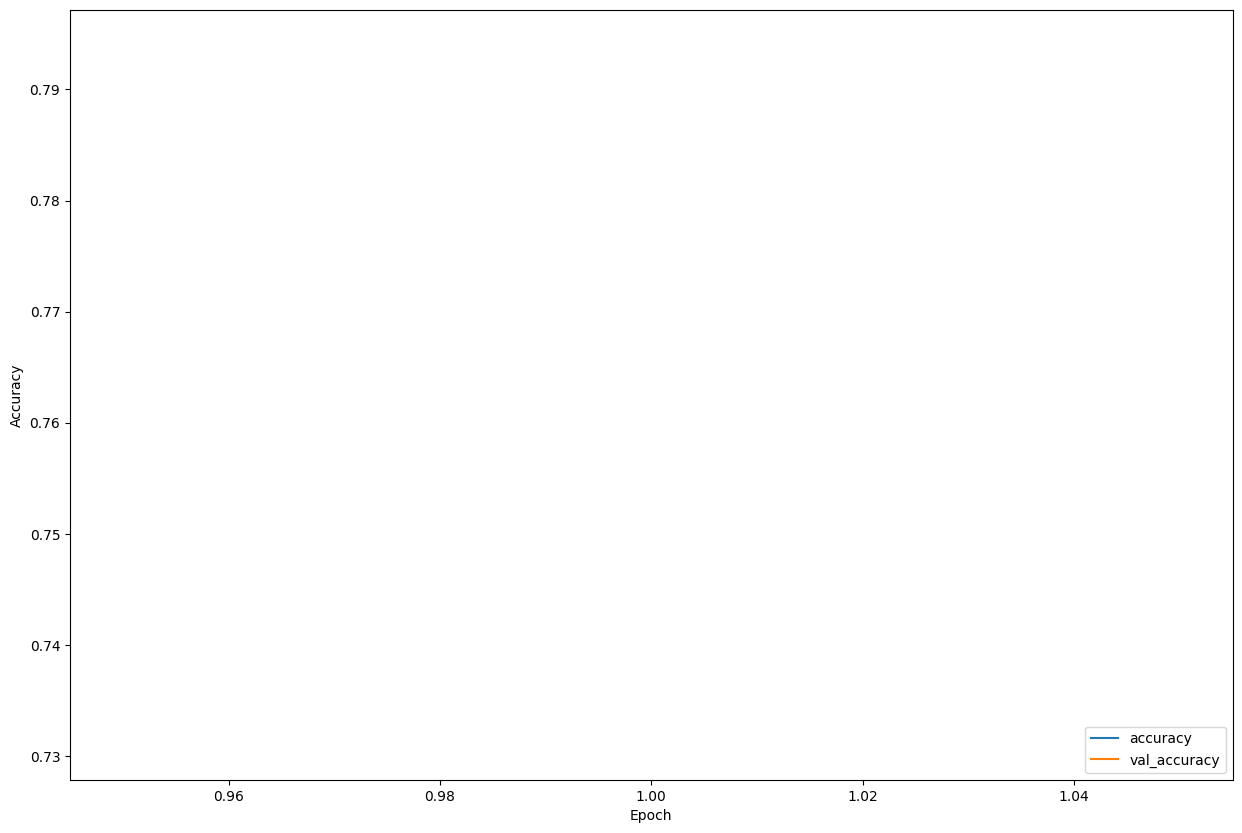

In [7]:
# plot history
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
epochs = range(1, len(history.history["loss"]) + 1)
ax.plot(epochs, history.history["accuracy"], label="accuracy")
ax.plot(epochs, history.history["val_accuracy"], label="val_accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [8]:
# calculate model size on disk, flops and number of parameters

flops = wandb.run.summary["GFLOPs"]
disk_size = calculate_model_size_on_disk(f"./artifacts/{MODEL_NAME}.h5")
num_parameters = calculate_model_num_parameters(model)

# evaluate model on ds_test and log to wandb
test_loss, test_acc = model.evaluate(ds_test)

wandb.log({
    "test loss": test_loss, 
    "test accuracy": test_acc, 
    "number of parameters": num_parameters,
    "disk size": disk_size, 
    "model flops": flops
    })


diacritics = {
    62: "ą",
    63: "ć",
    64: "ę",
    65: "ł",
    66: "ń",
    67: "ó",
    68: "ś",
    69: "ź",
    70: "ż",
    71: "Ą",
    72: "Ć",
    73: "Ę",
    74: "Ł",
    75: "Ń",
    76: "Ó",
    77: "Ś",
    78: "Ź",
    79: "Ż"
}

# log test accuracy on these classes separately to wandb

diacritics_acc = {}
for diacritic_label in diacritics.keys():
    ds_test_diacritic = ds_test.filter(lambda x, y: tf.equal(y, diacritic_label))
    test_loss, test_acc = model.evaluate(ds_test_diacritic)
    diacritics_acc[diacritic_label] = {
        "loss": test_loss,
        "accuracy": test_acc,
        "label": diacritics[diacritic_label],
    }

wandb.log(diacritics_acc)

      1/Unknown - 0s 64ms/step - loss: 0.5802 - accuracy: 0.7812

      4/Unknown - 0s 20ms/step - loss: 0.5959 - accuracy: 0.7734

      7/Unknown - 0s 21ms/step - loss: 0.5686 - accuracy: 0.7891

     10/Unknown - 0s 21ms/step - loss: 0.5988 - accuracy: 0.7844

     13/Unknown - 0s 21ms/step - loss: 0.5897 - accuracy: 0.7873

     15/Unknown - 0s 22ms/step - loss: 0.5773 - accuracy: 0.7891

     17/Unknown - 0s 22ms/step - loss: 0.5752 - accuracy: 0.7923

     19/Unknown - 0s 23ms/step - loss: 0.5883 - accuracy: 0.7874

     21/Unknown - 1s 23ms/step - loss: 0.5785 - accuracy: 0.7898

     23/Unknown - 1s 23ms/step - loss: 0.5771 - accuracy: 0.7908

     25/Unknown - 1s 24ms/step - loss: 0.5696 - accuracy: 0.7937

     27/Unknown - 1s 24ms/step - loss: 0.5721 - accuracy: 0.7922

     29/Unknown - 1s 24ms/step - loss: 0.5742 - accuracy: 0.7907

     32/Unknown - 1s 24ms/step - loss: 0.5709 - accuracy: 0.7908

     34/Unknown - 1s 25ms/step - loss: 0.5680 - accuracy: 0.7927

     36/Unknown - 1s 25ms/step - loss: 0.5635 - accuracy: 0.7971

     38/Unknown - 1s 26ms/step - loss: 0.5629 - accuracy: 0.7975

     40/Unknown - 1s 26ms/step - loss: 0.5587 - accuracy: 0.7979

     42/Unknown - 1s 26ms/step - loss: 0.5580 - accuracy: 0.7982

     44/Unknown - 1s 26ms/step - loss: 0.5567 - accuracy: 0.7978

     46/Unknown - 1s 26ms/step - loss: 0.5581 - accuracy: 0.7986

     48/Unknown - 1s 26ms/step - loss: 0.5531 - accuracy: 0.8001

     50/Unknown - 1s 27ms/step - loss: 0.5561 - accuracy: 0.7972

     52/Unknown - 1s 26ms/step - loss: 0.5565 - accuracy: 0.7963

     55/Unknown - 1s 26ms/step - loss: 0.5572 - accuracy: 0.7967

     58/Unknown - 2s 26ms/step - loss: 0.5574 - accuracy: 0.7967

     61/Unknown - 2s 26ms/step - loss: 0.5598 - accuracy: 0.7957

     64/Unknown - 2s 26ms/step - loss: 0.5613 - accuracy: 0.7952

     67/Unknown - 2s 26ms/step - loss: 0.5594 - accuracy: 0.7948

     70/Unknown - 2s 26ms/step - loss: 0.5617 - accuracy: 0.7950

     72/Unknown - 2s 26ms/step - loss: 0.5633 - accuracy: 0.7944

     74/Unknown - 2s 26ms/step - loss: 0.5628 - accuracy: 0.7942

     76/Unknown - 2s 26ms/step - loss: 0.5614 - accuracy: 0.7945

     79/Unknown - 2s 26ms/step - loss: 0.5589 - accuracy: 0.7946

     82/Unknown - 2s 26ms/step - loss: 0.5595 - accuracy: 0.7947

     85/Unknown - 2s 26ms/step - loss: 0.5585 - accuracy: 0.7953

     88/Unknown - 2s 26ms/step - loss: 0.5581 - accuracy: 0.7952

     91/Unknown - 2s 26ms/step - loss: 0.5582 - accuracy: 0.7947

     94/Unknown - 2s 26ms/step - loss: 0.5591 - accuracy: 0.7948

     96/Unknown - 3s 26ms/step - loss: 0.5584 - accuracy: 0.7953

     98/Unknown - 3s 26ms/step - loss: 0.5620 - accuracy: 0.7941

    100/Unknown - 3s 26ms/step - loss: 0.5617 - accuracy: 0.7940

    103/Unknown - 3s 26ms/step - loss: 0.5642 - accuracy: 0.7931

    105/Unknown - 3s 26ms/step - loss: 0.5632 - accuracy: 0.7934

    107/Unknown - 3s 26ms/step - loss: 0.5647 - accuracy: 0.7921

    109/Unknown - 3s 26ms/step - loss: 0.5642 - accuracy: 0.7926

    111/Unknown - 3s 26ms/step - loss: 0.5636 - accuracy: 0.7924

    113/Unknown - 3s 26ms/step - loss: 0.5632 - accuracy: 0.7929

    115/Unknown - 3s 26ms/step - loss: 0.5624 - accuracy: 0.7937

    118/Unknown - 3s 26ms/step - loss: 0.5622 - accuracy: 0.7932

    120/Unknown - 3s 26ms/step - loss: 0.5610 - accuracy: 0.7936

    123/Unknown - 3s 26ms/step - loss: 0.5601 - accuracy: 0.7939

    125/Unknown - 3s 26ms/step - loss: 0.5626 - accuracy: 0.7931

    127/Unknown - 3s 26ms/step - loss: 0.5628 - accuracy: 0.7924

    129/Unknown - 3s 26ms/step - loss: 0.5629 - accuracy: 0.7923

    131/Unknown - 3s 26ms/step - loss: 0.5627 - accuracy: 0.7922

    133/Unknown - 3s 26ms/step - loss: 0.5653 - accuracy: 0.7926

    136/Unknown - 4s 26ms/step - loss: 0.5666 - accuracy: 0.7920

    138/Unknown - 4s 26ms/step - loss: 0.5670 - accuracy: 0.7917

    141/Unknown - 4s 26ms/step - loss: 0.5663 - accuracy: 0.7917

    143/Unknown - 4s 26ms/step - loss: 0.5653 - accuracy: 0.7916

    145/Unknown - 4s 26ms/step - loss: 0.5657 - accuracy: 0.7914

    148/Unknown - 4s 26ms/step - loss: 0.5628 - accuracy: 0.7922

    151/Unknown - 4s 26ms/step - loss: 0.5624 - accuracy: 0.7927

    154/Unknown - 4s 26ms/step - loss: 0.5606 - accuracy: 0.7933

    156/Unknown - 4s 26ms/step - loss: 0.5606 - accuracy: 0.7934

    158/Unknown - 4s 26ms/step - loss: 0.5619 - accuracy: 0.7929

    160/Unknown - 4s 26ms/step - loss: 0.5616 - accuracy: 0.7929

    162/Unknown - 4s 26ms/step - loss: 0.5604 - accuracy: 0.7933

    165/Unknown - 4s 26ms/step - loss: 0.5602 - accuracy: 0.7933

    167/Unknown - 4s 26ms/step - loss: 0.5599 - accuracy: 0.7929

    169/Unknown - 4s 26ms/step - loss: 0.5608 - accuracy: 0.7931

    172/Unknown - 4s 26ms/step - loss: 0.5598 - accuracy: 0.7935

    175/Unknown - 5s 26ms/step - loss: 0.5593 - accuracy: 0.7938

    178/Unknown - 5s 26ms/step - loss: 0.5575 - accuracy: 0.7945

    180/Unknown - 5s 26ms/step - loss: 0.5568 - accuracy: 0.7947

    183/Unknown - 5s 26ms/step - loss: 0.5581 - accuracy: 0.7943

    185/Unknown - 5s 26ms/step - loss: 0.5574 - accuracy: 0.7947

    187/Unknown - 5s 26ms/step - loss: 0.5569 - accuracy: 0.7945

    189/Unknown - 5s 26ms/step - loss: 0.5564 - accuracy: 0.7945

    191/Unknown - 5s 26ms/step - loss: 0.5564 - accuracy: 0.7945

    193/Unknown - 5s 26ms/step - loss: 0.5570 - accuracy: 0.7942

    195/Unknown - 5s 26ms/step - loss: 0.5572 - accuracy: 0.7940

    198/Unknown - 5s 26ms/step - loss: 0.5574 - accuracy: 0.7940

    201/Unknown - 5s 26ms/step - loss: 0.5573 - accuracy: 0.7940

    204/Unknown - 5s 26ms/step - loss: 0.5565 - accuracy: 0.7941

    207/Unknown - 5s 26ms/step - loss: 0.5568 - accuracy: 0.7939

    210/Unknown - 6s 26ms/step - loss: 0.5556 - accuracy: 0.7945

    212/Unknown - 6s 26ms/step - loss: 0.5558 - accuracy: 0.7943

    215/Unknown - 6s 26ms/step - loss: 0.5566 - accuracy: 0.7941

    218/Unknown - 6s 26ms/step - loss: 0.5564 - accuracy: 0.7939

    220/Unknown - 6s 26ms/step - loss: 0.5567 - accuracy: 0.7938

    222/Unknown - 6s 26ms/step - loss: 0.5565 - accuracy: 0.7940

    224/Unknown - 6s 26ms/step - loss: 0.5566 - accuracy: 0.7941

    226/Unknown - 6s 26ms/step - loss: 0.5566 - accuracy: 0.7940

    228/Unknown - 6s 26ms/step - loss: 0.5562 - accuracy: 0.7940

    230/Unknown - 6s 26ms/step - loss: 0.5559 - accuracy: 0.7940

    232/Unknown - 6s 26ms/step - loss: 0.5555 - accuracy: 0.7941

    234/Unknown - 6s 26ms/step - loss: 0.5559 - accuracy: 0.7940

    236/Unknown - 6s 26ms/step - loss: 0.5562 - accuracy: 0.7939

    238/Unknown - 6s 26ms/step - loss: 0.5566 - accuracy: 0.7938

    240/Unknown - 6s 26ms/step - loss: 0.5573 - accuracy: 0.7933

    242/Unknown - 6s 26ms/step - loss: 0.5576 - accuracy: 0.7930

    244/Unknown - 6s 26ms/step - loss: 0.5579 - accuracy: 0.7932

    246/Unknown - 7s 26ms/step - loss: 0.5581 - accuracy: 0.7930

    248/Unknown - 7s 26ms/step - loss: 0.5584 - accuracy: 0.7929

    251/Unknown - 7s 26ms/step - loss: 0.5581 - accuracy: 0.7930

    253/Unknown - 7s 26ms/step - loss: 0.5582 - accuracy: 0.7931

    255/Unknown - 7s 26ms/step - loss: 0.5576 - accuracy: 0.7931

    257/Unknown - 7s 26ms/step - loss: 0.5576 - accuracy: 0.7929

    259/Unknown - 7s 26ms/step - loss: 0.5580 - accuracy: 0.7928

    262/Unknown - 7s 26ms/step - loss: 0.5573 - accuracy: 0.7932

    264/Unknown - 7s 26ms/step - loss: 0.5569 - accuracy: 0.7934

    266/Unknown - 7s 26ms/step - loss: 0.5567 - accuracy: 0.7934

    268/Unknown - 7s 26ms/step - loss: 0.5565 - accuracy: 0.7936

    270/Unknown - 7s 26ms/step - loss: 0.5569 - accuracy: 0.7934

    272/Unknown - 7s 26ms/step - loss: 0.5574 - accuracy: 0.7931

    275/Unknown - 7s 26ms/step - loss: 0.5576 - accuracy: 0.7928

    278/Unknown - 7s 26ms/step - loss: 0.5578 - accuracy: 0.7926

    281/Unknown - 7s 26ms/step - loss: 0.5587 - accuracy: 0.7924

    284/Unknown - 8s 26ms/step - loss: 0.5580 - accuracy: 0.7926

    287/Unknown - 8s 26ms/step - loss: 0.5578 - accuracy: 0.7926

    289/Unknown - 8s 26ms/step - loss: 0.5573 - accuracy: 0.7929

    291/Unknown - 8s 26ms/step - loss: 0.5574 - accuracy: 0.7928

    293/Unknown - 8s 26ms/step - loss: 0.5569 - accuracy: 0.7931

    295/Unknown - 8s 26ms/step - loss: 0.5571 - accuracy: 0.7931

    297/Unknown - 8s 26ms/step - loss: 0.5570 - accuracy: 0.7932

    299/Unknown - 8s 26ms/step - loss: 0.5566 - accuracy: 0.7935

    301/Unknown - 8s 27ms/step - loss: 0.5570 - accuracy: 0.7932

    303/Unknown - 8s 27ms/step - loss: 0.5567 - accuracy: 0.7933

    305/Unknown - 8s 27ms/step - loss: 0.5563 - accuracy: 0.7934

    307/Unknown - 8s 27ms/step - loss: 0.5565 - accuracy: 0.7933

    309/Unknown - 8s 27ms/step - loss: 0.5556 - accuracy: 0.7936

    311/Unknown - 8s 27ms/step - loss: 0.5559 - accuracy: 0.7935

    313/Unknown - 8s 27ms/step - loss: 0.5562 - accuracy: 0.7935

    315/Unknown - 8s 27ms/step - loss: 0.5564 - accuracy: 0.7933

    317/Unknown - 8s 27ms/step - loss: 0.5563 - accuracy: 0.7934

    319/Unknown - 9s 27ms/step - loss: 0.5561 - accuracy: 0.7934

    321/Unknown - 9s 27ms/step - loss: 0.5561 - accuracy: 0.7933

    323/Unknown - 9s 27ms/step - loss: 0.5557 - accuracy: 0.7935

    325/Unknown - 9s 27ms/step - loss: 0.5552 - accuracy: 0.7938

    327/Unknown - 9s 27ms/step - loss: 0.5546 - accuracy: 0.7938

    329/Unknown - 9s 27ms/step - loss: 0.5547 - accuracy: 0.7938

    331/Unknown - 9s 27ms/step - loss: 0.5551 - accuracy: 0.7937

    333/Unknown - 9s 27ms/step - loss: 0.5550 - accuracy: 0.7935

    335/Unknown - 9s 27ms/step - loss: 0.5551 - accuracy: 0.7934

    337/Unknown - 9s 27ms/step - loss: 0.5550 - accuracy: 0.7935

    339/Unknown - 9s 27ms/step - loss: 0.5547 - accuracy: 0.7935

    342/Unknown - 9s 27ms/step - loss: 0.5543 - accuracy: 0.7937

    345/Unknown - 9s 27ms/step - loss: 0.5543 - accuracy: 0.7937

    348/Unknown - 9s 27ms/step - loss: 0.5540 - accuracy: 0.7939

    351/Unknown - 9s 27ms/step - loss: 0.5531 - accuracy: 0.7942

    353/Unknown - 9s 27ms/step - loss: 0.5528 - accuracy: 0.7942

    355/Unknown - 9s 27ms/step - loss: 0.5534 - accuracy: 0.7942

    357/Unknown - 10s 27ms/step - loss: 0.5536 - accuracy: 0.7941

    359/Unknown - 10s 27ms/step - loss: 0.5543 - accuracy: 0.7941

    361/Unknown - 10s 27ms/step - loss: 0.5538 - accuracy: 0.7942

    364/Unknown - 10s 27ms/step - loss: 0.5535 - accuracy: 0.7943

    367/Unknown - 10s 27ms/step - loss: 0.5535 - accuracy: 0.7945

    369/Unknown - 10s 27ms/step - loss: 0.5537 - accuracy: 0.7945

    372/Unknown - 10s 27ms/step - loss: 0.5544 - accuracy: 0.7941

    375/Unknown - 10s 27ms/step - loss: 0.5541 - accuracy: 0.7942

    378/Unknown - 10s 26ms/step - loss: 0.5536 - accuracy: 0.7945

    381/Unknown - 10s 26ms/step - loss: 0.5536 - accuracy: 0.7943

    384/Unknown - 10s 26ms/step - loss: 0.5533 - accuracy: 0.7945

    386/Unknown - 10s 26ms/step - loss: 0.5530 - accuracy: 0.7946

    389/Unknown - 10s 26ms/step - loss: 0.5531 - accuracy: 0.7945

    392/Unknown - 10s 26ms/step - loss: 0.5530 - accuracy: 0.7946

    395/Unknown - 10s 26ms/step - loss: 0.5524 - accuracy: 0.7948

    398/Unknown - 10s 26ms/step - loss: 0.5523 - accuracy: 0.7947

    401/Unknown - 11s 26ms/step - loss: 0.5520 - accuracy: 0.7948

    404/Unknown - 11s 26ms/step - loss: 0.5526 - accuracy: 0.7944

    407/Unknown - 11s 26ms/step - loss: 0.5526 - accuracy: 0.7942

    409/Unknown - 11s 26ms/step - loss: 0.5525 - accuracy: 0.7942

    411/Unknown - 11s 26ms/step - loss: 0.5530 - accuracy: 0.7940

    413/Unknown - 11s 26ms/step - loss: 0.5527 - accuracy: 0.7941

    415/Unknown - 11s 26ms/step - loss: 0.5533 - accuracy: 0.7938

    417/Unknown - 11s 26ms/step - loss: 0.5530 - accuracy: 0.7939

    419/Unknown - 11s 26ms/step - loss: 0.5532 - accuracy: 0.7940

    421/Unknown - 11s 26ms/step - loss: 0.5531 - accuracy: 0.7939

    423/Unknown - 11s 26ms/step - loss: 0.5529 - accuracy: 0.7938

    425/Unknown - 11s 26ms/step - loss: 0.5530 - accuracy: 0.7938

    427/Unknown - 11s 26ms/step - loss: 0.5529 - accuracy: 0.7937

    429/Unknown - 11s 26ms/step - loss: 0.5528 - accuracy: 0.7938

    431/Unknown - 11s 26ms/step - loss: 0.5525 - accuracy: 0.7938

    433/Unknown - 11s 26ms/step - loss: 0.5522 - accuracy: 0.7940

    435/Unknown - 12s 26ms/step - loss: 0.5522 - accuracy: 0.7940

436/436 [==============================] - 12s 26ms/step - loss: 0.5521 - accuracy: 0.7940


ValueError: Invalid `predicate`. `predicate` must return a `tf.bool` scalar tensor, but its return type is TensorSpec(shape=(None,), dtype=tf.bool, name=None).

In [ ]:
# save artifact to wandb
artifact = wandb.Artifact(
    name=MODEL_NAME,
    type="model"
)

# save best model to artifact
artifact.add_file(f"./artifacts/{MODEL_NAME}.h5")
run.log_artifact(artifact)
run.finish()